In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np

In [2]:
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

In [3]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [4]:
def get_generator():
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer='rmsprop')
    generator.summary()
    return generator

In [5]:
def get_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')

    discriminator.summary()
    return discriminator

In [6]:
def get_gan_network(discriminator, random_dim, generator):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [10]:
def train(epochs=1000, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    generator = get_generator()
    discriminator = get_discriminator()
    gan = get_gan_network(discriminator, random_dim, generator)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

In [11]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [ ]:
train()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 784)              

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|          | 1/468 [00:01<09:53,  1.27s/it]

4/4 [==============================] - 0s 4ms/step


  0%|          | 2/468 [00:01<04:44,  1.64it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 3/468 [00:01<03:04,  2.52it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 4/468 [00:01<02:16,  3.39it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 5/468 [00:01<01:59,  3.87it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▏         | 6/468 [00:02<01:42,  4.51it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▏         | 7/468 [00:02<01:30,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 8/468 [00:02<01:29,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 9/468 [00:02<01:22,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 10/468 [00:02<01:17,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 11/468 [00:02<01:14,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 12/468 [00:02<01:11,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 13/468 [00:03<01:08,  6.60it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 14/468 [00:03<01:07,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 15/468 [00:03<01:08,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 16/468 [00:03<01:06,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▎         | 17/468 [00:03<01:06,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 18/468 [00:03<01:11,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 19/468 [00:04<01:12,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 20/468 [00:04<01:12,  6.20it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 21/468 [00:04<01:10,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 22/468 [00:04<01:08,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 23/468 [00:04<01:12,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 24/468 [00:04<01:11,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 25/468 [00:04<01:09,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 26/468 [00:05<01:08,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 27/468 [00:05<01:07,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 28/468 [00:05<01:13,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 29/468 [00:05<01:10,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 30/468 [00:05<01:08,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 31/468 [00:05<01:12,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 32/468 [00:06<01:09,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 33/468 [00:06<01:07,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 34/468 [00:06<01:06,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 35/468 [00:06<01:07,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 36/468 [00:06<01:05,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 37/468 [00:06<01:11,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 38/468 [00:07<01:09,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 39/468 [00:07<01:06,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 40/468 [00:07<01:04,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 41/468 [00:07<01:03,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 42/468 [00:07<01:07,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 43/468 [00:07<01:11,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 44/468 [00:08<01:09,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 10%|▉         | 45/468 [00:08<01:07,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 46/468 [00:08<01:06,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 47/468 [00:08<01:05,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 48/468 [00:08<01:09,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 49/468 [00:08<01:07,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 50/468 [00:08<01:05,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 51/468 [00:09<01:04,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 52/468 [00:09<01:02,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 53/468 [00:09<01:01,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 54/468 [00:09<01:01,  6.73it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 55/468 [00:09<01:12,  5.71it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 56/468 [00:09<01:14,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 57/468 [00:10<01:16,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 58/468 [00:10<01:17,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 59/468 [00:10<01:20,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 60/468 [00:10<01:23,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 13%|█▎        | 61/468 [00:10<01:22,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 62/468 [00:11<01:18,  5.16it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 63/468 [00:11<01:12,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▎        | 64/468 [00:11<01:07,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 65/468 [00:11<01:05,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 66/468 [00:11<01:07,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 67/468 [00:11<01:05,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 68/468 [00:12<01:02,  6.39it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 69/468 [00:12<01:01,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 70/468 [00:12<01:05,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 71/468 [00:12<01:03,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 72/468 [00:12<01:00,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 73/468 [00:12<01:05,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 74/468 [00:13<01:02,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 75/468 [00:13<01:01,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 76/468 [00:13<01:00,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 77/468 [00:13<00:59,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 78/468 [00:13<01:02,  6.20it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 79/468 [00:13<01:02,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 80/468 [00:13<00:59,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 81/468 [00:14<00:58,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 82/468 [00:14<01:02,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 83/468 [00:14<01:05,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 84/468 [00:14<01:02,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 85/468 [00:14<01:01,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 86/468 [00:14<00:58,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▊        | 87/468 [00:15<00:58,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 88/468 [00:15<00:57,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 89/468 [00:15<00:55,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 90/468 [00:15<00:54,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 91/468 [00:15<00:54,  6.97it/s]

4/4 [==============================] - 0s 6ms/step


 20%|█▉        | 92/468 [00:15<00:55,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 93/468 [00:16<01:14,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 94/468 [00:16<01:16,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 95/468 [00:16<01:16,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 96/468 [00:16<01:09,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 97/468 [00:17<01:27,  4.22it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 98/468 [00:17<01:17,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 99/468 [00:17<01:15,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██▏       | 100/468 [00:17<01:09,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 101/468 [00:17<01:04,  5.70it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 102/468 [00:17<01:06,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 103/468 [00:18<01:01,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 104/468 [00:18<00:58,  6.22it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 105/468 [00:18<01:02,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 106/468 [00:18<00:59,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 107/468 [00:18<01:02,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 108/468 [00:18<00:59,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 109/468 [00:19<01:01,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▎       | 110/468 [00:19<01:03,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▎       | 111/468 [00:19<01:01,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 112/468 [00:19<01:04,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 113/468 [00:19<00:59,  5.94it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 114/468 [00:19<01:02,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▍       | 115/468 [00:20<00:59,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▍       | 116/468 [00:20<00:56,  6.22it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 117/468 [00:20<00:56,  6.25it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 118/468 [00:20<00:59,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 119/468 [00:20<00:57,  6.11it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 120/468 [00:20<00:55,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 121/468 [00:21<00:58,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 122/468 [00:21<01:03,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▋       | 123/468 [00:21<01:05,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 124/468 [00:21<01:04,  5.30it/s]

4/4 [==============================] - 0s 7ms/step


 27%|██▋       | 125/468 [00:21<01:08,  5.03it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 126/468 [00:22<01:11,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 127/468 [00:22<01:13,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 128/468 [00:22<01:16,  4.46it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 129/468 [00:22<01:13,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 130/468 [00:22<01:06,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 131/468 [00:23<01:06,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 132/468 [00:23<01:04,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 133/468 [00:23<01:04,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▊       | 134/468 [00:23<01:00,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 135/468 [00:23<01:00,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 136/468 [00:23<00:57,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 137/468 [00:24<00:54,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 138/468 [00:24<00:56,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 139/468 [00:24<00:55,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 140/468 [00:24<00:57,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 141/468 [00:24<00:54,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 142/468 [00:25<00:57,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 143/468 [00:25<00:59,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 144/468 [00:25<00:57,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 145/468 [00:25<00:58,  5.47it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███       | 146/468 [00:25<00:54,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 147/468 [00:25<00:52,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 148/468 [00:26<00:54,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 149/468 [00:26<00:56,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 150/468 [00:26<00:54,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 151/468 [00:26<00:52,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 152/468 [00:26<00:54,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 153/468 [00:26<00:51,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 154/468 [00:27<00:53,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 155/468 [00:27<00:55,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 156/468 [00:27<00:53,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 157/468 [00:27<00:51,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 158/468 [00:27<00:53,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 159/468 [00:27<00:51,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 160/468 [00:28<00:49,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 161/468 [00:28<00:52,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▍      | 162/468 [00:28<00:50,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▍      | 163/468 [00:28<00:53,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 164/468 [00:28<00:51,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 165/468 [00:28<00:49,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 166/468 [00:29<00:48,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 167/468 [00:29<00:47,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 168/468 [00:29<00:49,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 169/468 [00:29<00:52,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▋      | 170/468 [00:29<00:50,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 171/468 [00:29<00:48,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 172/468 [00:30<00:46,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 173/468 [00:30<00:47,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 174/468 [00:30<00:49,  5.90it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 175/468 [00:30<00:52,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 176/468 [00:30<00:53,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 177/468 [00:30<00:50,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 178/468 [00:31<00:52,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 179/468 [00:31<00:49,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 180/468 [00:31<00:48,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▊      | 181/468 [00:31<00:50,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 182/468 [00:31<00:48,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 183/468 [00:31<00:47,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 184/468 [00:32<00:49,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 185/468 [00:32<00:50,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 186/468 [00:32<00:47,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 187/468 [00:32<00:52,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 188/468 [00:32<00:53,  5.19it/s]

4/4 [==============================] - 0s 7ms/step


 40%|████      | 189/468 [00:33<00:53,  5.18it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 190/468 [00:33<00:54,  5.07it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 191/468 [00:33<00:55,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 192/468 [00:33<00:58,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 193/468 [00:34<01:01,  4.51it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 194/468 [00:34<00:59,  4.62it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 195/468 [00:34<00:56,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 196/468 [00:34<00:51,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 197/468 [00:34<00:48,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 198/468 [00:34<00:49,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 199/468 [00:35<00:46,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 200/468 [00:35<00:48,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 201/468 [00:35<00:49,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 202/468 [00:35<00:50,  5.24it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 203/468 [00:35<00:48,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▎     | 204/468 [00:35<00:45,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 205/468 [00:36<00:43,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 206/468 [00:36<00:45,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 207/468 [00:36<00:43,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 208/468 [00:36<00:42,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 209/468 [00:36<00:44,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 210/468 [00:36<00:42,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 211/468 [00:37<00:40,  6.29it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▌     | 212/468 [00:37<00:44,  5.70it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 213/468 [00:37<00:46,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 214/468 [00:37<00:44,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 215/468 [00:37<00:45,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 216/468 [00:38<00:43,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▋     | 217/468 [00:38<00:44,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 218/468 [00:38<00:45,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 219/468 [00:38<00:45,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 220/468 [00:38<00:43,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 221/468 [00:38<00:41,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 222/468 [00:39<00:40,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 223/468 [00:39<00:41,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 224/468 [00:39<00:39,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 225/468 [00:39<00:41,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 226/468 [00:39<00:43,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▊     | 227/468 [00:39<00:41,  5.85it/s]

4/4 [==============================] - 0s 7ms/step


 49%|████▊     | 228/468 [00:40<00:39,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 229/468 [00:40<00:39,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 230/468 [00:40<00:38,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 231/468 [00:40<00:37,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 232/468 [00:40<00:36,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 233/468 [00:40<00:39,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 234/468 [00:41<00:37,  6.24it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 235/468 [00:41<00:39,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 236/468 [00:41<00:38,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 237/468 [00:41<00:37,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 238/468 [00:41<00:35,  6.40it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████     | 239/468 [00:41<00:38,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████▏    | 240/468 [00:42<00:37,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████▏    | 241/468 [00:42<00:38,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 242/468 [00:42<00:37,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 243/468 [00:42<00:37,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 244/468 [00:42<00:38,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 245/468 [00:42<00:38,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 246/468 [00:43<00:39,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 247/468 [00:43<00:40,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 248/468 [00:43<00:40,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 249/468 [00:43<00:40,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 250/468 [00:43<00:38,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▎    | 251/468 [00:44<00:39,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 252/468 [00:44<00:40,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 253/468 [00:44<00:44,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


 54%|█████▍    | 254/468 [00:44<00:43,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 255/468 [00:44<00:43,  4.89it/s]

4/4 [==============================] - 0s 8ms/step


 55%|█████▍    | 256/468 [00:45<00:44,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 55%|█████▍    | 257/468 [00:45<00:45,  4.63it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 258/468 [00:45<00:46,  4.55it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 259/468 [00:45<00:45,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 260/468 [00:45<00:42,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 261/468 [00:46<00:40,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 262/468 [00:46<00:40,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▌    | 263/468 [00:46<00:39,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 264/468 [00:46<00:39,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 265/468 [00:46<00:39,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 266/468 [00:47<00:36,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 267/468 [00:47<00:36,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 268/468 [00:47<00:34,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 269/468 [00:47<00:35,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 270/468 [00:47<00:33,  5.89it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 271/468 [00:47<00:34,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 272/468 [00:48<00:35,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 273/468 [00:48<00:34,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 274/468 [00:48<00:34,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 275/468 [00:48<00:34,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 276/468 [00:48<00:32,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 277/468 [00:48<00:33,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 278/468 [00:49<00:33,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 279/468 [00:49<00:32,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 60%|█████▉    | 280/468 [00:49<00:34,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 281/468 [00:49<00:32,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 282/468 [00:49<00:31,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 283/468 [00:50<00:31,  5.96it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 284/468 [00:50<00:32,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 285/468 [00:50<00:30,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 286/468 [00:50<00:29,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████▏   | 287/468 [00:50<00:28,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 288/468 [00:50<00:29,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 289/468 [00:51<00:31,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 290/468 [00:51<00:29,  5.95it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 291/468 [00:51<00:29,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 292/468 [00:51<00:30,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 293/468 [00:51<00:30,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 294/468 [00:51<00:30,  5.66it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 295/468 [00:52<00:31,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 296/468 [00:52<00:29,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 297/468 [00:52<00:30,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▎   | 298/468 [00:52<00:30,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 299/468 [00:52<00:29,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 300/468 [00:52<00:29,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 301/468 [00:53<00:31,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 302/468 [00:53<00:31,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 303/468 [00:53<00:31,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 304/468 [00:53<00:30,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▌   | 305/468 [00:53<00:30,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▌   | 306/468 [00:54<00:28,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 307/468 [00:54<00:29,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 308/468 [00:54<00:29,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 309/468 [00:54<00:29,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 310/468 [00:54<00:30,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 311/468 [00:54<00:28,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 312/468 [00:55<00:28,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 313/468 [00:55<00:29,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 314/468 [00:55<00:29,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 315/468 [00:55<00:29,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 316/468 [00:55<00:30,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 317/468 [00:56<00:32,  4.67it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 318/468 [00:56<00:32,  4.57it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 319/468 [00:56<00:32,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 320/468 [00:56<00:33,  4.46it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▊   | 321/468 [00:57<00:54,  2.68it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 322/468 [00:57<00:44,  3.25it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 323/468 [00:57<00:39,  3.66it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 324/468 [00:58<00:36,  3.98it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 325/468 [00:58<00:32,  4.46it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 326/468 [00:58<00:30,  4.62it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 327/468 [00:58<00:27,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 328/468 [00:58<00:25,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 329/468 [00:59<00:23,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 330/468 [00:59<00:23,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 331/468 [00:59<00:24,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 332/468 [00:59<00:24,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 333/468 [00:59<00:23,  5.77it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████▏  | 334/468 [00:59<00:22,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 335/468 [01:00<00:23,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 336/468 [01:00<00:23,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 337/468 [01:00<00:24,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 338/468 [01:00<00:23,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 339/468 [01:00<00:23,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 340/468 [01:00<00:23,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 341/468 [01:01<00:24,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 342/468 [01:01<00:24,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 343/468 [01:01<00:22,  5.51it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▎  | 344/468 [01:01<00:21,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 345/468 [01:01<00:22,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 346/468 [01:02<00:20,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 347/468 [01:02<00:21,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 348/468 [01:02<00:21,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▍  | 349/468 [01:02<00:22,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 350/468 [01:02<00:22,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 351/468 [01:03<00:22,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 352/468 [01:03<00:22,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 353/468 [01:03<00:20,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 354/468 [01:03<00:19,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 355/468 [01:03<00:18,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 356/468 [01:03<00:17,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▋  | 357/468 [01:04<00:18,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 358/468 [01:04<00:18,  5.96it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 359/468 [01:04<00:18,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 360/468 [01:04<00:17,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 361/468 [01:04<00:17,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 362/468 [01:04<00:16,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 363/468 [01:04<00:17,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 364/468 [01:05<00:18,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 365/468 [01:05<00:17,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 366/468 [01:05<00:16,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 367/468 [01:05<00:17,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▊  | 368/468 [01:05<00:18,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 369/468 [01:06<00:17,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 370/468 [01:06<00:16,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 371/468 [01:06<00:17,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 372/468 [01:06<00:16,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 373/468 [01:06<00:15,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 374/468 [01:06<00:16,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 375/468 [01:07<00:16,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 376/468 [01:07<00:16,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 377/468 [01:07<00:18,  4.91it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████  | 378/468 [01:07<00:19,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████  | 379/468 [01:07<00:18,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████  | 380/468 [01:08<00:18,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████▏ | 381/468 [01:08<00:18,  4.66it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 382/468 [01:08<00:19,  4.51it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 383/468 [01:08<00:18,  4.58it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 384/468 [01:09<00:18,  4.64it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 385/468 [01:09<00:16,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 386/468 [01:09<00:15,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 387/468 [01:09<00:14,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 388/468 [01:09<00:13,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 389/468 [01:09<00:14,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 390/468 [01:10<00:14,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 391/468 [01:10<00:13,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 392/468 [01:10<00:13,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 393/468 [01:10<00:13,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 394/468 [01:10<00:12,  5.88it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 395/468 [01:10<00:12,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▍ | 396/468 [01:11<00:12,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 397/468 [01:11<00:11,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 398/468 [01:11<00:12,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 399/468 [01:11<00:12,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 400/468 [01:11<00:11,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 401/468 [01:11<00:12,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 402/468 [01:12<00:12,  5.44it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 403/468 [01:12<00:12,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▋ | 404/468 [01:12<00:12,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 405/468 [01:12<00:11,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 406/468 [01:12<00:10,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 407/468 [01:13<00:09,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 408/468 [01:13<00:10,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 409/468 [01:13<00:10,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 410/468 [01:13<00:10,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 411/468 [01:13<00:10,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 412/468 [01:13<00:10,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 413/468 [01:14<00:09,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 414/468 [01:14<00:09,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▊ | 415/468 [01:14<00:09,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 416/468 [01:14<00:08,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 417/468 [01:14<00:08,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 418/468 [01:14<00:08,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 419/468 [01:15<00:08,  5.83it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 420/468 [01:15<00:08,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 421/468 [01:15<00:07,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 422/468 [01:15<00:07,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 423/468 [01:15<00:06,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 424/468 [01:15<00:06,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 425/468 [01:16<00:07,  6.00it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 426/468 [01:16<00:06,  6.03it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 427/468 [01:16<00:07,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 428/468 [01:16<00:06,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 429/468 [01:16<00:07,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 430/468 [01:17<00:07,  5.40it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 431/468 [01:17<00:06,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 432/468 [01:17<00:06,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 433/468 [01:17<00:06,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 434/468 [01:17<00:06,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 435/468 [01:17<00:06,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 436/468 [01:18<00:06,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 437/468 [01:18<00:05,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▎| 438/468 [01:18<00:05,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 439/468 [01:18<00:05,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 440/468 [01:18<00:05,  5.37it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 441/468 [01:19<00:05,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 442/468 [01:19<00:05,  4.96it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▍| 443/468 [01:19<00:05,  4.98it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 444/468 [01:19<00:05,  4.61it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 445/468 [01:19<00:04,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 446/468 [01:20<00:04,  4.52it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 447/468 [01:20<00:04,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 448/468 [01:20<00:04,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 449/468 [01:20<00:04,  4.57it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 450/468 [01:21<00:03,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▋| 451/468 [01:21<00:03,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 452/468 [01:21<00:03,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 453/468 [01:21<00:02,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 454/468 [01:21<00:02,  5.57it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 455/468 [01:21<00:02,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 456/468 [01:22<00:02,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 457/468 [01:22<00:01,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 458/468 [01:22<00:01,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 459/468 [01:22<00:01,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 460/468 [01:22<00:01,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▊| 461/468 [01:23<00:01,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▊| 462/468 [01:23<00:01,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 463/468 [01:23<00:00,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 464/468 [01:23<00:00,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 465/468 [01:23<00:00,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


100%|█████████▉| 466/468 [01:23<00:00,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 467/468 [01:24<00:00,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 468/468 [01:24<00:00,  5.56it/s]


4/4 [==============================] - 0s 4ms/step
--------------- Epoch 2 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|          | 1/468 [00:00<01:32,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 2/468 [00:00<01:33,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 3/468 [00:00<01:22,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 4/468 [00:00<01:17,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 5/468 [00:00<01:20,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 6/468 [00:01<01:22,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 7/468 [00:01<01:27,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 8/468 [00:01<01:28,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 9/468 [00:01<01:27,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 10/468 [00:01<01:27,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 11/468 [00:02<01:21,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 12/468 [00:02<01:22,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 13/468 [00:02<01:17,  5.85it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 14/468 [00:02<01:16,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 15/468 [00:02<01:19,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 16/468 [00:02<01:20,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▎         | 17/468 [00:03<01:21,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 18/468 [00:03<01:23,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 19/468 [00:03<01:17,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 20/468 [00:03<01:21,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 21/468 [00:03<01:16,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 22/468 [00:03<01:22,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 23/468 [00:04<01:22,  5.38it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▌         | 24/468 [00:04<01:27,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


  5%|▌         | 25/468 [00:04<01:34,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▌         | 26/468 [00:04<01:33,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 27/468 [00:05<01:33,  4.72it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 28/468 [00:05<01:35,  4.59it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▌         | 29/468 [00:05<01:40,  4.36it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 30/468 [00:05<01:38,  4.43it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 31/468 [00:05<01:35,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 32/468 [00:06<01:31,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 33/468 [00:06<01:24,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 34/468 [00:06<01:25,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 35/468 [00:06<01:24,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 36/468 [00:06<01:19,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 37/468 [00:07<01:16,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 38/468 [00:07<01:12,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 39/468 [00:07<01:09,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 40/468 [00:07<01:08,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 41/468 [00:07<01:09,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 42/468 [00:07<01:07,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 43/468 [00:08<01:13,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 44/468 [00:08<01:15,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 10%|▉         | 45/468 [00:08<01:18,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 46/468 [00:08<01:19,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 47/468 [00:08<01:19,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 48/468 [00:08<01:14,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 49/468 [00:09<01:16,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 50/468 [00:09<01:12,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 51/468 [00:09<01:09,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 52/468 [00:09<01:12,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█▏        | 53/468 [00:09<01:14,  5.57it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 54/468 [00:10<01:16,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 55/468 [00:10<01:13,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 56/468 [00:10<01:09,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 57/468 [00:10<01:11,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 58/468 [00:10<01:10,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 59/468 [00:10<01:07,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 60/468 [00:11<01:10,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 61/468 [00:11<01:11,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 62/468 [00:11<01:07,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 63/468 [00:11<01:07,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▎        | 64/468 [00:11<01:05,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 65/468 [00:11<01:08,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 66/468 [00:12<01:10,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 67/468 [00:12<01:07,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 68/468 [00:12<01:04,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 69/468 [00:12<01:07,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 70/468 [00:12<01:09,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 71/468 [00:12<01:06,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▌        | 72/468 [00:13<01:08,  5.75it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 73/468 [00:13<01:10,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 74/468 [00:13<01:12,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 75/468 [00:13<01:08,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 76/468 [00:13<01:07,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 77/468 [00:13<01:09,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 78/468 [00:14<01:06,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 79/468 [00:14<01:04,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 80/468 [00:14<01:03,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 81/468 [00:14<01:06,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 82/468 [00:14<01:09,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 83/468 [00:14<01:06,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 84/468 [00:15<01:03,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 85/468 [00:15<01:05,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 86/468 [00:15<01:03,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▊        | 87/468 [00:15<01:02,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 88/468 [00:15<01:06,  5.72it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 89/468 [00:16<01:14,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 90/468 [00:16<01:18,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 91/468 [00:16<01:19,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 92/468 [00:16<01:22,  4.55it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 93/468 [00:16<01:18,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 20%|██        | 94/468 [00:17<01:18,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 95/468 [00:17<01:20,  4.65it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 96/468 [00:17<01:15,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 97/468 [00:17<01:14,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 98/468 [00:17<01:12,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 99/468 [00:18<01:11,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██▏       | 100/468 [00:18<01:10,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 101/468 [00:18<01:10,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 102/468 [00:18<01:10,  5.21it/s]

4/4 [==============================] - 0s 8ms/step


 22%|██▏       | 103/468 [00:18<01:09,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 104/468 [00:19<01:10,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 105/468 [00:19<01:10,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 106/468 [00:19<01:10,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 107/468 [00:19<01:05,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 108/468 [00:19<01:02,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 109/468 [00:19<01:00,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▎       | 110/468 [00:20<00:59,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▎       | 111/468 [00:20<01:02,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 112/468 [00:20<00:59,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 113/468 [00:20<01:02,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 114/468 [00:20<00:58,  6.03it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▍       | 115/468 [00:20<01:01,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▍       | 116/468 [00:21<00:59,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 117/468 [00:21<00:57,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 118/468 [00:21<00:59,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 119/468 [00:21<01:01,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 120/468 [00:21<01:03,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 121/468 [00:22<01:05,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 122/468 [00:22<01:05,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 123/468 [00:22<01:05,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 124/468 [00:22<01:05,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 125/468 [00:22<01:01,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 126/468 [00:22<01:03,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 127/468 [00:23<01:03,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 128/468 [00:23<00:59,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 129/468 [00:23<01:01,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 130/468 [00:23<01:02,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 131/468 [00:23<01:04,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 132/468 [00:24<01:00,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 133/468 [00:24<00:57,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▊       | 134/468 [00:24<00:58,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 135/468 [00:24<00:56,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 136/468 [00:24<00:58,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 137/468 [00:24<00:57,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 138/468 [00:25<00:58,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 139/468 [00:25<00:56,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 140/468 [00:25<00:54,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 141/468 [00:25<00:53,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 142/468 [00:25<00:51,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 143/468 [00:25<00:54,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 144/468 [00:26<00:56,  5.78it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███       | 145/468 [00:26<00:57,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 146/468 [00:26<00:54,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 147/468 [00:26<00:52,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 148/468 [00:26<00:50,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 149/468 [00:26<00:49,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 150/468 [00:27<00:54,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 151/468 [00:27<00:52,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 152/468 [00:27<00:51,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 153/468 [00:27<00:53,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 154/468 [00:27<00:59,  5.32it/s]

4/4 [==============================] - 0s 12ms/step


 33%|███▎      | 155/468 [00:28<01:03,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 156/468 [00:28<01:06,  4.71it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 157/468 [00:28<01:05,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▍      | 158/468 [00:28<01:04,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▍      | 159/468 [00:28<01:06,  4.65it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 160/468 [00:29<01:08,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 161/468 [00:29<01:01,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▍      | 162/468 [00:29<00:57,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▍      | 163/468 [00:29<00:53,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 164/468 [00:29<00:51,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 165/468 [00:29<00:49,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 166/468 [00:30<00:49,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 167/468 [00:30<00:47,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 168/468 [00:30<00:50,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 169/468 [00:30<00:51,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▋      | 170/468 [00:30<00:49,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 171/468 [00:30<00:51,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 172/468 [00:31<00:50,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 173/468 [00:31<00:51,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 174/468 [00:31<00:53,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 175/468 [00:31<00:54,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 176/468 [00:31<00:54,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 177/468 [00:32<00:50,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 178/468 [00:32<00:49,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 179/468 [00:32<00:48,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 180/468 [00:32<00:50,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▊      | 181/468 [00:32<00:47,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 182/468 [00:32<00:49,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 183/468 [00:33<00:47,  6.00it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 184/468 [00:33<00:49,  5.76it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 185/468 [00:33<00:50,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 186/468 [00:33<00:48,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 187/468 [00:33<00:49,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 188/468 [00:33<00:46,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 189/468 [00:34<00:45,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 190/468 [00:34<00:49,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 191/468 [00:34<00:46,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 192/468 [00:34<00:45,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 193/468 [00:34<00:44,  6.25it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 194/468 [00:34<00:46,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 195/468 [00:35<00:47,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 196/468 [00:35<00:49,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 197/468 [00:35<00:50,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 198/468 [00:35<00:50,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 199/468 [00:35<00:51,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 200/468 [00:36<00:47,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 201/468 [00:36<00:45,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 202/468 [00:36<00:46,  5.66it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 203/468 [00:36<00:48,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▎     | 204/468 [00:36<00:48,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 205/468 [00:36<00:45,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 206/468 [00:37<00:47,  5.51it/s]

4/4 [==============================] - 0s 7ms/step


 44%|████▍     | 207/468 [00:37<00:48,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 208/468 [00:37<00:46,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 209/468 [00:37<00:44,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 210/468 [00:37<00:42,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 211/468 [00:37<00:41,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 212/468 [00:38<00:43,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 213/468 [00:38<00:44,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 214/468 [00:38<00:42,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 215/468 [00:38<00:41,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 216/468 [00:38<00:40,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▋     | 217/468 [00:38<00:42,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 218/468 [00:39<00:44,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 219/468 [00:39<00:49,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 220/468 [00:39<00:51,  4.78it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 221/468 [00:39<00:51,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 222/468 [00:40<00:51,  4.75it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 223/468 [00:40<00:51,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 224/468 [00:40<00:53,  4.59it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 225/468 [00:40<00:50,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 226/468 [00:40<00:50,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 227/468 [00:41<00:49,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 228/468 [00:41<00:48,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 229/468 [00:41<00:45,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 230/468 [00:41<00:42,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 231/468 [00:41<00:42,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████▉     | 232/468 [00:41<00:42,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████▉     | 233/468 [00:42<00:40,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 234/468 [00:42<00:41,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 235/468 [00:42<00:43,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 236/468 [00:42<00:40,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 237/468 [00:42<00:41,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 238/468 [00:42<00:40,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 239/468 [00:43<00:41,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████▏    | 240/468 [00:43<00:42,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████▏    | 241/468 [00:43<00:41,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 242/468 [00:43<00:39,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 243/468 [00:43<00:37,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 244/468 [00:44<00:39,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 245/468 [00:44<00:39,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 246/468 [00:44<00:40,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 247/468 [00:44<00:38,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 248/468 [00:44<00:39,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 249/468 [00:44<00:39,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 250/468 [00:45<00:40,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▎    | 251/468 [00:45<00:38,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 252/468 [00:45<00:39,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 253/468 [00:45<00:39,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 254/468 [00:45<00:37,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 255/468 [00:46<00:35,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 256/468 [00:46<00:36,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 257/468 [00:46<00:35,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 258/468 [00:46<00:36,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 259/468 [00:46<00:37,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 260/468 [00:46<00:35,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 261/468 [00:47<00:34,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 262/468 [00:47<00:33,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 263/468 [00:47<00:32,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 264/468 [00:47<00:32,  6.29it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 265/468 [00:47<00:31,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 266/468 [00:47<00:33,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 267/468 [00:48<00:32,  6.13it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 268/468 [00:48<00:32,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 269/468 [00:48<00:31,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 270/468 [00:48<00:31,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 271/468 [00:48<00:33,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 272/468 [00:48<00:34,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 273/468 [00:49<00:32,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 274/468 [00:49<00:31,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 275/468 [00:49<00:31,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 276/468 [00:49<00:32,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 277/468 [00:49<00:32,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 278/468 [00:49<00:30,  6.15it/s]

4/4 [==============================] - 0s 6ms/step


 60%|█████▉    | 279/468 [00:50<00:32,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 280/468 [00:50<00:31,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 281/468 [00:50<00:32,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 282/468 [00:50<00:33,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 283/468 [00:50<00:33,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 284/468 [00:50<00:36,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 285/468 [00:51<00:38,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 286/468 [00:51<00:38,  4.72it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████▏   | 287/468 [00:51<00:39,  4.60it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 288/468 [00:51<00:37,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 289/468 [00:52<00:37,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 290/468 [00:52<00:39,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 291/468 [00:52<00:38,  4.55it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 292/468 [00:52<00:34,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 293/468 [00:52<00:34,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 294/468 [00:53<00:33,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 295/468 [00:53<00:33,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 296/468 [00:53<00:33,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 297/468 [00:53<00:33,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▎   | 298/468 [00:53<00:32,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 299/468 [00:54<00:32,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 300/468 [00:54<00:30,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 301/468 [00:54<00:28,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 302/468 [00:54<00:29,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 303/468 [00:54<00:28,  5.75it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 304/468 [00:54<00:27,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 305/468 [00:55<00:28,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▌   | 306/468 [00:55<00:28,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 307/468 [00:55<00:29,  5.52it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 308/468 [00:55<00:28,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 309/468 [00:55<00:27,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 310/468 [00:55<00:26,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 311/468 [00:56<00:26,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 312/468 [00:56<00:26,  5.81it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 313/468 [00:56<00:25,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 314/468 [00:56<00:25,  6.11it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 315/468 [00:56<00:26,  5.71it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 316/468 [00:56<00:26,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 317/468 [00:57<00:27,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 318/468 [00:57<00:25,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 319/468 [00:57<00:26,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 320/468 [00:57<00:25,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▊   | 321/468 [00:57<00:26,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 322/468 [00:57<00:25,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 323/468 [00:58<00:25,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 324/468 [00:58<00:24,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 325/468 [00:58<00:23,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 326/468 [00:58<00:25,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 327/468 [00:58<00:26,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 328/468 [00:59<00:25,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 329/468 [00:59<00:25,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 330/468 [00:59<00:24,  5.67it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████   | 331/468 [00:59<00:23,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 332/468 [00:59<00:22,  5.95it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████   | 333/468 [00:59<00:22,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████▏  | 334/468 [01:00<00:22,  6.01it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 335/468 [01:00<00:21,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 336/468 [01:00<00:22,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 337/468 [01:00<00:23,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 338/468 [01:00<00:23,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 339/468 [01:00<00:23,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 340/468 [01:01<00:23,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 341/468 [01:01<00:23,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 342/468 [01:01<00:23,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 343/468 [01:01<00:23,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 344/468 [01:01<00:22,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▎  | 345/468 [01:02<00:22,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 346/468 [01:02<00:22,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 347/468 [01:02<00:22,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 348/468 [01:02<00:23,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▍  | 349/468 [01:02<00:24,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▍  | 350/468 [01:03<00:24,  4.82it/s]

4/4 [==============================] - 0s 11ms/step


 75%|███████▌  | 351/468 [01:03<00:24,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▌  | 352/468 [01:03<00:25,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▌  | 353/468 [01:03<00:24,  4.69it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 354/468 [01:03<00:24,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 355/468 [01:04<00:25,  4.51it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 356/468 [01:04<00:23,  4.68it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▋  | 357/468 [01:04<00:21,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▋  | 358/468 [01:04<00:19,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 359/468 [01:04<00:19,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 360/468 [01:05<00:19,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 361/468 [01:05<00:18,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 362/468 [01:05<00:19,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 363/468 [01:05<00:19,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 364/468 [01:05<00:19,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 365/468 [01:06<00:19,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 366/468 [01:06<00:19,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 367/468 [01:06<00:19,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▊  | 368/468 [01:06<00:19,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 369/468 [01:06<00:17,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 370/468 [01:06<00:18,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 371/468 [01:07<00:18,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 372/468 [01:07<00:16,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 373/468 [01:07<00:17,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 374/468 [01:07<00:17,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 375/468 [01:07<00:17,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 376/468 [01:08<00:17,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 377/468 [01:08<00:16,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 378/468 [01:08<00:16,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 379/468 [01:08<00:16,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 380/468 [01:08<00:16,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 381/468 [01:08<00:15,  5.47it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 382/468 [01:09<00:15,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 383/468 [01:09<00:15,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 384/468 [01:09<00:14,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 385/468 [01:09<00:13,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 386/468 [01:09<00:13,  6.07it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 387/468 [01:09<00:14,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 388/468 [01:10<00:14,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 389/468 [01:10<00:13,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 390/468 [01:10<00:13,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 391/468 [01:10<00:13,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 392/468 [01:10<00:12,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 393/468 [01:11<00:13,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 394/468 [01:11<00:12,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 395/468 [01:11<00:13,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 396/468 [01:11<00:13,  5.38it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▍ | 397/468 [01:11<00:12,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 398/468 [01:11<00:12,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 399/468 [01:12<00:12,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 400/468 [01:12<00:12,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 401/468 [01:12<00:12,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 402/468 [01:12<00:11,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 403/468 [01:12<00:10,  5.94it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▋ | 404/468 [01:13<00:11,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 405/468 [01:13<00:11,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 406/468 [01:13<00:11,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 407/468 [01:13<00:11,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 408/468 [01:13<00:11,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 409/468 [01:14<00:11,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 410/468 [01:14<00:10,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 411/468 [01:14<00:10,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 412/468 [01:14<00:11,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 413/468 [01:14<00:11,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 414/468 [01:15<00:11,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▊ | 415/468 [01:15<00:10,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 416/468 [01:15<00:11,  4.72it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 417/468 [01:15<00:11,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 418/468 [01:15<00:10,  4.64it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 419/468 [01:16<00:10,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 420/468 [01:16<00:09,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 421/468 [01:16<00:09,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 422/468 [01:16<00:08,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 423/468 [01:16<00:08,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 424/468 [01:16<00:08,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 425/468 [01:17<00:08,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 426/468 [01:17<00:07,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 427/468 [01:17<00:07,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 428/468 [01:17<00:07,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 429/468 [01:17<00:07,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 430/468 [01:18<00:07,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 431/468 [01:18<00:06,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 432/468 [01:18<00:06,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 433/468 [01:18<00:06,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 434/468 [01:18<00:06,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 435/468 [01:18<00:06,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 436/468 [01:19<00:06,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 437/468 [01:19<00:05,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▎| 438/468 [01:19<00:05,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 439/468 [01:19<00:05,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 440/468 [01:19<00:04,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 441/468 [01:19<00:04,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 442/468 [01:20<00:04,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 443/468 [01:20<00:04,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 444/468 [01:20<00:03,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 445/468 [01:20<00:03,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 446/468 [01:20<00:03,  5.65it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 447/468 [01:21<00:03,  5.82it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████▌| 448/468 [01:21<00:03,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 449/468 [01:21<00:03,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 450/468 [01:21<00:03,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▋| 451/468 [01:21<00:02,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 452/468 [01:21<00:02,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 453/468 [01:22<00:02,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 454/468 [01:22<00:02,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 455/468 [01:22<00:02,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 456/468 [01:22<00:02,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 457/468 [01:22<00:02,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 458/468 [01:23<00:01,  5.26it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 459/468 [01:23<00:01,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 460/468 [01:23<00:01,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 461/468 [01:23<00:01,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▊| 462/468 [01:23<00:01,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 463/468 [01:23<00:00,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 464/468 [01:24<00:00,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 465/468 [01:24<00:00,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 466/468 [01:24<00:00,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 467/468 [01:24<00:00,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 468/468 [01:24<00:00,  5.52it/s]


--------------- Epoch 3 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 1/468 [00:00<01:21,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 2/468 [00:00<01:17,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 3/468 [00:00<01:25,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 4/468 [00:00<01:27,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 5/468 [00:00<01:21,  5.70it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 6/468 [00:01<01:20,  5.71it/s]

4/4 [==============================] - 0s 9ms/step


  1%|▏         | 7/468 [00:01<01:25,  5.38it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 8/468 [00:01<01:34,  4.88it/s]

4/4 [==============================] - 0s 8ms/step


  2%|▏         | 9/468 [00:01<01:37,  4.69it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 10/468 [00:01<01:38,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 11/468 [00:02<01:41,  4.49it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 12/468 [00:02<01:45,  4.34it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 13/468 [00:02<01:40,  4.51it/s]

4/4 [==============================] - 0s 8ms/step


  3%|▎         | 14/468 [00:02<01:40,  4.54it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 15/468 [00:03<01:36,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 16/468 [00:03<01:30,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▎         | 17/468 [00:03<01:29,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 18/468 [00:03<01:23,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 19/468 [00:03<01:23,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 20/468 [00:03<01:23,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 21/468 [00:04<01:20,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 22/468 [00:04<01:17,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 23/468 [00:04<01:20,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 24/468 [00:04<01:20,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 25/468 [00:04<01:21,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 26/468 [00:05<01:23,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 27/468 [00:05<01:19,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 28/468 [00:05<01:20,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 29/468 [00:05<01:21,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 30/468 [00:05<01:22,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 31/468 [00:05<01:17,  5.65it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 32/468 [00:06<01:19,  5.46it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 33/468 [00:06<01:20,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 34/468 [00:06<01:16,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 35/468 [00:06<01:19,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 36/468 [00:06<01:20,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 37/468 [00:07<01:16,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 38/468 [00:07<01:17,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 39/468 [00:07<01:13,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 40/468 [00:07<01:16,  5.58it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 41/468 [00:07<01:17,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 42/468 [00:07<01:19,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 43/468 [00:08<01:19,  5.36it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 44/468 [00:08<01:21,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 45/468 [00:08<01:15,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


 10%|▉         | 46/468 [00:08<01:15,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 47/468 [00:08<01:16,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 48/468 [00:09<01:13,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 49/468 [00:09<01:15,  5.52it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 50/468 [00:09<01:17,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 51/468 [00:09<01:15,  5.53it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 52/468 [00:09<01:12,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█▏        | 53/468 [00:09<01:14,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 54/468 [00:10<01:12,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 55/468 [00:10<01:11,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 56/468 [00:10<01:54,  3.61it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 57/468 [00:10<01:44,  3.94it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 58/468 [00:11<01:36,  4.27it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 59/468 [00:11<01:31,  4.48it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 60/468 [00:11<01:24,  4.85it/s]

4/4 [==============================] - 0s 8ms/step


 13%|█▎        | 61/468 [00:11<01:18,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 62/468 [00:11<01:14,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 63/468 [00:12<01:15,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 64/468 [00:12<01:12,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 65/468 [00:12<01:13,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 66/468 [00:12<01:12,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 67/468 [00:12<01:14,  5.39it/s]

4/4 [==============================] - 0s 7ms/step


 15%|█▍        | 68/468 [00:13<01:20,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▍        | 69/468 [00:13<01:25,  4.67it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 70/468 [00:13<01:25,  4.67it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▌        | 71/468 [00:13<01:29,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 15%|█▌        | 72/468 [00:13<01:26,  4.58it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 73/468 [00:14<01:27,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█▌        | 74/468 [00:14<01:27,  4.52it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 75/468 [00:14<01:24,  4.63it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 76/468 [00:14<01:22,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 77/468 [00:14<01:20,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 78/468 [00:15<01:14,  5.24it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 79/468 [00:15<01:14,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 80/468 [00:15<01:11,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 81/468 [00:15<01:11,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 82/468 [00:15<01:13,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 83/468 [00:16<01:09,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 84/468 [00:16<01:10,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 85/468 [00:16<01:12,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 86/468 [00:16<01:09,  5.49it/s]

4/4 [==============================] - 0s 8ms/step


 19%|█▊        | 87/468 [00:16<01:12,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 88/468 [00:16<01:09,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 89/468 [00:17<01:06,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 90/468 [00:17<01:07,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 91/468 [00:17<01:05,  5.76it/s]

4/4 [==============================] - 0s 6ms/step


 20%|█▉        | 92/468 [00:17<01:07,  5.58it/s]

4/4 [==============================] - 0s 7ms/step


 20%|█▉        | 93/468 [00:17<01:05,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 94/468 [00:18<01:04,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 95/468 [00:18<01:06,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 96/468 [00:18<01:05,  5.72it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 97/468 [00:18<01:07,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 98/468 [00:18<01:07,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 99/468 [00:18<01:05,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██▏       | 100/468 [00:19<01:07,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 101/468 [00:19<01:07,  5.40it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 102/468 [00:19<01:08,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 103/468 [00:19<01:04,  5.64it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 104/468 [00:19<01:07,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 105/468 [00:20<01:04,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 106/468 [00:20<01:02,  5.83it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 107/468 [00:20<01:00,  5.95it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 108/468 [00:20<00:59,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 109/468 [00:20<00:59,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▎       | 110/468 [00:20<01:02,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▎       | 111/468 [00:21<01:04,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 112/468 [00:21<01:05,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 113/468 [00:21<01:03,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 114/468 [00:21<01:05,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▍       | 115/468 [00:21<01:03,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▍       | 116/468 [00:21<01:01,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 117/468 [00:22<01:04,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 118/468 [00:22<01:02,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 119/468 [00:22<01:03,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 120/468 [00:22<01:05,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 121/468 [00:22<01:01,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 122/468 [00:23<01:03,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 123/468 [00:23<01:01,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 124/468 [00:23<00:59,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 125/468 [00:23<01:01,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 126/468 [00:23<01:02,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 127/468 [00:23<01:04,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 128/468 [00:24<01:01,  5.57it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 129/468 [00:24<01:02,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 130/468 [00:24<00:59,  5.69it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██▊       | 131/468 [00:24<01:03,  5.34it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██▊       | 132/468 [00:24<01:05,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 133/468 [00:25<01:10,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▊       | 134/468 [00:25<01:08,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██▉       | 135/468 [00:25<01:09,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 136/468 [00:25<01:08,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██▉       | 137/468 [00:25<01:11,  4.63it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 138/468 [00:26<01:12,  4.57it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 139/468 [00:26<01:09,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 140/468 [00:26<01:04,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 141/468 [00:26<01:01,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 142/468 [00:26<00:58,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 143/468 [00:27<00:58,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 144/468 [00:27<01:00,  5.36it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███       | 145/468 [00:27<00:57,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 146/468 [00:27<00:55,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 147/468 [00:27<00:56,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 148/468 [00:27<00:58,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 149/468 [00:28<00:56,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 150/468 [00:28<00:54,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 151/468 [00:28<00:55,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 152/468 [00:28<00:54,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 153/468 [00:28<00:53,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 154/468 [00:28<00:52,  6.03it/s]

4/4 [==============================] - 0s 8ms/step


 33%|███▎      | 155/468 [00:29<00:52,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 156/468 [00:29<00:55,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 157/468 [00:29<00:56,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 158/468 [00:29<00:57,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 159/468 [00:29<00:54,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 160/468 [00:30<00:56,  5.46it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 161/468 [00:30<00:57,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▍      | 162/468 [00:30<00:59,  5.11it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▍      | 163/468 [00:30<00:59,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 164/468 [00:30<00:58,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 165/468 [00:31<00:58,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 166/468 [00:31<00:56,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 167/468 [00:31<00:52,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 168/468 [00:31<00:50,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 169/468 [00:31<00:52,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▋      | 170/468 [00:31<00:50,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 171/468 [00:32<00:52,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 172/468 [00:32<00:50,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 173/468 [00:32<00:52,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 174/468 [00:32<00:53,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 175/468 [00:32<00:54,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 176/468 [00:32<00:50,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 177/468 [00:33<00:49,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 178/468 [00:33<00:48,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 179/468 [00:33<00:47,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 180/468 [00:33<00:46,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▊      | 181/468 [00:33<00:47,  6.10it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 182/468 [00:33<00:49,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 183/468 [00:34<00:47,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 184/468 [00:34<00:50,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 185/468 [00:34<00:51,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 186/468 [00:34<00:49,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 187/468 [00:34<00:50,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 188/468 [00:35<00:51,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 189/468 [00:35<00:52,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 190/468 [00:35<00:50,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 191/468 [00:35<00:48,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 192/468 [00:35<00:49,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 193/468 [00:35<00:47,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 194/468 [00:36<00:45,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 195/468 [00:36<00:49,  5.55it/s]

4/4 [==============================] - 0s 8ms/step


 42%|████▏     | 196/468 [00:36<00:51,  5.27it/s]

4/4 [==============================] - 0s 7ms/step


 42%|████▏     | 197/468 [00:36<00:52,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 198/468 [00:36<00:52,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 199/468 [00:37<00:56,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 200/468 [00:37<00:58,  4.60it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 201/468 [00:37<00:57,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 43%|████▎     | 202/468 [00:37<00:56,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 203/468 [00:37<00:55,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▎     | 204/468 [00:38<00:52,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 205/468 [00:38<00:51,  5.11it/s]

4/4 [==============================] - 0s 7ms/step


 44%|████▍     | 206/468 [00:38<00:48,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 207/468 [00:38<00:46,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 208/468 [00:38<00:44,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 209/468 [00:39<00:46,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 210/468 [00:39<00:47,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 211/468 [00:39<00:48,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 212/468 [00:39<00:45,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 213/468 [00:39<00:44,  5.77it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 214/468 [00:39<00:43,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 215/468 [00:40<00:42,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 216/468 [00:40<00:41,  6.09it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▋     | 217/468 [00:40<00:41,  6.05it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 218/468 [00:40<00:40,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 219/468 [00:40<00:40,  6.17it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 220/468 [00:40<00:42,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 221/468 [00:41<00:44,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 222/468 [00:41<00:42,  5.79it/s]

4/4 [==============================] - 0s 7ms/step


 48%|████▊     | 223/468 [00:41<00:43,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 224/468 [00:41<00:42,  5.79it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 225/468 [00:41<00:41,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 226/468 [00:41<00:43,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 227/468 [00:42<00:41,  5.74it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▊     | 228/468 [00:42<00:43,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 229/468 [00:42<00:41,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 230/468 [00:42<00:40,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 231/468 [00:42<00:42,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 232/468 [00:43<00:40,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 233/468 [00:43<00:43,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 234/468 [00:43<00:43,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 235/468 [00:43<00:43,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 236/468 [00:43<00:43,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 237/468 [00:43<00:43,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 238/468 [00:44<00:43,  5.27it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 239/468 [00:44<00:43,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████▏    | 240/468 [00:44<00:45,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████▏    | 241/468 [00:44<00:42,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 242/468 [00:44<00:42,  5.26it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████▏    | 243/468 [00:45<00:41,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 244/468 [00:45<00:39,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 245/468 [00:45<00:38,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 246/468 [00:45<00:37,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 247/468 [00:45<00:36,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 248/468 [00:45<00:36,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 249/468 [00:46<00:37,  5.82it/s]

4/4 [==============================] - 0s 7ms/step


 53%|█████▎    | 250/468 [00:46<00:39,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▎    | 251/468 [00:46<00:37,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 252/468 [00:46<00:39,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 253/468 [00:46<00:37,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 254/468 [00:46<00:36,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 255/468 [00:47<00:37,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 256/468 [00:47<00:36,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 257/468 [00:47<00:35,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 258/468 [00:47<00:37,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 259/468 [00:47<00:36,  5.71it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▌    | 260/468 [00:48<00:36,  5.72it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▌    | 261/468 [00:48<00:40,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▌    | 262/468 [00:48<00:42,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████▌    | 263/468 [00:48<00:41,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 264/468 [00:48<00:41,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 265/468 [00:49<00:43,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 266/468 [00:49<00:43,  4.64it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 267/468 [00:49<00:44,  4.51it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 268/468 [00:49<00:44,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 269/468 [00:49<00:40,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 270/468 [00:50<00:37,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 271/468 [00:50<00:36,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 272/468 [00:50<00:36,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 273/468 [00:50<00:35,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 274/468 [00:50<00:34,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 275/468 [00:51<00:35,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 276/468 [00:51<00:35,  5.39it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 277/468 [00:51<00:35,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 278/468 [00:51<00:36,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 279/468 [00:51<00:34,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 280/468 [00:51<00:33,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 281/468 [00:52<00:31,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 282/468 [00:52<00:33,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 283/468 [00:52<00:31,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 284/468 [00:52<00:32,  5.62it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 285/468 [00:52<00:31,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 286/468 [00:53<00:32,  5.52it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████▏   | 287/468 [00:53<00:33,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 288/468 [00:53<00:32,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 289/468 [00:53<00:31,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 290/468 [00:53<00:30,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 291/468 [00:53<00:29,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 292/468 [00:54<00:30,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 293/468 [00:54<00:30,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 294/468 [00:54<00:30,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 295/468 [00:54<00:30,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 296/468 [00:54<00:30,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 297/468 [00:54<00:29,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▎   | 298/468 [00:55<00:30,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 299/468 [00:55<00:32,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 300/468 [00:55<00:32,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 301/468 [00:55<00:31,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 302/468 [00:55<00:29,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 303/468 [00:56<00:30,  5.42it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 304/468 [00:56<00:30,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 305/468 [00:56<00:29,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 306/468 [00:56<00:27,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 307/468 [00:56<00:28,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 308/468 [00:56<00:27,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 309/468 [00:57<00:28,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 310/468 [00:57<00:27,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 311/468 [00:57<00:26,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 312/468 [00:57<00:26,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 313/468 [00:57<00:27,  5.72it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 314/468 [00:57<00:27,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 315/468 [00:58<00:28,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 316/468 [00:58<00:28,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 317/468 [00:58<00:28,  5.36it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 318/468 [00:58<00:28,  5.26it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 319/468 [00:58<00:28,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 320/468 [00:59<00:27,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▊   | 321/468 [00:59<00:27,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 322/468 [00:59<00:26,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 323/468 [00:59<00:25,  5.76it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 324/468 [00:59<00:24,  5.76it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 325/468 [01:00<00:27,  5.19it/s]

4/4 [==============================] - 0s 9ms/step


 70%|██████▉   | 326/468 [01:00<00:29,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 327/468 [01:00<00:29,  4.70it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 328/468 [01:00<00:30,  4.53it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 329/468 [01:00<00:30,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 330/468 [01:01<00:31,  4.44it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 331/468 [01:01<00:30,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 332/468 [01:01<00:29,  4.61it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 333/468 [01:01<00:26,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████▏  | 334/468 [01:01<00:25,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 335/468 [01:02<00:23,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 336/468 [01:02<00:22,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 337/468 [01:02<00:22,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 338/468 [01:02<00:23,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 339/468 [01:02<00:23,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 340/468 [01:03<00:24,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 341/468 [01:03<00:24,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 342/468 [01:03<00:23,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 343/468 [01:03<00:23,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▎  | 344/468 [01:03<00:22,  5.48it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▎  | 345/468 [01:03<00:22,  5.39it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 346/468 [01:04<00:21,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 347/468 [01:04<00:22,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 348/468 [01:04<00:22,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 349/468 [01:04<00:21,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 350/468 [01:04<00:20,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 351/468 [01:05<00:20,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 352/468 [01:05<00:19,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 353/468 [01:05<00:19,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 354/468 [01:05<00:18,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 355/468 [01:05<00:18,  6.11it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 356/468 [01:05<00:19,  5.81it/s]

4/4 [==============================] - 0s 7ms/step


 76%|███████▋  | 357/468 [01:06<00:19,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▋  | 358/468 [01:06<00:19,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 359/468 [01:06<00:19,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 360/468 [01:06<00:19,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 361/468 [01:06<00:20,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 362/468 [01:06<00:20,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 78%|███████▊  | 363/468 [01:07<00:20,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 364/468 [01:07<00:20,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 365/468 [01:07<00:20,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 366/468 [01:07<00:18,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 367/468 [01:07<00:17,  5.75it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▊  | 368/468 [01:08<00:17,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 369/468 [01:08<00:17,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 370/468 [01:08<00:17,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 371/468 [01:08<00:17,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 372/468 [01:08<00:17,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 373/468 [01:08<00:17,  5.58it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████▉  | 374/468 [01:09<00:16,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 375/468 [01:09<00:15,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 376/468 [01:09<00:16,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 377/468 [01:09<00:16,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 378/468 [01:09<00:16,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 379/468 [01:10<00:15,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 380/468 [01:10<00:15,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████▏ | 381/468 [01:10<00:14,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 382/468 [01:10<00:14,  5.95it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 383/468 [01:10<00:14,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 384/468 [01:10<00:14,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 385/468 [01:11<00:14,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 386/468 [01:11<00:13,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 387/468 [01:11<00:14,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 388/468 [01:11<00:14,  5.70it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 389/468 [01:11<00:15,  4.99it/s]

4/4 [==============================] - 0s 7ms/step


 83%|████████▎ | 390/468 [01:12<00:16,  4.66it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 391/468 [01:12<00:17,  4.51it/s]

4/4 [==============================] - 0s 11ms/step


 84%|████████▍ | 392/468 [01:12<00:17,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 393/468 [01:12<00:16,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 394/468 [01:13<00:16,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▍ | 395/468 [01:13<00:16,  4.38it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▍ | 396/468 [01:13<00:16,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 397/468 [01:13<00:14,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 398/468 [01:13<00:14,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 399/468 [01:14<00:14,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 400/468 [01:14<00:13,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 401/468 [01:14<00:13,  5.04it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 402/468 [01:14<00:13,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 403/468 [01:14<00:12,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▋ | 404/468 [01:14<00:12,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 405/468 [01:15<00:11,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 406/468 [01:15<00:11,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 407/468 [01:15<00:10,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 408/468 [01:15<00:11,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 409/468 [01:15<00:11,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 410/468 [01:16<00:10,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 411/468 [01:16<00:10,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 412/468 [01:16<00:09,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 413/468 [01:16<00:09,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 414/468 [01:16<00:09,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▊ | 415/468 [01:16<00:09,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 416/468 [01:17<00:09,  5.51it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 417/468 [01:17<00:09,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 418/468 [01:17<00:08,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 419/468 [01:17<00:08,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 420/468 [01:17<00:08,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 421/468 [01:17<00:07,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 90%|█████████ | 422/468 [01:18<00:08,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 423/468 [01:18<00:07,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 424/468 [01:18<00:07,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 425/468 [01:18<00:07,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 426/468 [01:18<00:07,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 427/468 [01:19<00:06,  5.94it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 428/468 [01:19<00:06,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 429/468 [01:19<00:06,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 430/468 [01:19<00:06,  6.12it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████▏| 431/468 [01:19<00:06,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 432/468 [01:19<00:06,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 433/468 [01:20<00:06,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 434/468 [01:20<00:06,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 435/468 [01:20<00:06,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 436/468 [01:20<00:05,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 437/468 [01:20<00:05,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▎| 438/468 [01:21<00:05,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 439/468 [01:21<00:05,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 440/468 [01:21<00:05,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 441/468 [01:21<00:05,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 442/468 [01:21<00:04,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 443/468 [01:21<00:04,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 444/468 [01:22<00:04,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 445/468 [01:22<00:04,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 446/468 [01:22<00:03,  5.50it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 447/468 [01:22<00:04,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 448/468 [01:22<00:03,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 449/468 [01:23<00:03,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 450/468 [01:23<00:03,  5.14it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████▋| 451/468 [01:23<00:03,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 452/468 [01:23<00:03,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 453/468 [01:23<00:03,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████▋| 454/468 [01:24<00:03,  4.63it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 455/468 [01:24<00:02,  4.57it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 456/468 [01:24<00:02,  4.39it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 457/468 [01:24<00:02,  4.48it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 458/468 [01:25<00:02,  4.58it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 459/468 [01:25<00:02,  4.49it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 460/468 [01:25<00:01,  4.56it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▊| 461/468 [01:25<00:01,  4.58it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 462/468 [01:25<00:01,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 463/468 [01:26<00:00,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


 99%|█████████▉| 464/468 [01:26<00:00,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 465/468 [01:26<00:00,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


100%|█████████▉| 466/468 [01:26<00:00,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


100%|█████████▉| 467/468 [01:26<00:00,  5.57it/s]

4/4 [==============================] - 0s 6ms/step


100%|██████████| 468/468 [01:26<00:00,  5.38it/s]


--------------- Epoch 4 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 1/468 [00:00<01:26,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 2/468 [00:00<01:19,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 3/468 [00:00<01:25,  5.45it/s]

4/4 [==============================] - 0s 7ms/step


  1%|          | 4/468 [00:00<01:21,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 5/468 [00:00<01:19,  5.83it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 6/468 [00:01<01:21,  5.65it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 7/468 [00:01<01:24,  5.46it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 8/468 [00:01<01:25,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 9/468 [00:01<01:23,  5.51it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 10/468 [00:01<01:26,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 11/468 [00:02<01:27,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 12/468 [00:02<01:24,  5.42it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 13/468 [00:02<01:24,  5.36it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 14/468 [00:02<01:27,  5.22it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 15/468 [00:02<01:23,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 16/468 [00:02<01:22,  5.50it/s]

4/4 [==============================] - 0s 7ms/step


  4%|▎         | 17/468 [00:03<01:24,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 18/468 [00:03<01:27,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 19/468 [00:03<01:22,  5.44it/s]

4/4 [==============================] - 0s 10ms/step


  4%|▍         | 20/468 [00:03<01:22,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 21/468 [00:03<01:18,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 22/468 [00:03<01:15,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 23/468 [00:04<01:18,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 24/468 [00:04<01:20,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 25/468 [00:04<01:17,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 26/468 [00:04<01:20,  5.47it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 27/468 [00:04<01:19,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 28/468 [00:05<01:18,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 29/468 [00:05<01:16,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 30/468 [00:05<01:18,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 31/468 [00:05<01:21,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 32/468 [00:05<01:21,  5.33it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 33/468 [00:06<01:22,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 34/468 [00:06<01:23,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 35/468 [00:06<01:20,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 36/468 [00:06<01:16,  5.63it/s]

4/4 [==============================] - 0s 8ms/step


  8%|▊         | 37/468 [00:06<01:19,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 38/468 [00:06<01:17,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 39/468 [00:07<01:15,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 40/468 [00:07<01:18,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 41/468 [00:07<01:15,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 42/468 [00:07<01:13,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 43/468 [00:07<01:17,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 44/468 [00:07<01:15,  5.65it/s]

4/4 [==============================] - 0s 6ms/step


 10%|▉         | 45/468 [00:08<01:12,  5.80it/s]

4/4 [==============================] - 0s 6ms/step


 10%|▉         | 46/468 [00:08<01:16,  5.54it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 47/468 [00:08<01:23,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 48/468 [00:08<01:26,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 10%|█         | 49/468 [00:09<01:26,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 50/468 [00:09<01:28,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 51/468 [00:09<01:28,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█         | 52/468 [00:09<01:29,  4.66it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█▏        | 53/468 [00:09<01:29,  4.64it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 54/468 [00:10<01:28,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▏        | 55/468 [00:10<01:27,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 56/468 [00:10<01:24,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 57/468 [00:10<01:23,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 58/468 [00:10<01:22,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 59/468 [00:11<01:17,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 60/468 [00:11<01:14,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 61/468 [00:11<01:15,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 62/468 [00:11<01:16,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 63/468 [00:11<01:13,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 64/468 [00:11<01:12,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 65/468 [00:12<01:14,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 66/468 [00:12<01:15,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 67/468 [00:12<01:15,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 68/468 [00:12<01:16,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 69/468 [00:12<01:16,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 70/468 [00:13<01:13,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▌        | 71/468 [00:13<01:15,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 72/468 [00:13<01:17,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 73/468 [00:13<01:13,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 74/468 [00:13<01:11,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 75/468 [00:14<01:09,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 76/468 [00:14<01:12,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 77/468 [00:14<01:12,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 78/468 [00:14<01:13,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 79/468 [00:14<01:10,  5.55it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█▋        | 80/468 [00:14<01:12,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 81/468 [00:15<01:09,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 82/468 [00:15<01:07,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 83/468 [00:15<01:05,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 84/468 [00:15<01:04,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 85/468 [00:15<01:03,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 86/468 [00:15<01:03,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▊        | 87/468 [00:16<01:06,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 88/468 [00:16<01:09,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 89/468 [00:16<01:08,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 90/468 [00:16<01:09,  5.42it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 91/468 [00:16<01:07,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 92/468 [00:17<01:09,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 93/468 [00:17<01:07,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 94/468 [00:17<01:05,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 95/468 [00:17<01:03,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 96/468 [00:17<01:02,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 97/468 [00:17<01:04,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 98/468 [00:18<01:04,  5.71it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 99/468 [00:18<01:06,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██▏       | 100/468 [00:18<01:04,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 101/468 [00:18<01:02,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 102/468 [00:18<01:01,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 103/468 [00:18<01:00,  6.07it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 104/468 [00:19<01:04,  5.62it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 105/468 [00:19<01:03,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 106/468 [00:19<01:02,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 107/468 [00:19<01:03,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 108/468 [00:19<01:05,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 109/468 [00:20<01:07,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▎       | 110/468 [00:20<01:03,  5.62it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██▎       | 111/468 [00:20<01:09,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 112/468 [00:20<01:12,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 113/468 [00:20<01:14,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 114/468 [00:21<01:18,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▍       | 115/468 [00:21<01:19,  4.47it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▍       | 116/468 [00:21<01:18,  4.49it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 117/468 [00:21<01:19,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▌       | 118/468 [00:22<01:21,  4.31it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▌       | 119/468 [00:22<01:14,  4.67it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 120/468 [00:22<01:12,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 121/468 [00:22<01:10,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 122/468 [00:22<01:08,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 123/468 [00:22<01:07,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 124/468 [00:23<01:05,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 125/468 [00:23<01:05,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 126/468 [00:23<01:02,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 127/468 [00:23<00:59,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 128/468 [00:23<01:02,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 129/468 [00:24<00:59,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 130/468 [00:24<01:01,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 131/468 [00:24<01:02,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 132/468 [00:24<01:00,  5.58it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 133/468 [00:24<01:01,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▊       | 134/468 [00:24<00:59,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 135/468 [00:25<00:57,  5.74it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██▉       | 136/468 [00:25<00:56,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 137/468 [00:25<00:59,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 138/468 [00:25<01:00,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 139/468 [00:25<00:58,  5.60it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 140/468 [00:26<00:57,  5.71it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 141/468 [00:26<00:59,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 142/468 [00:26<01:00,  5.37it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███       | 143/468 [00:26<00:58,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 144/468 [00:26<00:58,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 145/468 [00:26<00:59,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 146/468 [00:27<01:00,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 147/468 [00:27<01:01,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 148/468 [00:27<00:58,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 149/468 [00:27<00:55,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 150/468 [00:27<00:57,  5.54it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 151/468 [00:28<00:58,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 152/468 [00:28<00:57,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 153/468 [00:28<00:55,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 154/468 [00:28<00:53,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 155/468 [00:28<00:52,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 156/468 [00:28<00:51,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 157/468 [00:29<00:51,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 158/468 [00:29<00:51,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 159/468 [00:29<00:54,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 160/468 [00:29<00:53,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 161/468 [00:29<00:51,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▍      | 162/468 [00:29<00:50,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▍      | 163/468 [00:30<00:50,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 164/468 [00:30<00:53,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 165/468 [00:30<00:52,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 166/468 [00:30<00:53,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 167/468 [00:30<00:53,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 168/468 [00:30<00:52,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 169/468 [00:31<00:51,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▋      | 170/468 [00:31<00:50,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 171/468 [00:31<00:52,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 172/468 [00:31<00:51,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 173/468 [00:31<00:53,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 174/468 [00:32<00:54,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 175/468 [00:32<00:59,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 176/468 [00:32<01:03,  4.60it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 177/468 [00:32<01:03,  4.60it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 178/468 [00:32<01:06,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 179/468 [00:33<01:07,  4.30it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 180/468 [00:33<01:07,  4.25it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▊      | 181/468 [00:33<01:06,  4.35it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▉      | 182/468 [00:33<01:03,  4.49it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 183/468 [00:34<00:57,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 184/468 [00:34<00:56,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 185/468 [00:34<00:55,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 186/468 [00:34<00:52,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 187/468 [00:34<00:51,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 188/468 [00:34<00:48,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 189/468 [00:35<00:47,  5.88it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 190/468 [00:35<00:48,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 191/468 [00:35<00:50,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 192/468 [00:35<00:51,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 193/468 [00:35<00:48,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 194/468 [00:36<00:49,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 195/468 [00:36<00:48,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 196/468 [00:36<00:46,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 197/468 [00:36<00:49,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 198/468 [00:36<00:49,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 199/468 [00:36<00:47,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 200/468 [00:37<00:48,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 201/468 [00:37<00:49,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 202/468 [00:37<00:47,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 203/468 [00:37<00:46,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▎     | 204/468 [00:37<00:47,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 205/468 [00:37<00:46,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 206/468 [00:38<00:44,  5.89it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 207/468 [00:38<00:44,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 208/468 [00:38<00:44,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 209/468 [00:38<00:46,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 210/468 [00:38<00:44,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 211/468 [00:38<00:43,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 212/468 [00:39<00:45,  5.66it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 213/468 [00:39<00:44,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 214/468 [00:39<00:43,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 215/468 [00:39<00:42,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 216/468 [00:39<00:42,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▋     | 217/468 [00:40<00:42,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 218/468 [00:40<00:41,  6.06it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 219/468 [00:40<00:43,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 220/468 [00:40<00:43,  5.74it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 221/468 [00:40<00:44,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 222/468 [00:40<00:42,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 223/468 [00:41<00:42,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 224/468 [00:41<00:41,  5.86it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 225/468 [00:41<00:42,  5.75it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 226/468 [00:41<00:44,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 227/468 [00:41<00:44,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 228/468 [00:41<00:45,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 229/468 [00:42<00:43,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 230/468 [00:42<00:44,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 231/468 [00:42<00:45,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 232/468 [00:42<00:43,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 233/468 [00:42<00:42,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 234/468 [00:43<00:43,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 235/468 [00:43<00:41,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 236/468 [00:43<00:41,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 237/468 [00:43<00:40,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 238/468 [00:43<00:41,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 239/468 [00:44<00:44,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████▏    | 240/468 [00:44<00:44,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████▏    | 241/468 [00:44<00:45,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████▏    | 242/468 [00:44<00:47,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████▏    | 243/468 [00:44<00:49,  4.55it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 244/468 [00:45<00:49,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 245/468 [00:45<00:50,  4.45it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 246/468 [00:45<00:51,  4.29it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 247/468 [00:45<00:49,  4.50it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 248/468 [00:45<00:45,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 249/468 [00:46<00:41,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 250/468 [00:46<00:42,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▎    | 251/468 [00:46<00:39,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 252/468 [00:46<00:41,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 253/468 [00:46<00:38,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 254/468 [00:47<00:37,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 255/468 [00:47<00:35,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 256/468 [00:47<00:37,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 257/468 [00:47<00:38,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 258/468 [00:47<00:38,  5.45it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 259/468 [00:47<00:39,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 260/468 [00:48<00:37,  5.51it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▌    | 261/468 [00:48<00:38,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 262/468 [00:48<00:36,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 263/468 [00:48<00:37,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 264/468 [00:48<00:38,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 265/468 [00:49<00:38,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 266/468 [00:49<00:39,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 267/468 [00:49<00:37,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 268/468 [00:49<00:37,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 269/468 [00:49<00:36,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 270/468 [00:49<00:35,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 271/468 [00:50<00:36,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 272/468 [00:50<00:36,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 273/468 [00:50<00:36,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 274/468 [00:50<00:36,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 275/468 [00:50<00:36,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 276/468 [00:51<00:35,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 277/468 [00:51<00:35,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 278/468 [00:51<00:36,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 279/468 [00:51<00:37,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 60%|█████▉    | 280/468 [00:51<00:35,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 281/468 [00:52<00:33,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 282/468 [00:52<00:34,  5.37it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 283/468 [00:52<00:33,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 284/468 [00:52<00:34,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 285/468 [00:52<00:32,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 286/468 [00:52<00:34,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████▏   | 287/468 [00:53<00:32,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 288/468 [00:53<00:31,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 289/468 [00:53<00:32,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 290/468 [00:53<00:31,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 291/468 [00:53<00:30,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 292/468 [00:53<00:30,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 293/468 [00:54<00:29,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 294/468 [00:54<00:29,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 295/468 [00:54<00:30,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 296/468 [00:54<00:29,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 297/468 [00:54<00:28,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▎   | 298/468 [00:55<00:30,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████▍   | 299/468 [00:55<00:31,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 300/468 [00:55<00:31,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 301/468 [00:55<00:30,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 302/468 [00:55<00:32,  5.14it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 303/468 [00:56<00:33,  4.97it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▍   | 304/468 [00:56<00:34,  4.72it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▌   | 305/468 [00:56<00:34,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 306/468 [00:56<00:36,  4.47it/s]

4/4 [==============================] - 0s 10ms/step


 66%|██████▌   | 307/468 [00:56<00:35,  4.49it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 308/468 [00:57<00:34,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 66%|██████▌   | 309/468 [00:57<00:34,  4.58it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 310/468 [00:57<00:34,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 311/468 [00:57<00:31,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 312/468 [00:57<00:31,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 313/468 [00:58<00:31,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 314/468 [00:58<00:29,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 315/468 [00:58<00:29,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 316/468 [00:58<00:27,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 317/468 [00:58<00:26,  5.77it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 318/468 [00:59<00:27,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 319/468 [00:59<00:27,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 320/468 [00:59<00:26,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▊   | 321/468 [00:59<00:26,  5.48it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 322/468 [00:59<00:26,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 323/468 [00:59<00:27,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 324/468 [01:00<00:27,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 325/468 [01:00<00:26,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 326/468 [01:00<00:26,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 327/468 [01:00<00:25,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 328/468 [01:00<00:24,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 329/468 [01:01<00:25,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 330/468 [01:01<00:26,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 331/468 [01:01<00:25,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 332/468 [01:01<00:23,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 333/468 [01:01<00:23,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████▏  | 334/468 [01:01<00:22,  5.90it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 335/468 [01:02<00:24,  5.46it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 336/468 [01:02<00:23,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 337/468 [01:02<00:24,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 338/468 [01:02<00:23,  5.46it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 339/468 [01:02<00:24,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 340/468 [01:03<00:22,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 341/468 [01:03<00:23,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 342/468 [01:03<00:23,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 343/468 [01:03<00:23,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 344/468 [01:03<00:22,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 345/468 [01:03<00:21,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 346/468 [01:04<00:21,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 347/468 [01:04<00:22,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 348/468 [01:04<00:21,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 349/468 [01:04<00:20,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▍  | 350/468 [01:04<00:19,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 351/468 [01:04<00:19,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 352/468 [01:05<00:19,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 353/468 [01:05<00:18,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 354/468 [01:05<00:19,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 355/468 [01:05<00:19,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 356/468 [01:05<00:20,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▋  | 357/468 [01:06<00:20,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 358/468 [01:06<00:20,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 359/468 [01:06<00:19,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 360/468 [01:06<00:18,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 361/468 [01:06<00:19,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 362/468 [01:06<00:19,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 363/468 [01:07<00:18,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 364/468 [01:07<00:18,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 365/468 [01:07<00:19,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 366/468 [01:07<00:18,  5.52it/s]

4/4 [==============================] - 0s 7ms/step


 78%|███████▊  | 367/468 [01:07<00:20,  4.98it/s]

4/4 [==============================] - 0s 11ms/step


 79%|███████▊  | 368/468 [01:08<00:21,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 369/468 [01:08<00:22,  4.33it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 370/468 [01:08<00:21,  4.56it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████▉  | 371/468 [01:08<00:21,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▉  | 372/468 [01:09<00:21,  4.47it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 373/468 [01:09<00:21,  4.38it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 374/468 [01:09<00:20,  4.56it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 375/468 [01:09<00:18,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 80%|████████  | 376/468 [01:09<00:17,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 377/468 [01:10<00:17,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 378/468 [01:10<00:16,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 379/468 [01:10<00:16,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 380/468 [01:10<00:16,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████▏ | 381/468 [01:10<00:16,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 382/468 [01:10<00:16,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 383/468 [01:11<00:16,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 384/468 [01:11<00:15,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 385/468 [01:11<00:15,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 386/468 [01:11<00:15,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 387/468 [01:11<00:14,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 388/468 [01:12<00:14,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 389/468 [01:12<00:14,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 390/468 [01:12<00:14,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 391/468 [01:12<00:14,  5.18it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▍ | 392/468 [01:12<00:14,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 393/468 [01:13<00:13,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 394/468 [01:13<00:13,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 395/468 [01:13<00:13,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 396/468 [01:13<00:13,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▍ | 397/468 [01:13<00:13,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 398/468 [01:13<00:12,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 399/468 [01:14<00:12,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 400/468 [01:14<00:13,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 401/468 [01:14<00:12,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 402/468 [01:14<00:12,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 403/468 [01:14<00:12,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▋ | 404/468 [01:15<00:11,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 405/468 [01:15<00:11,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 406/468 [01:15<00:11,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 407/468 [01:15<00:10,  5.66it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 408/468 [01:15<00:10,  5.53it/s]

4/4 [==============================] - 0s 7ms/step


 87%|████████▋ | 409/468 [01:16<00:10,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 410/468 [01:16<00:10,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 411/468 [01:16<00:10,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 412/468 [01:16<00:09,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 413/468 [01:16<00:09,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 414/468 [01:16<00:09,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▊ | 415/468 [01:17<00:09,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 416/468 [01:17<00:09,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 417/468 [01:17<00:08,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 418/468 [01:17<00:08,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 419/468 [01:17<00:08,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 420/468 [01:17<00:08,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 421/468 [01:18<00:08,  5.57it/s]

4/4 [==============================] - 0s 7ms/step


 90%|█████████ | 422/468 [01:18<00:08,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 423/468 [01:18<00:08,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 424/468 [01:18<00:08,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 425/468 [01:18<00:07,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 426/468 [01:19<00:07,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 427/468 [01:19<00:07,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 428/468 [01:19<00:06,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 429/468 [01:19<00:07,  5.27it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████▏| 430/468 [01:19<00:07,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 431/468 [01:20<00:07,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 432/468 [01:20<00:07,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 433/468 [01:20<00:07,  4.51it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 434/468 [01:20<00:07,  4.44it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 435/468 [01:20<00:07,  4.45it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 436/468 [01:21<00:07,  4.42it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 437/468 [01:21<00:06,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▎| 438/468 [01:21<00:06,  4.69it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 439/468 [01:21<00:06,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 440/468 [01:21<00:05,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 441/468 [01:22<00:05,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 442/468 [01:22<00:05,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 443/468 [01:22<00:04,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 444/468 [01:22<00:04,  5.56it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 445/468 [01:22<00:04,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 446/468 [01:23<00:04,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 447/468 [01:23<00:03,  5.27it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 448/468 [01:23<00:03,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 449/468 [01:23<00:03,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 450/468 [01:23<00:03,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▋| 451/468 [01:24<00:03,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 452/468 [01:24<00:03,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 453/468 [01:24<00:02,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 454/468 [01:24<00:02,  5.59it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████▋| 455/468 [01:24<00:02,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 456/468 [01:24<00:02,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 457/468 [01:25<00:01,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 458/468 [01:25<00:01,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 459/468 [01:25<00:01,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 460/468 [01:25<00:01,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 461/468 [01:25<00:01,  5.57it/s]

4/4 [==============================] - 0s 7ms/step


 99%|█████████▊| 462/468 [01:25<00:01,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 463/468 [01:26<00:00,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 464/468 [01:26<00:00,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 465/468 [01:26<00:00,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 466/468 [01:26<00:00,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


100%|█████████▉| 467/468 [01:26<00:00,  5.17it/s]

4/4 [==============================] - 0s 6ms/step


100%|██████████| 468/468 [01:27<00:00,  5.37it/s]


--------------- Epoch 5 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 1/468 [00:00<01:37,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


  0%|          | 2/468 [00:00<01:33,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 3/468 [00:00<01:32,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 4/468 [00:00<01:24,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 5/468 [00:00<01:20,  5.75it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 6/468 [00:01<01:22,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 7/468 [00:01<01:25,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 8/468 [00:01<01:21,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 9/468 [00:01<01:25,  5.37it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 10/468 [00:01<01:23,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 11/468 [00:02<01:20,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 12/468 [00:02<01:23,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 13/468 [00:02<01:25,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 14/468 [00:02<01:27,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 15/468 [00:02<01:22,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 16/468 [00:02<01:23,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▎         | 17/468 [00:03<01:26,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 18/468 [00:03<01:22,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 19/468 [00:03<01:19,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 20/468 [00:03<01:18,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 21/468 [00:03<01:20,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 22/468 [00:04<01:18,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 23/468 [00:04<01:23,  5.35it/s]

4/4 [==============================] - 0s 8ms/step


  5%|▌         | 24/468 [00:04<01:28,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 25/468 [00:04<01:32,  4.81it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▌         | 26/468 [00:04<01:34,  4.68it/s]

4/4 [==============================] - 0s 8ms/step


  6%|▌         | 27/468 [00:05<01:38,  4.46it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 28/468 [00:05<01:39,  4.41it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 29/468 [00:05<01:44,  4.22it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 30/468 [00:05<01:42,  4.27it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 31/468 [00:06<01:42,  4.28it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 32/468 [00:06<01:36,  4.51it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 33/468 [00:06<01:28,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 34/468 [00:06<01:24,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 35/468 [00:06<01:21,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 36/468 [00:07<01:21,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 37/468 [00:07<01:21,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 38/468 [00:07<01:22,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 39/468 [00:07<01:20,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 40/468 [00:07<01:21,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 41/468 [00:07<01:22,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 42/468 [00:08<01:18,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 43/468 [00:08<01:16,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 44/468 [00:08<01:17,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 45/468 [00:08<01:17,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 10%|▉         | 46/468 [00:08<01:15,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 47/468 [00:09<01:17,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 48/468 [00:09<01:18,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 49/468 [00:09<01:18,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 50/468 [00:09<01:19,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 51/468 [00:09<01:17,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 52/468 [00:09<01:14,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 53/468 [00:10<01:15,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 54/468 [00:10<01:16,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 55/468 [00:10<01:13,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 56/468 [00:10<01:15,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 57/468 [00:10<01:19,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 58/468 [00:11<01:15,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 59/468 [00:11<01:13,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 60/468 [00:11<01:12,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 61/468 [00:11<01:11,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 62/468 [00:11<01:09,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 63/468 [00:11<01:09,  5.85it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▎        | 64/468 [00:12<01:12,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 65/468 [00:12<01:09,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 66/468 [00:12<01:09,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 67/468 [00:12<01:11,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 68/468 [00:12<01:09,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 69/468 [00:13<01:12,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 70/468 [00:13<01:10,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▌        | 71/468 [00:13<01:12,  5.44it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▌        | 72/468 [00:13<01:14,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 73/468 [00:13<01:11,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 74/468 [00:13<01:12,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 75/468 [00:14<01:09,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 76/468 [00:14<01:11,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 77/468 [00:14<01:08,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 78/468 [00:14<01:07,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 79/468 [00:14<01:05,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 80/468 [00:14<01:07,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 81/468 [00:15<01:10,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 82/468 [00:15<01:10,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 83/468 [00:15<01:08,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 84/468 [00:15<01:11,  5.38it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 85/468 [00:15<01:12,  5.27it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 86/468 [00:16<01:11,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▊        | 87/468 [00:16<01:15,  5.03it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 88/468 [00:16<01:20,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 89/468 [00:16<01:23,  4.54it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 90/468 [00:17<01:28,  4.29it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 91/468 [00:17<01:27,  4.30it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 92/468 [00:17<01:24,  4.43it/s]

4/4 [==============================] - 0s 9ms/step


 20%|█▉        | 93/468 [00:17<01:28,  4.26it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 94/468 [00:17<01:27,  4.30it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 95/468 [00:18<01:22,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 96/468 [00:18<01:20,  4.63it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 97/468 [00:18<01:18,  4.70it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 98/468 [00:18<01:17,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 99/468 [00:18<01:16,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██▏       | 100/468 [00:19<01:12,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 101/468 [00:19<01:11,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 102/468 [00:19<01:11,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 103/468 [00:19<01:07,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 104/468 [00:19<01:08,  5.28it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 105/468 [00:20<01:08,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 106/468 [00:20<01:09,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 107/468 [00:20<01:06,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 108/468 [00:20<01:08,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 109/468 [00:20<01:04,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▎       | 110/468 [00:21<01:06,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▎       | 111/468 [00:21<01:07,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 112/468 [00:21<01:07,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 113/468 [00:21<01:07,  5.25it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 114/468 [00:21<01:04,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▍       | 115/468 [00:21<01:05,  5.39it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▍       | 116/468 [00:22<01:04,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 117/468 [00:22<01:01,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 118/468 [00:22<01:03,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 119/468 [00:22<01:04,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 120/468 [00:22<01:05,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 121/468 [00:23<01:02,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 122/468 [00:23<01:01,  5.60it/s]

4/4 [==============================] - 0s 7ms/step


 26%|██▋       | 123/468 [00:23<01:01,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 124/468 [00:23<01:00,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 125/468 [00:23<00:58,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 126/468 [00:23<01:01,  5.54it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 127/468 [00:24<01:02,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 128/468 [00:24<01:00,  5.65it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 129/468 [00:24<00:59,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 130/468 [00:24<01:00,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 131/468 [00:24<00:59,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 132/468 [00:25<01:01,  5.50it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 133/468 [00:25<01:00,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▊       | 134/468 [00:25<01:01,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 135/468 [00:25<00:59,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 136/468 [00:25<01:01,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 137/468 [00:25<00:59,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 138/468 [00:26<01:01,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 139/468 [00:26<01:02,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 140/468 [00:26<01:02,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 141/468 [00:26<01:00,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 142/468 [00:26<00:57,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 143/468 [00:26<00:55,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 144/468 [00:27<00:57,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 145/468 [00:27<00:58,  5.48it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███       | 146/468 [00:27<01:00,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 147/468 [00:27<00:58,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 148/468 [00:27<00:57,  5.59it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 149/468 [00:28<01:02,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 150/468 [00:28<01:04,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 151/468 [00:28<01:08,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 152/468 [00:28<01:09,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 33%|███▎      | 153/468 [00:29<01:09,  4.54it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 154/468 [00:29<01:10,  4.46it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 155/468 [00:29<01:08,  4.54it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 156/468 [00:29<01:09,  4.46it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▎      | 157/468 [00:29<01:08,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 158/468 [00:30<01:06,  4.66it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 159/468 [00:30<01:05,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 160/468 [00:30<01:03,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 161/468 [00:30<00:59,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▍      | 162/468 [00:30<00:59,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▍      | 163/468 [00:31<00:57,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 164/468 [00:31<00:56,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 165/468 [00:31<00:54,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 166/468 [00:31<00:53,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 167/468 [00:31<00:52,  5.75it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 168/468 [00:31<00:51,  5.83it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 169/468 [00:32<00:50,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▋      | 170/468 [00:32<00:51,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 171/468 [00:32<00:53,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 172/468 [00:32<00:54,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 173/468 [00:32<00:52,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 174/468 [00:33<00:53,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 175/468 [00:33<00:51,  5.64it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 176/468 [00:33<00:51,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 177/468 [00:33<00:50,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 178/468 [00:33<00:52,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 179/468 [00:33<00:53,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 180/468 [00:34<00:54,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▊      | 181/468 [00:34<00:54,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 182/468 [00:34<00:53,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 183/468 [00:34<00:51,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 184/468 [00:34<00:49,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 185/468 [00:35<00:48,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 186/468 [00:35<00:48,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 187/468 [00:35<00:50,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 188/468 [00:35<00:49,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 189/468 [00:35<00:51,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 190/468 [00:35<00:50,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 191/468 [00:36<00:52,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 192/468 [00:36<00:50,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 193/468 [00:36<00:51,  5.31it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 194/468 [00:36<00:52,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 195/468 [00:36<00:50,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 196/468 [00:37<00:49,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 197/468 [00:37<00:50,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 198/468 [00:37<00:51,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 199/468 [00:37<00:51,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 200/468 [00:37<00:49,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 201/468 [00:37<00:47,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 202/468 [00:38<00:46,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 203/468 [00:38<00:48,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▎     | 204/468 [00:38<00:49,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 205/468 [00:38<00:47,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 206/468 [00:38<00:48,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 207/468 [00:39<00:47,  5.53it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 208/468 [00:39<00:45,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 209/468 [00:39<00:45,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 210/468 [00:39<00:47,  5.48it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▌     | 211/468 [00:39<00:47,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 212/468 [00:40<00:51,  5.01it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 213/468 [00:40<00:55,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████▌     | 214/468 [00:40<00:58,  4.34it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 215/468 [00:40<00:58,  4.29it/s]

4/4 [==============================] - 0s 11ms/step


 46%|████▌     | 216/468 [00:41<00:59,  4.25it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▋     | 217/468 [00:41<00:59,  4.22it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 218/468 [00:41<01:00,  4.16it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 219/468 [00:41<01:00,  4.14it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 220/468 [00:41<00:54,  4.55it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 221/468 [00:42<00:50,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 222/468 [00:42<00:47,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 223/468 [00:42<00:47,  5.19it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 224/468 [00:42<00:46,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 225/468 [00:42<00:45,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 226/468 [00:43<00:45,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 227/468 [00:43<00:44,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 228/468 [00:43<00:44,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 229/468 [00:43<00:46,  5.19it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 230/468 [00:43<00:46,  5.12it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 231/468 [00:43<00:44,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████▉     | 232/468 [00:44<00:44,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████▉     | 233/468 [00:44<00:44,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 234/468 [00:44<00:44,  5.20it/s]

4/4 [==============================] - 0s 7ms/step


 50%|█████     | 235/468 [00:44<00:44,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 236/468 [00:44<00:42,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 237/468 [00:45<00:43,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 238/468 [00:45<00:41,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 239/468 [00:45<00:42,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████▏    | 240/468 [00:45<00:43,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████▏    | 241/468 [00:45<00:41,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 242/468 [00:45<00:39,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 243/468 [00:46<00:40,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 244/468 [00:46<00:41,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 245/468 [00:46<00:42,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 246/468 [00:46<00:41,  5.40it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 247/468 [00:46<00:41,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 248/468 [00:47<00:40,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 249/468 [00:47<00:39,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 250/468 [00:47<00:38,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▎    | 251/468 [00:47<00:37,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 252/468 [00:47<00:37,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 253/468 [00:47<00:37,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 254/468 [00:48<00:38,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 255/468 [00:48<00:40,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 256/468 [00:48<00:40,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 257/468 [00:48<00:40,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 258/468 [00:48<00:41,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 259/468 [00:49<00:40,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 260/468 [00:49<00:38,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 261/468 [00:49<00:37,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 262/468 [00:49<00:37,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 263/468 [00:49<00:38,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 264/468 [00:50<00:36,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 265/468 [00:50<00:36,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 266/468 [00:50<00:36,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 267/468 [00:50<00:35,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 268/468 [00:50<00:37,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 269/468 [00:50<00:35,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 270/468 [00:51<00:35,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 271/468 [00:51<00:35,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 272/468 [00:51<00:35,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 273/468 [00:51<00:34,  5.66it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▊    | 274/468 [00:51<00:36,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 275/468 [00:52<00:39,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 276/468 [00:52<00:41,  4.67it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 277/468 [00:52<00:41,  4.57it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 278/468 [00:52<00:43,  4.39it/s]

4/4 [==============================] - 0s 6ms/step


 60%|█████▉    | 279/468 [00:53<00:43,  4.37it/s]

4/4 [==============================] - 0s 4ms/step


 60%|█████▉    | 280/468 [00:53<00:42,  4.47it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 281/468 [00:53<00:41,  4.51it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 282/468 [00:53<00:41,  4.50it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 283/468 [00:53<00:38,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 284/468 [00:54<00:37,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 285/468 [00:54<00:36,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 286/468 [00:54<00:35,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████▏   | 287/468 [00:54<00:35,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 288/468 [00:54<00:34,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 289/468 [00:55<00:34,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 290/468 [00:55<00:33,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 291/468 [00:55<00:33,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 292/468 [00:55<00:33,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 293/468 [00:55<00:31,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 294/468 [00:55<00:31,  5.57it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 295/468 [00:56<00:31,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 296/468 [00:56<00:30,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 297/468 [00:56<00:31,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▎   | 298/468 [00:56<00:31,  5.32it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████▍   | 299/468 [00:56<00:30,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 300/468 [00:57<00:32,  5.24it/s]

4/4 [==============================] - 0s 7ms/step


 64%|██████▍   | 301/468 [00:57<00:32,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 302/468 [00:57<00:31,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 303/468 [00:57<00:29,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 304/468 [00:57<00:28,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 305/468 [00:57<00:30,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 306/468 [00:58<00:30,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 307/468 [00:58<00:30,  5.28it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 308/468 [00:58<00:29,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 309/468 [00:58<00:28,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 310/468 [00:58<00:27,  5.74it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▋   | 311/468 [00:59<00:28,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 312/468 [00:59<00:27,  5.69it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 313/468 [00:59<00:27,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 314/468 [00:59<00:28,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 315/468 [00:59<00:27,  5.62it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 316/468 [00:59<00:27,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 317/468 [01:00<00:28,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 318/468 [01:00<00:26,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 319/468 [01:00<00:26,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 320/468 [01:00<00:27,  5.48it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▊   | 321/468 [01:00<00:27,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 322/468 [01:01<00:27,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 323/468 [01:01<00:26,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 324/468 [01:01<00:27,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 325/468 [01:01<00:27,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 326/468 [01:01<00:27,  5.20it/s]

4/4 [==============================] - 0s 6ms/step


 70%|██████▉   | 327/468 [01:02<00:26,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 328/468 [01:02<00:27,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 329/468 [01:02<00:25,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 330/468 [01:02<00:26,  5.30it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████   | 331/468 [01:02<00:25,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 332/468 [01:02<00:25,  5.32it/s]

4/4 [==============================] - 0s 7ms/step


 71%|███████   | 333/468 [01:03<00:25,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████▏  | 334/468 [01:03<00:24,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 335/468 [01:03<00:25,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 336/468 [01:03<00:26,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 337/468 [01:03<00:27,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 338/468 [01:04<00:28,  4.60it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 339/468 [01:04<00:29,  4.30it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 340/468 [01:04<00:29,  4.34it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 341/468 [01:04<00:28,  4.41it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 342/468 [01:05<00:29,  4.25it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 343/468 [01:05<00:28,  4.33it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 344/468 [01:05<00:26,  4.61it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 345/468 [01:05<00:24,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 346/468 [01:05<00:23,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 347/468 [01:06<00:22,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 348/468 [01:06<00:23,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 349/468 [01:06<00:23,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 350/468 [01:06<00:23,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 351/468 [01:06<00:22,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 352/468 [01:07<00:21,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 353/468 [01:07<00:21,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 354/468 [01:07<00:20,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 355/468 [01:07<00:20,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 356/468 [01:07<00:20,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 357/468 [01:07<00:20,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 358/468 [01:08<00:20,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 359/468 [01:08<00:19,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 360/468 [01:08<00:20,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 361/468 [01:08<00:20,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 362/468 [01:08<00:19,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 363/468 [01:09<00:18,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 364/468 [01:09<00:19,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 365/468 [01:09<00:19,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 366/468 [01:09<00:19,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 367/468 [01:09<00:19,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▊  | 368/468 [01:10<00:18,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 369/468 [01:10<00:18,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 370/468 [01:10<00:19,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 371/468 [01:10<00:18,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 372/468 [01:10<00:17,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 373/468 [01:10<00:17,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 374/468 [01:11<00:17,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 375/468 [01:11<00:17,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 376/468 [01:11<00:16,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 377/468 [01:11<00:15,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 378/468 [01:11<00:15,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 379/468 [01:11<00:14,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 380/468 [01:12<00:15,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████▏ | 381/468 [01:12<00:15,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 382/468 [01:12<00:15,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 383/468 [01:12<00:14,  5.77it/s]

4/4 [==============================] - 0s 7ms/step


 82%|████████▏ | 384/468 [01:12<00:15,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 385/468 [01:13<00:15,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 386/468 [01:13<00:15,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 387/468 [01:13<00:14,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 388/468 [01:13<00:14,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 389/468 [01:13<00:14,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 390/468 [01:14<00:14,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 391/468 [01:14<00:13,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 392/468 [01:14<00:13,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 393/468 [01:14<00:13,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 394/468 [01:14<00:13,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 395/468 [01:14<00:13,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▍ | 396/468 [01:15<00:12,  5.62it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████▍ | 397/468 [01:15<00:12,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 398/468 [01:15<00:13,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 399/468 [01:15<00:13,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 400/468 [01:15<00:14,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 401/468 [01:16<00:15,  4.46it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 402/468 [01:16<00:15,  4.40it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 403/468 [01:16<00:14,  4.34it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▋ | 404/468 [01:16<00:15,  4.24it/s]

4/4 [==============================] - 0s 11ms/step


 87%|████████▋ | 405/468 [01:17<00:15,  4.15it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 406/468 [01:17<00:14,  4.27it/s]

4/4 [==============================] - 0s 7ms/step


 87%|████████▋ | 407/468 [01:17<00:13,  4.44it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 408/468 [01:17<00:12,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 409/468 [01:17<00:12,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 410/468 [01:18<00:11,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 411/468 [01:18<00:11,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 412/468 [01:18<00:10,  5.22it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 413/468 [01:18<00:10,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 414/468 [01:18<00:10,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▊ | 415/468 [01:19<00:10,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 416/468 [01:19<00:10,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 417/468 [01:19<00:09,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 418/468 [01:19<00:09,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 419/468 [01:19<00:09,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 420/468 [01:20<00:09,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 421/468 [01:20<00:09,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 90%|█████████ | 422/468 [01:20<00:08,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 423/468 [01:20<00:08,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 424/468 [01:20<00:08,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 425/468 [01:21<00:08,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 426/468 [01:21<00:07,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 427/468 [01:21<00:07,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 428/468 [01:21<00:07,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 429/468 [01:21<00:07,  5.26it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 430/468 [01:21<00:07,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 431/468 [01:22<00:07,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 432/468 [01:22<00:06,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 433/468 [01:22<00:06,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 434/468 [01:22<00:06,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 435/468 [01:22<00:06,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 436/468 [01:23<00:05,  5.64it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 437/468 [01:23<00:05,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▎| 438/468 [01:23<00:05,  5.29it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▍| 439/468 [01:23<00:05,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 440/468 [01:23<00:05,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 441/468 [01:24<00:05,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 442/468 [01:24<00:05,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 443/468 [01:24<00:04,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▍| 444/468 [01:24<00:04,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 445/468 [01:24<00:04,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 446/468 [01:24<00:04,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 447/468 [01:25<00:03,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 448/468 [01:25<00:03,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 449/468 [01:25<00:03,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 450/468 [01:25<00:03,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▋| 451/468 [01:25<00:03,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 452/468 [01:26<00:02,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 453/468 [01:26<00:02,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 454/468 [01:26<00:02,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 455/468 [01:26<00:02,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 456/468 [01:26<00:02,  5.26it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 457/468 [01:26<00:02,  5.42it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 458/468 [01:27<00:01,  5.56it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 459/468 [01:27<00:01,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 460/468 [01:27<00:01,  4.98it/s]

4/4 [==============================] - 0s 11ms/step


 99%|█████████▊| 461/468 [01:27<00:01,  4.64it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 462/468 [01:28<00:01,  4.67it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 463/468 [01:28<00:01,  4.30it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▉| 464/468 [01:28<00:00,  4.28it/s]

4/4 [==============================] - 0s 6ms/step


 99%|█████████▉| 465/468 [01:28<00:00,  4.36it/s]

4/4 [==============================] - 0s 5ms/step


100%|█████████▉| 466/468 [01:29<00:00,  4.37it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 467/468 [01:29<00:00,  4.30it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 468/468 [01:29<00:00,  5.23it/s]


--------------- Epoch 6 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 1/468 [00:00<01:40,  4.64it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 2/468 [00:00<01:29,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 3/468 [00:00<01:30,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 4/468 [00:00<01:31,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 5/468 [00:00<01:27,  5.27it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 6/468 [00:01<01:29,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▏         | 7/468 [00:01<01:26,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 8/468 [00:01<01:22,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 9/468 [00:01<01:24,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 10/468 [00:01<01:22,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 11/468 [00:02<01:20,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 12/468 [00:02<01:20,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 13/468 [00:02<01:22,  5.52it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 14/468 [00:02<01:21,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 15/468 [00:02<01:19,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 16/468 [00:02<01:17,  5.80it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▎         | 17/468 [00:03<01:17,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 18/468 [00:03<01:20,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 19/468 [00:03<01:22,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 20/468 [00:03<01:21,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 21/468 [00:03<01:24,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 22/468 [00:04<01:24,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 23/468 [00:04<01:21,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 24/468 [00:04<01:22,  5.35it/s]

4/4 [==============================] - 0s 7ms/step


  5%|▌         | 25/468 [00:04<01:22,  5.39it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 26/468 [00:04<01:20,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 27/468 [00:04<01:18,  5.60it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 28/468 [00:05<01:24,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 29/468 [00:05<01:26,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 30/468 [00:05<01:27,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 31/468 [00:05<01:27,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 32/468 [00:05<01:23,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 33/468 [00:06<01:25,  5.11it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 34/468 [00:06<01:23,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 35/468 [00:06<01:25,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 36/468 [00:06<01:23,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 37/468 [00:06<01:24,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 38/468 [00:07<01:25,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 39/468 [00:07<01:21,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 40/468 [00:07<01:20,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 41/468 [00:07<01:21,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 42/468 [00:07<01:21,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 43/468 [00:08<01:19,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 44/468 [00:08<01:19,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 10%|▉         | 45/468 [00:08<01:17,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 10%|▉         | 46/468 [00:08<01:16,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 47/468 [00:08<01:18,  5.37it/s]

4/4 [==============================] - 0s 7ms/step


 10%|█         | 48/468 [00:08<01:19,  5.28it/s]

4/4 [==============================] - 0s 8ms/step


 10%|█         | 49/468 [00:09<01:19,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 50/468 [00:09<01:16,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 51/468 [00:09<01:18,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 52/468 [00:09<01:14,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█▏        | 53/468 [00:09<01:18,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 54/468 [00:10<01:24,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 55/468 [00:10<01:29,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█▏        | 56/468 [00:10<01:33,  4.39it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 57/468 [00:10<01:32,  4.47it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 58/468 [00:11<01:31,  4.47it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 59/468 [00:11<01:32,  4.41it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 60/468 [00:11<01:34,  4.33it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 61/468 [00:11<01:34,  4.31it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 62/468 [00:11<01:26,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 63/468 [00:12<01:21,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 64/468 [00:12<01:17,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 65/468 [00:12<01:18,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 66/468 [00:12<01:16,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 67/468 [00:12<01:16,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 68/468 [00:13<01:16,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 69/468 [00:13<01:12,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 70/468 [00:13<01:13,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 71/468 [00:13<01:11,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 72/468 [00:13<01:09,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 73/468 [00:13<01:08,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 74/468 [00:14<01:11,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 75/468 [00:14<01:10,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 76/468 [00:14<01:12,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 77/468 [00:14<01:14,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 78/468 [00:14<01:14,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 79/468 [00:15<01:12,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 80/468 [00:15<01:10,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 81/468 [00:15<01:12,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 82/468 [00:15<01:11,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 83/468 [00:15<01:09,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 84/468 [00:16<01:10,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 85/468 [00:16<01:11,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 86/468 [00:16<01:12,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▊        | 87/468 [00:16<01:12,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 88/468 [00:16<01:12,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 89/468 [00:16<01:12,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 90/468 [00:17<01:10,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 91/468 [00:17<01:08,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 92/468 [00:17<01:09,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 93/468 [00:17<01:06,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 94/468 [00:17<01:09,  5.36it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 95/468 [00:18<01:12,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 96/468 [00:18<01:09,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 97/468 [00:18<01:13,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 98/468 [00:18<01:10,  5.28it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 99/468 [00:18<01:08,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██▏       | 100/468 [00:19<01:07,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 101/468 [00:19<01:09,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 102/468 [00:19<01:06,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 103/468 [00:19<01:05,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 104/468 [00:19<01:06,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 105/468 [00:19<01:08,  5.28it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 106/468 [00:20<01:06,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 107/468 [00:20<01:04,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 108/468 [00:20<01:05,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 109/468 [00:20<01:03,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▎       | 110/468 [00:20<01:05,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▎       | 111/468 [00:21<01:06,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 112/468 [00:21<01:04,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 113/468 [00:21<01:04,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 114/468 [00:21<01:03,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▍       | 115/468 [00:21<01:05,  5.42it/s]

4/4 [==============================] - 0s 8ms/step


 25%|██▍       | 116/468 [00:22<02:06,  2.77it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 117/468 [00:22<01:55,  3.05it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 118/468 [00:23<01:47,  3.26it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 119/468 [00:23<01:41,  3.45it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 120/468 [00:23<01:34,  3.70it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 121/468 [00:23<01:24,  4.08it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 122/468 [00:23<01:20,  4.30it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▋       | 123/468 [00:24<01:16,  4.49it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 124/468 [00:24<01:11,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 125/468 [00:24<01:10,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 126/468 [00:24<01:10,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 127/468 [00:24<01:09,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 128/468 [00:25<01:09,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██▊       | 129/468 [00:25<01:08,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 130/468 [00:25<01:07,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 131/468 [00:25<01:06,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 132/468 [00:25<01:03,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 133/468 [00:26<01:02,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▊       | 134/468 [00:26<01:03,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 135/468 [00:26<01:04,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 136/468 [00:26<01:01,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 137/468 [00:26<01:00,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 138/468 [00:26<00:59,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 139/468 [00:27<01:02,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 140/468 [00:27<01:00,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 141/468 [00:27<01:01,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 142/468 [00:27<01:02,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 143/468 [00:27<01:01,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 144/468 [00:28<01:01,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 145/468 [00:28<01:02,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 146/468 [00:28<01:00,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 147/468 [00:28<01:02,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 148/468 [00:28<00:59,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 149/468 [00:29<01:00,  5.24it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 150/468 [00:29<01:01,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 151/468 [00:29<00:58,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 152/468 [00:29<00:59,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 153/468 [00:29<01:01,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 154/468 [00:29<00:59,  5.32it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 155/468 [00:30<00:58,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 156/468 [00:30<00:56,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 157/468 [00:30<00:57,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 158/468 [00:30<00:59,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 159/468 [00:30<00:57,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 160/468 [00:31<00:55,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 161/468 [00:31<00:55,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▍      | 162/468 [00:31<00:57,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▍      | 163/468 [00:31<00:56,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 164/468 [00:31<00:56,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 165/468 [00:31<00:55,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▌      | 166/468 [00:32<00:56,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 167/468 [00:32<00:57,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 168/468 [00:32<00:58,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 169/468 [00:32<00:58,  5.12it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▋      | 170/468 [00:32<00:56,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 171/468 [00:33<00:57,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 172/468 [00:33<00:55,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 173/468 [00:33<00:56,  5.25it/s]

4/4 [==============================] - 0s 8ms/step


 37%|███▋      | 174/468 [00:33<01:01,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 37%|███▋      | 175/468 [00:34<01:03,  4.58it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 176/468 [00:34<01:06,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 177/468 [00:34<01:08,  4.27it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 178/468 [00:34<01:08,  4.25it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 179/468 [00:34<01:06,  4.32it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 180/468 [00:35<01:08,  4.18it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▊      | 181/468 [00:35<01:07,  4.25it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 182/468 [00:35<01:04,  4.47it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 183/468 [00:35<01:02,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 184/468 [00:36<00:59,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 185/468 [00:36<00:56,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 186/468 [00:36<00:55,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 187/468 [00:36<00:55,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


 40%|████      | 188/468 [00:36<00:53,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 189/468 [00:36<00:52,  5.35it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 190/468 [00:37<00:50,  5.49it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 191/468 [00:37<00:50,  5.46it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 192/468 [00:37<00:51,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 193/468 [00:37<00:50,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 194/468 [00:37<00:50,  5.38it/s]

4/4 [==============================] - 0s 6ms/step


 42%|████▏     | 195/468 [00:38<00:51,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 196/468 [00:38<00:50,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 197/468 [00:38<00:51,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 198/468 [00:38<00:51,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 199/468 [00:38<00:49,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 200/468 [00:39<00:51,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 201/468 [00:39<00:51,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 202/468 [00:39<00:52,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 203/468 [00:39<00:52,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▎     | 204/468 [00:39<00:52,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 205/468 [00:40<00:52,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 206/468 [00:40<00:50,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 207/468 [00:40<00:50,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 208/468 [00:40<00:50,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 209/468 [00:40<00:50,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 210/468 [00:41<00:51,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 211/468 [00:41<00:51,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 212/468 [00:41<00:49,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 213/468 [00:41<00:49,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 214/468 [00:41<00:47,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 215/468 [00:41<00:45,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 216/468 [00:42<00:46,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▋     | 217/468 [00:42<00:45,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 218/468 [00:42<00:46,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 219/468 [00:42<00:46,  5.40it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 220/468 [00:42<00:47,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 221/468 [00:43<00:47,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 222/468 [00:43<00:47,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 223/468 [00:43<00:47,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 224/468 [00:43<00:48,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 225/468 [00:43<00:46,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 226/468 [00:44<00:46,  5.17it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▊     | 227/468 [00:44<00:46,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 228/468 [00:44<00:45,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 229/468 [00:44<00:45,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 230/468 [00:44<00:44,  5.40it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 231/468 [00:44<00:43,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 232/468 [00:45<00:43,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████▉     | 233/468 [00:45<00:44,  5.26it/s]

4/4 [==============================] - 0s 7ms/step


 50%|█████     | 234/468 [00:45<00:47,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 235/468 [00:45<00:49,  4.70it/s]

4/4 [==============================] - 0s 7ms/step


 50%|█████     | 236/468 [00:46<00:52,  4.39it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 237/468 [00:46<00:53,  4.31it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 238/468 [00:46<00:55,  4.18it/s]

4/4 [==============================] - 0s 11ms/step


 51%|█████     | 239/468 [00:46<00:56,  4.06it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████▏    | 240/468 [00:47<00:55,  4.09it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████▏    | 241/468 [00:47<00:54,  4.13it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 242/468 [00:47<00:52,  4.27it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 243/468 [00:47<00:48,  4.61it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 244/468 [00:47<00:45,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 245/468 [00:48<00:45,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 246/468 [00:48<00:43,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 247/468 [00:48<00:41,  5.32it/s]

4/4 [==============================] - 0s 11ms/step


 53%|█████▎    | 248/468 [00:48<00:41,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 249/468 [00:48<00:40,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 250/468 [00:49<00:41,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▎    | 251/468 [00:49<00:41,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 252/468 [00:49<00:40,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 253/468 [00:49<00:39,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 254/468 [00:49<00:40,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 255/468 [00:49<00:40,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 256/468 [00:50<00:40,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 257/468 [00:50<00:39,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 258/468 [00:50<00:40,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 259/468 [00:50<00:41,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 260/468 [00:50<00:39,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 261/468 [00:51<00:39,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 262/468 [00:51<00:38,  5.40it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▌    | 263/468 [00:51<00:38,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▋    | 264/468 [00:51<00:39,  5.19it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 265/468 [00:51<00:39,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 266/468 [00:52<00:39,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 267/468 [00:52<00:37,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 268/468 [00:52<00:38,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 269/468 [00:52<00:39,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 270/468 [00:52<00:37,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 271/468 [00:53<00:36,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 272/468 [00:53<00:36,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 273/468 [00:53<00:35,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 274/468 [00:53<00:36,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 275/468 [00:53<00:36,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 276/468 [00:53<00:36,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 277/468 [00:54<00:35,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 278/468 [00:54<00:36,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 60%|█████▉    | 279/468 [00:54<00:34,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 280/468 [00:54<00:35,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 281/468 [00:54<00:33,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 282/468 [00:55<00:34,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 283/468 [00:55<00:34,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 284/468 [00:55<00:35,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 285/468 [00:55<00:34,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 286/468 [00:55<00:34,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████▏   | 287/468 [00:56<00:33,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 288/468 [00:56<00:34,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 289/468 [00:56<00:33,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 290/468 [00:56<00:33,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 291/468 [00:56<00:33,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 292/468 [00:56<00:32,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 293/468 [00:57<00:31,  5.56it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 294/468 [00:57<00:30,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 295/468 [00:57<00:30,  5.69it/s]

4/4 [==============================] - 0s 11ms/step


 63%|██████▎   | 296/468 [00:57<00:34,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 297/468 [00:57<00:37,  4.56it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▎   | 298/468 [00:58<00:38,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 299/468 [00:58<00:39,  4.31it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 300/468 [00:58<00:39,  4.22it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 301/468 [00:58<00:39,  4.23it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 302/468 [00:59<00:38,  4.33it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 303/468 [00:59<00:39,  4.23it/s]

4/4 [==============================] - 0s 7ms/step


 65%|██████▍   | 304/468 [00:59<00:36,  4.46it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 305/468 [00:59<00:35,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▌   | 306/468 [01:00<00:35,  4.60it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 307/468 [01:00<00:33,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 308/468 [01:00<00:31,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 309/468 [01:00<00:30,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 310/468 [01:00<00:29,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 311/468 [01:00<00:30,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 312/468 [01:01<00:29,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 313/468 [01:01<00:28,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 314/468 [01:01<00:27,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 315/468 [01:01<00:26,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 316/468 [01:01<00:26,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 317/468 [01:01<00:27,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 318/468 [01:02<00:27,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 319/468 [01:02<00:28,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 320/468 [01:02<00:26,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▊   | 321/468 [01:02<00:26,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 322/468 [01:02<00:27,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 323/468 [01:03<00:26,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 324/468 [01:03<00:25,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 325/468 [01:03<00:25,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 326/468 [01:03<00:24,  5.73it/s]

4/4 [==============================] - 0s 7ms/step


 70%|██████▉   | 327/468 [01:03<00:25,  5.48it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████   | 328/468 [01:03<00:25,  5.42it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 329/468 [01:04<00:26,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 330/468 [01:04<00:26,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 331/468 [01:04<00:25,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 332/468 [01:04<00:26,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 333/468 [01:04<00:25,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████▏  | 334/468 [01:05<00:24,  5.38it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 335/468 [01:05<00:24,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 336/468 [01:05<00:25,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 337/468 [01:05<00:24,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 338/468 [01:05<00:24,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 339/468 [01:06<00:25,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 340/468 [01:06<00:25,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 341/468 [01:06<00:24,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 342/468 [01:06<00:23,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 343/468 [01:06<00:23,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▎  | 344/468 [01:07<00:24,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▎  | 345/468 [01:07<00:24,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 346/468 [01:07<00:24,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 347/468 [01:07<00:23,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 348/468 [01:07<00:22,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 349/468 [01:07<00:21,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▍  | 350/468 [01:08<00:22,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 351/468 [01:08<00:22,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 352/468 [01:08<00:21,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 353/468 [01:08<00:21,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 354/468 [01:08<00:20,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 355/468 [01:09<00:20,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 356/468 [01:09<00:21,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 357/468 [01:09<00:20,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 358/468 [01:09<00:23,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 359/468 [01:09<00:23,  4.55it/s]

4/4 [==============================] - 0s 7ms/step


 77%|███████▋  | 360/468 [01:10<00:25,  4.22it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 361/468 [01:10<00:25,  4.26it/s]

4/4 [==============================] - 0s 7ms/step


 77%|███████▋  | 362/468 [01:10<00:26,  4.07it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 363/468 [01:11<00:25,  4.10it/s]

4/4 [==============================] - 0s 7ms/step


 78%|███████▊  | 364/468 [01:11<00:25,  4.06it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 365/468 [01:11<00:24,  4.21it/s]

4/4 [==============================] - 0s 6ms/step


 78%|███████▊  | 366/468 [01:11<00:22,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 367/468 [01:11<00:21,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▊  | 368/468 [01:12<00:20,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 369/468 [01:12<00:20,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 370/468 [01:12<00:19,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 371/468 [01:12<00:18,  5.11it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▉  | 372/468 [01:12<00:18,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 373/468 [01:12<00:17,  5.30it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████▉  | 374/468 [01:13<00:17,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 375/468 [01:13<00:17,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 376/468 [01:13<00:17,  5.40it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████  | 377/468 [01:13<00:16,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 378/468 [01:13<00:16,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 379/468 [01:14<00:17,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 380/468 [01:14<00:16,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████▏ | 381/468 [01:14<00:17,  5.11it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 382/468 [01:14<00:16,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 383/468 [01:14<00:16,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 384/468 [01:15<00:16,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 385/468 [01:15<00:15,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 386/468 [01:15<00:15,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 387/468 [01:15<00:15,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 388/468 [01:15<00:15,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 389/468 [01:16<00:15,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 390/468 [01:16<00:15,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 391/468 [01:16<00:15,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 392/468 [01:16<00:14,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 393/468 [01:16<00:13,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 394/468 [01:17<00:13,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 395/468 [01:17<00:13,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▍ | 396/468 [01:17<00:13,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▍ | 397/468 [01:17<00:13,  5.25it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 398/468 [01:17<00:13,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 399/468 [01:17<00:12,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 400/468 [01:18<00:12,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 401/468 [01:18<00:11,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 402/468 [01:18<00:11,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 403/468 [01:18<00:11,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▋ | 404/468 [01:18<00:11,  5.53it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 405/468 [01:18<00:11,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 406/468 [01:19<00:11,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 407/468 [01:19<00:11,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 408/468 [01:19<00:11,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 409/468 [01:19<00:10,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 410/468 [01:19<00:10,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 411/468 [01:20<00:10,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 412/468 [01:20<00:10,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 413/468 [01:20<00:10,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 414/468 [01:20<00:10,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▊ | 415/468 [01:20<00:10,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 416/468 [01:21<00:09,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 417/468 [01:21<00:09,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 418/468 [01:21<00:09,  5.13it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████▉ | 419/468 [01:21<00:10,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 420/468 [01:21<00:10,  4.46it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 421/468 [01:22<00:10,  4.28it/s]

4/4 [==============================] - 0s 7ms/step


 90%|█████████ | 422/468 [01:22<00:11,  4.17it/s]

4/4 [==============================] - 0s 5ms/step


 90%|█████████ | 423/468 [01:22<00:10,  4.18it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 424/468 [01:22<00:10,  4.10it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████ | 425/468 [01:23<00:10,  4.14it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 426/468 [01:23<00:09,  4.21it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 427/468 [01:23<00:09,  4.31it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 428/468 [01:23<00:08,  4.54it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 429/468 [01:24<00:08,  4.71it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 430/468 [01:24<00:07,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 431/468 [01:24<00:07,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 432/468 [01:24<00:07,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 433/468 [01:24<00:07,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 434/468 [01:25<00:06,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 435/468 [01:25<00:06,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 436/468 [01:25<00:06,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 437/468 [01:25<00:06,  5.10it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▎| 438/468 [01:25<00:05,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 439/468 [01:26<00:05,  5.16it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▍| 440/468 [01:26<00:05,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 441/468 [01:26<00:04,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 442/468 [01:26<00:04,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 443/468 [01:26<00:04,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 444/468 [01:26<00:04,  5.37it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▌| 445/468 [01:27<00:04,  5.24it/s]

4/4 [==============================] - 0s 8ms/step


 95%|█████████▌| 446/468 [01:27<00:04,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 447/468 [01:27<00:04,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 448/468 [01:27<00:03,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 449/468 [01:27<00:03,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 450/468 [01:28<00:03,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▋| 451/468 [01:28<00:03,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 452/468 [01:28<00:02,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 453/468 [01:28<00:02,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 454/468 [01:28<00:02,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 455/468 [01:29<00:02,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 456/468 [01:29<00:02,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 457/468 [01:29<00:02,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 458/468 [01:29<00:01,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 459/468 [01:29<00:01,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 460/468 [01:29<00:01,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 461/468 [01:30<00:01,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 462/468 [01:30<00:01,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 463/468 [01:30<00:00,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 464/468 [01:30<00:00,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 465/468 [01:30<00:00,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 466/468 [01:31<00:00,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 467/468 [01:31<00:00,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 468/468 [01:31<00:00,  5.12it/s]


--------------- Epoch 7 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  0%|          | 1/468 [00:00<01:44,  4.49it/s]

4/4 [==============================] - 0s 4ms/step


  0%|          | 2/468 [00:00<01:38,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 3/468 [00:00<01:30,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 4/468 [00:00<01:28,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 5/468 [00:00<01:26,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▏         | 6/468 [00:01<01:31,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 7/468 [00:01<01:30,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 8/468 [00:01<01:28,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 9/468 [00:01<01:28,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 10/468 [00:01<01:24,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 11/468 [00:02<01:25,  5.32it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 12/468 [00:02<01:34,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 13/468 [00:02<01:39,  4.56it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 14/468 [00:02<01:44,  4.35it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 15/468 [00:03<01:45,  4.27it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 16/468 [00:03<01:48,  4.17it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▎         | 17/468 [00:03<01:48,  4.17it/s]

4/4 [==============================] - 0s 7ms/step


  4%|▍         | 18/468 [00:03<01:49,  4.11it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 19/468 [00:04<01:49,  4.12it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 20/468 [00:04<01:46,  4.19it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 21/468 [00:04<01:41,  4.40it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 22/468 [00:04<01:38,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 23/468 [00:04<01:32,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 24/468 [00:05<01:27,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 25/468 [00:05<01:26,  5.11it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 26/468 [00:05<01:28,  4.99it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▌         | 27/468 [00:05<01:25,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 28/468 [00:05<01:26,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 29/468 [00:06<01:22,  5.33it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▋         | 30/468 [00:06<01:25,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 31/468 [00:06<01:24,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 32/468 [00:06<01:25,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 33/468 [00:06<01:25,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 34/468 [00:07<01:25,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 35/468 [00:07<01:22,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 36/468 [00:07<01:24,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 37/468 [00:07<01:24,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 38/468 [00:07<01:24,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 39/468 [00:07<01:20,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 40/468 [00:08<01:18,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 41/468 [00:08<01:17,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 42/468 [00:08<01:17,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 43/468 [00:08<01:18,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 44/468 [00:08<01:17,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 45/468 [00:09<01:20,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 46/468 [00:09<01:21,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 47/468 [00:09<01:22,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 48/468 [00:09<01:19,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 49/468 [00:09<01:18,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 50/468 [00:10<01:16,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 51/468 [00:10<01:14,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 52/468 [00:10<01:14,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█▏        | 53/468 [00:10<01:16,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 54/468 [00:10<01:14,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 55/468 [00:10<01:17,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 56/468 [00:11<01:18,  5.22it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▏        | 57/468 [00:11<01:19,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 58/468 [00:11<01:19,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 59/468 [00:11<01:17,  5.31it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 60/468 [00:11<01:18,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 61/468 [00:12<01:18,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 62/468 [00:12<01:17,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 63/468 [00:12<01:18,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 64/468 [00:12<01:19,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 65/468 [00:12<01:20,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 66/468 [00:13<01:18,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 67/468 [00:13<01:17,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 68/468 [00:13<01:14,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 69/468 [00:13<01:15,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 70/468 [00:13<01:12,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 71/468 [00:14<01:15,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▌        | 72/468 [00:14<01:15,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 73/468 [00:14<01:22,  4.76it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 74/468 [00:14<01:25,  4.58it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 75/468 [00:14<01:32,  4.27it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 76/468 [00:15<01:33,  4.19it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 77/468 [00:15<01:33,  4.17it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 78/468 [00:15<01:34,  4.14it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 79/468 [00:15<01:35,  4.07it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 80/468 [00:16<01:32,  4.18it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 81/468 [00:16<01:27,  4.44it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 82/468 [00:16<01:23,  4.63it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 83/468 [00:16<01:19,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 84/468 [00:16<01:18,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 85/468 [00:17<01:17,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 86/468 [00:17<01:13,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▊        | 87/468 [00:17<01:14,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 88/468 [00:17<01:11,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 89/468 [00:17<01:12,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 90/468 [00:18<01:12,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 91/468 [00:18<01:10,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 92/468 [00:18<01:09,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 93/468 [00:18<01:08,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 94/468 [00:18<01:08,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 95/468 [00:19<01:10,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 96/468 [00:19<01:11,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 97/468 [00:19<01:09,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 98/468 [00:19<01:09,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 99/468 [00:19<01:08,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██▏       | 100/468 [00:19<01:07,  5.47it/s]

4/4 [==============================] - 0s 7ms/step


 22%|██▏       | 101/468 [00:20<01:06,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 102/468 [00:20<01:07,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 103/468 [00:20<01:09,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 104/468 [00:20<01:08,  5.34it/s]

4/4 [==============================] - 0s 8ms/step


 22%|██▏       | 105/468 [00:20<01:09,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 106/468 [00:21<01:06,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 107/468 [00:21<01:08,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 108/468 [00:21<01:06,  5.45it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 109/468 [00:21<01:05,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▎       | 110/468 [00:21<01:04,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▎       | 111/468 [00:21<01:06,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 112/468 [00:22<01:08,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 113/468 [00:22<01:07,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 114/468 [00:22<01:06,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▍       | 115/468 [00:22<01:06,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▍       | 116/468 [00:22<01:07,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 117/468 [00:23<01:04,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 118/468 [00:23<01:03,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 119/468 [00:23<01:02,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 120/468 [00:23<01:02,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 121/468 [00:23<01:05,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 122/468 [00:24<01:06,  5.24it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▋       | 123/468 [00:24<01:04,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 124/468 [00:24<01:05,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 125/468 [00:24<01:04,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 126/468 [00:24<01:02,  5.43it/s]

4/4 [==============================] - 0s 7ms/step


 27%|██▋       | 127/468 [00:24<01:03,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 128/468 [00:25<01:04,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 129/468 [00:25<01:05,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 130/468 [00:25<01:03,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 131/468 [00:25<01:04,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 132/468 [00:25<01:03,  5.31it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 133/468 [00:26<01:03,  5.25it/s]

4/4 [==============================] - 0s 13ms/step


 29%|██▊       | 134/468 [00:26<01:11,  4.69it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 135/468 [00:26<01:15,  4.39it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 136/468 [00:26<01:18,  4.22it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 137/468 [00:27<01:20,  4.11it/s]

4/4 [==============================] - 0s 7ms/step


 29%|██▉       | 138/468 [00:27<01:22,  4.00it/s]

4/4 [==============================] - 0s 7ms/step


 30%|██▉       | 139/468 [00:27<01:21,  4.04it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 140/468 [00:27<01:19,  4.11it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███       | 141/468 [00:28<01:20,  4.07it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 142/468 [00:28<01:13,  4.46it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███       | 143/468 [00:28<01:10,  4.61it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 144/468 [00:28<01:06,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 145/468 [00:28<01:05,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███       | 146/468 [00:29<01:03,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 147/468 [00:29<01:00,  5.32it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 148/468 [00:29<01:00,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 149/468 [00:29<00:58,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 150/468 [00:29<00:57,  5.54it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 151/468 [00:29<00:58,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 152/468 [00:30<01:00,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 153/468 [00:30<01:00,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 154/468 [00:30<01:01,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 155/468 [00:30<01:02,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 156/468 [00:31<01:02,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 157/468 [00:31<01:03,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 158/468 [00:31<01:02,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 159/468 [00:31<01:01,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 160/468 [00:31<00:58,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 161/468 [00:31<00:58,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▍      | 162/468 [00:32<00:58,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▍      | 163/468 [00:32<00:56,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 164/468 [00:32<00:55,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 165/468 [00:32<00:54,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 166/468 [00:32<00:53,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 167/468 [00:33<00:55,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 168/468 [00:33<00:55,  5.43it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 169/468 [00:33<00:56,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▋      | 170/468 [00:33<00:57,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 171/468 [00:33<00:57,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 172/468 [00:34<00:55,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 173/468 [00:34<00:57,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 174/468 [00:34<00:55,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 175/468 [00:34<00:54,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 176/468 [00:34<00:52,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 177/468 [00:34<00:52,  5.51it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 178/468 [00:35<00:53,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 179/468 [00:35<00:54,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 180/468 [00:35<00:53,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▊      | 181/468 [00:35<00:54,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 182/468 [00:35<00:55,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 183/468 [00:36<00:54,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 184/468 [00:36<00:54,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 185/468 [00:36<00:53,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 186/468 [00:36<00:51,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 187/468 [00:36<00:50,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 188/468 [00:36<00:49,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 189/468 [00:37<00:52,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 190/468 [00:37<00:54,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 191/468 [00:37<00:53,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 192/468 [00:37<00:53,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 193/468 [00:37<00:52,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 194/468 [00:38<00:56,  4.88it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 195/468 [00:38<01:00,  4.51it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 196/468 [00:38<01:03,  4.26it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 197/468 [00:38<01:04,  4.18it/s]

4/4 [==============================] - 0s 6ms/step


 42%|████▏     | 198/468 [00:39<01:06,  4.05it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 199/468 [00:39<01:03,  4.26it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 200/468 [00:39<01:03,  4.21it/s]

4/4 [==============================] - 0s 12ms/step


 43%|████▎     | 201/468 [00:39<01:03,  4.18it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 202/468 [00:40<01:03,  4.20it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 203/468 [00:40<01:00,  4.41it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▎     | 204/468 [00:40<00:57,  4.58it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 205/468 [00:40<00:56,  4.67it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 206/468 [00:40<00:54,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 207/468 [00:41<00:52,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 208/468 [00:41<00:50,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 209/468 [00:41<00:49,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 210/468 [00:41<00:50,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 211/468 [00:41<00:49,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 212/468 [00:42<00:48,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 213/468 [00:42<00:48,  5.26it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 214/468 [00:42<00:48,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 215/468 [00:42<00:48,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 216/468 [00:42<00:49,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▋     | 217/468 [00:43<00:47,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 218/468 [00:43<00:46,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 219/468 [00:43<00:45,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 220/468 [00:43<00:46,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 221/468 [00:43<00:48,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 222/468 [00:44<00:47,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 223/468 [00:44<00:47,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 224/468 [00:44<00:48,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 225/468 [00:44<00:48,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 226/468 [00:44<00:48,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 227/468 [00:44<00:46,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 228/468 [00:45<00:45,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 229/468 [00:45<00:43,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 230/468 [00:45<00:45,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 231/468 [00:45<00:45,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 232/468 [00:45<00:44,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████▉     | 233/468 [00:46<00:42,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 234/468 [00:46<00:43,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 235/468 [00:46<00:44,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 236/468 [00:46<00:45,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 237/468 [00:46<00:43,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 238/468 [00:47<00:44,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 239/468 [00:47<00:44,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████▏    | 240/468 [00:47<00:43,  5.20it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████▏    | 241/468 [00:47<00:44,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 242/468 [00:47<00:43,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 243/468 [00:48<00:43,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 244/468 [00:48<00:43,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 245/468 [00:48<00:43,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 246/468 [00:48<00:43,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 247/468 [00:48<00:43,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 248/468 [00:49<00:42,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 249/468 [00:49<00:43,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 250/468 [00:49<00:43,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▎    | 251/468 [00:49<00:43,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 252/468 [00:49<00:43,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 253/468 [00:50<00:42,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 254/468 [00:50<00:42,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 255/468 [00:50<00:45,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 256/468 [00:50<00:48,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


 55%|█████▍    | 257/468 [00:50<00:49,  4.24it/s]

4/4 [==============================] - 0s 7ms/step


 55%|█████▌    | 258/468 [00:51<00:50,  4.17it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 259/468 [00:51<00:51,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 260/468 [00:51<00:50,  4.08it/s]

4/4 [==============================] - 0s 11ms/step


 56%|█████▌    | 261/468 [00:52<00:53,  3.90it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 262/468 [00:52<00:50,  4.09it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 263/468 [00:52<00:47,  4.35it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 264/468 [00:52<00:43,  4.69it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 265/468 [00:52<00:41,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 266/468 [00:52<00:39,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 267/468 [00:53<00:39,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 268/468 [00:53<00:37,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 269/468 [00:53<00:37,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 270/468 [00:53<00:36,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 271/468 [00:53<00:36,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 272/468 [00:54<00:37,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 273/468 [00:54<00:37,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 274/468 [00:54<00:37,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 275/468 [00:54<00:38,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 276/468 [00:54<00:38,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 277/468 [00:55<00:36,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 278/468 [00:55<00:35,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 60%|█████▉    | 279/468 [00:55<00:34,  5.52it/s]

4/4 [==============================] - 0s 6ms/step


 60%|█████▉    | 280/468 [00:55<00:34,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 281/468 [00:55<00:35,  5.27it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 282/468 [00:56<00:36,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 283/468 [00:56<00:35,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 284/468 [00:56<00:34,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 285/468 [00:56<00:33,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 286/468 [00:56<00:33,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████▏   | 287/468 [00:56<00:33,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 288/468 [00:57<00:33,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 289/468 [00:57<00:32,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 290/468 [00:57<00:32,  5.46it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 291/468 [00:57<00:33,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 292/468 [00:57<00:33,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 293/468 [00:58<00:33,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 294/468 [00:58<00:32,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 295/468 [00:58<00:31,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 296/468 [00:58<00:32,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 297/468 [00:58<00:31,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▎   | 298/468 [00:58<00:32,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 299/468 [00:59<00:32,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 300/468 [00:59<00:32,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 301/468 [00:59<00:32,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 302/468 [00:59<00:32,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 303/468 [00:59<00:31,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 304/468 [01:00<00:30,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 305/468 [01:00<00:30,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 306/468 [01:00<00:29,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 307/468 [01:00<00:29,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 308/468 [01:00<00:29,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 309/468 [01:01<00:28,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 310/468 [01:01<00:29,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 311/468 [01:01<00:29,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 312/468 [01:01<00:28,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 313/468 [01:01<00:28,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 314/468 [01:01<00:28,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 315/468 [01:02<00:29,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 316/468 [01:02<00:30,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 317/468 [01:02<00:32,  4.58it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 318/468 [01:02<00:35,  4.28it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 319/468 [01:03<00:36,  4.10it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 320/468 [01:03<00:35,  4.16it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▊   | 321/468 [01:03<00:35,  4.11it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 322/468 [01:03<00:35,  4.10it/s]

4/4 [==============================] - 0s 8ms/step


 69%|██████▉   | 323/468 [01:04<00:34,  4.20it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 324/468 [01:04<00:32,  4.41it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 325/468 [01:04<00:31,  4.57it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 326/468 [01:04<00:30,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 70%|██████▉   | 327/468 [01:04<00:29,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 328/468 [01:05<00:29,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 329/468 [01:05<00:28,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 330/468 [01:05<00:28,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 331/468 [01:05<00:28,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 332/468 [01:05<00:27,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 333/468 [01:06<00:27,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████▏  | 334/468 [01:06<00:27,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 335/468 [01:06<00:25,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 336/468 [01:06<00:25,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 337/468 [01:06<00:25,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 338/468 [01:07<00:25,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 339/468 [01:07<00:25,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 340/468 [01:07<00:25,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 341/468 [01:07<00:25,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 342/468 [01:07<00:24,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 343/468 [01:08<00:24,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▎  | 344/468 [01:08<00:23,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 345/468 [01:08<00:22,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 346/468 [01:08<00:22,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 347/468 [01:08<00:22,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 348/468 [01:09<00:22,  5.30it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▍  | 349/468 [01:09<00:22,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 350/468 [01:09<00:21,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 351/468 [01:09<00:22,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 352/468 [01:09<00:21,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 353/468 [01:09<00:22,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 354/468 [01:10<00:22,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 355/468 [01:10<00:21,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 356/468 [01:10<00:21,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▋  | 357/468 [01:10<00:20,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 358/468 [01:10<00:20,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 359/468 [01:11<00:19,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 360/468 [01:11<00:19,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 361/468 [01:11<00:19,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 362/468 [01:11<00:19,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 363/468 [01:11<00:18,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 364/468 [01:11<00:18,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 365/468 [01:12<00:19,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 366/468 [01:12<00:18,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 367/468 [01:12<00:18,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▊  | 368/468 [01:12<00:18,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 369/468 [01:12<00:17,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 370/468 [01:13<00:17,  5.50it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▉  | 371/468 [01:13<00:18,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 372/468 [01:13<00:18,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 373/468 [01:13<00:17,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 374/468 [01:13<00:17,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 375/468 [01:14<00:16,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 376/468 [01:14<00:17,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 377/468 [01:14<00:18,  4.85it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████  | 378/468 [01:14<00:20,  4.40it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 379/468 [01:14<00:20,  4.37it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 380/468 [01:15<00:21,  4.18it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████▏ | 381/468 [01:15<00:20,  4.19it/s]

4/4 [==============================] - 0s 12ms/step


 82%|████████▏ | 382/468 [01:15<00:21,  4.00it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 383/468 [01:16<00:20,  4.05it/s]

4/4 [==============================] - 0s 7ms/step


 82%|████████▏ | 384/468 [01:16<00:20,  4.16it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 385/468 [01:16<00:19,  4.36it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 386/468 [01:16<00:17,  4.70it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 387/468 [01:16<00:16,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 388/468 [01:17<00:16,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 389/468 [01:17<00:15,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 83%|████████▎ | 390/468 [01:17<00:15,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 391/468 [01:17<00:15,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 392/468 [01:17<00:14,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 393/468 [01:17<00:14,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 394/468 [01:18<00:14,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 395/468 [01:18<00:13,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 396/468 [01:18<00:13,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 397/468 [01:18<00:13,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 398/468 [01:18<00:13,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 399/468 [01:19<00:13,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 400/468 [01:19<00:13,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 401/468 [01:19<00:12,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 402/468 [01:19<00:12,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 403/468 [01:19<00:12,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▋ | 404/468 [01:20<00:12,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 405/468 [01:20<00:12,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 406/468 [01:20<00:12,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 407/468 [01:20<00:11,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 408/468 [01:20<00:11,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 409/468 [01:21<00:11,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 410/468 [01:21<00:11,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 411/468 [01:21<00:11,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 412/468 [01:21<00:11,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 413/468 [01:21<00:10,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 414/468 [01:22<00:10,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▊ | 415/468 [01:22<00:10,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 416/468 [01:22<00:10,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 417/468 [01:22<00:09,  5.11it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 418/468 [01:22<00:09,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 419/468 [01:23<00:09,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 420/468 [01:23<00:09,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 421/468 [01:23<00:09,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 90%|█████████ | 422/468 [01:23<00:08,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 90%|█████████ | 423/468 [01:23<00:08,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 424/468 [01:23<00:08,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 425/468 [01:24<00:08,  5.36it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 426/468 [01:24<00:07,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 427/468 [01:24<00:07,  5.24it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████▏| 428/468 [01:24<00:07,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 429/468 [01:24<00:07,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 430/468 [01:25<00:07,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 431/468 [01:25<00:07,  5.20it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 432/468 [01:25<00:07,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 433/468 [01:25<00:06,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 434/468 [01:25<00:06,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 435/468 [01:26<00:06,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 436/468 [01:26<00:06,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 437/468 [01:26<00:06,  4.57it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▎| 438/468 [01:26<00:06,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▍| 439/468 [01:27<00:06,  4.28it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 440/468 [01:27<00:06,  4.16it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 441/468 [01:27<00:06,  3.97it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▍| 442/468 [01:27<00:06,  3.86it/s]

4/4 [==============================] - 0s 11ms/step


 95%|█████████▍| 443/468 [01:28<00:06,  3.79it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 444/468 [01:28<00:05,  4.09it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 445/468 [01:28<00:05,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 446/468 [01:28<00:04,  4.52it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 447/468 [01:28<00:04,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 448/468 [01:29<00:03,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 449/468 [01:29<00:03,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 450/468 [01:29<00:03,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▋| 451/468 [01:29<00:03,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 452/468 [01:29<00:03,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 453/468 [01:30<00:02,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 454/468 [01:30<00:02,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 455/468 [01:30<00:02,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 456/468 [01:30<00:02,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 457/468 [01:30<00:02,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 458/468 [01:31<00:01,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 459/468 [01:31<00:01,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 460/468 [01:31<00:01,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 461/468 [01:31<00:01,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 462/468 [01:31<00:01,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 463/468 [01:31<00:00,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


 99%|█████████▉| 464/468 [01:32<00:00,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 465/468 [01:32<00:00,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


100%|█████████▉| 466/468 [01:32<00:00,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


100%|█████████▉| 467/468 [01:32<00:00,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 468/468 [01:32<00:00,  5.03it/s]


--------------- Epoch 8 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 1/468 [00:00<01:56,  4.02it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 2/468 [00:00<01:40,  4.64it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 3/468 [00:00<01:31,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 4/468 [00:00<01:27,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 5/468 [00:00<01:28,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 6/468 [00:01<01:29,  5.17it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 7/468 [00:01<01:29,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 8/468 [00:01<01:31,  5.05it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 9/468 [00:01<01:34,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 10/468 [00:01<01:30,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 11/468 [00:02<01:31,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 12/468 [00:02<01:32,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 13/468 [00:02<01:31,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 14/468 [00:02<01:31,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 15/468 [00:02<01:27,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 16/468 [00:03<01:24,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▎         | 17/468 [00:03<01:26,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 18/468 [00:03<01:27,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 19/468 [00:03<01:24,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 20/468 [00:03<01:26,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 21/468 [00:04<01:25,  5.24it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 22/468 [00:04<01:25,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 23/468 [00:04<01:27,  5.09it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▌         | 24/468 [00:04<01:27,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 25/468 [00:04<01:27,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 26/468 [00:05<01:28,  5.01it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▌         | 27/468 [00:05<01:33,  4.73it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▌         | 28/468 [00:05<01:41,  4.35it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 29/468 [00:05<01:44,  4.19it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 30/468 [00:06<01:46,  4.09it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 31/468 [00:06<01:51,  3.94it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 32/468 [00:06<01:48,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 33/468 [00:06<01:48,  4.00it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 34/468 [00:07<01:52,  3.87it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 35/468 [00:07<01:42,  4.23it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 36/468 [00:07<01:37,  4.42it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 37/468 [00:07<01:33,  4.59it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 38/468 [00:07<01:31,  4.70it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 39/468 [00:08<01:28,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 40/468 [00:08<01:27,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 41/468 [00:08<01:24,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 42/468 [00:08<01:24,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 43/468 [00:08<01:23,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 44/468 [00:09<01:23,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 10%|▉         | 45/468 [00:09<01:24,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 46/468 [00:09<01:20,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 47/468 [00:09<01:22,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 48/468 [00:09<01:22,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 49/468 [00:10<01:20,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 50/468 [00:10<01:19,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 51/468 [00:10<01:20,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 52/468 [00:10<01:22,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 53/468 [00:10<01:19,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 54/468 [00:11<01:18,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 55/468 [00:11<01:19,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 56/468 [00:11<01:19,  5.19it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 57/468 [00:11<01:20,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 58/468 [00:11<01:17,  5.30it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 59/468 [00:12<01:19,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 60/468 [00:12<01:17,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 61/468 [00:12<01:17,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 62/468 [00:12<01:19,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 63/468 [00:12<01:16,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 64/468 [00:12<01:16,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 65/468 [00:13<01:18,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 66/468 [00:13<01:15,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 67/468 [00:13<01:13,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 68/468 [00:13<01:14,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 69/468 [00:13<01:16,  5.25it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▍        | 70/468 [00:14<01:17,  5.12it/s]

4/4 [==============================] - 0s 7ms/step


 15%|█▌        | 71/468 [00:14<01:18,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▌        | 72/468 [00:14<01:14,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 73/468 [00:14<01:14,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 74/468 [00:14<01:15,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 75/468 [00:15<01:18,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 76/468 [00:15<01:16,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▋        | 77/468 [00:15<01:16,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 78/468 [00:15<01:14,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 79/468 [00:15<01:12,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 80/468 [00:16<01:12,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 81/468 [00:16<01:12,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 82/468 [00:16<01:10,  5.48it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 83/468 [00:16<01:12,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 84/468 [00:16<01:10,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 85/468 [00:16<01:11,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 86/468 [00:17<01:14,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▊        | 87/468 [00:17<01:18,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 88/468 [00:17<01:25,  4.47it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 89/468 [00:17<01:29,  4.23it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 90/468 [00:18<01:33,  4.05it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 91/468 [00:18<01:33,  4.04it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 92/468 [00:18<01:32,  4.09it/s]

4/4 [==============================] - 0s 6ms/step


 20%|█▉        | 93/468 [00:18<01:32,  4.04it/s]

4/4 [==============================] - 0s 8ms/step


 20%|██        | 94/468 [00:19<01:35,  3.92it/s]

4/4 [==============================] - 0s 7ms/step


 20%|██        | 95/468 [00:19<01:29,  4.18it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 96/468 [00:19<01:25,  4.36it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 97/468 [00:19<01:18,  4.70it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 98/468 [00:19<01:16,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 99/468 [00:20<01:13,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██▏       | 100/468 [00:20<01:14,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 101/468 [00:20<01:14,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 102/468 [00:20<01:13,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 103/468 [00:20<01:10,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 104/468 [00:21<01:11,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 105/468 [00:21<01:10,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 106/468 [00:21<01:08,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 107/468 [00:21<01:09,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 108/468 [00:21<01:10,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 109/468 [00:22<01:07,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▎       | 110/468 [00:22<01:08,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▎       | 111/468 [00:22<01:09,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 112/468 [00:22<01:10,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 113/468 [00:22<01:07,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 114/468 [00:23<01:08,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▍       | 115/468 [00:23<01:06,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▍       | 116/468 [00:23<01:08,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 117/468 [00:23<01:08,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 118/468 [00:23<01:07,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 119/468 [00:24<01:08,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 120/468 [00:24<01:09,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 121/468 [00:24<01:10,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 122/468 [00:24<01:10,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 123/468 [00:24<01:07,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▋       | 124/468 [00:25<01:05,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 125/468 [00:25<01:05,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 126/468 [00:25<01:06,  5.14it/s]

4/4 [==============================] - 0s 7ms/step


 27%|██▋       | 127/468 [00:25<01:05,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 128/468 [00:25<01:04,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 129/468 [00:25<01:03,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 130/468 [00:26<01:04,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 131/468 [00:26<01:05,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 132/468 [00:26<01:03,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 133/468 [00:26<01:02,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▊       | 134/468 [00:26<01:00,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 135/468 [00:27<01:00,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 136/468 [00:27<01:02,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 137/468 [00:27<01:02,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 138/468 [00:27<01:01,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 139/468 [00:27<01:02,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 140/468 [00:28<01:04,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 141/468 [00:28<01:04,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 142/468 [00:28<01:03,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 143/468 [00:28<01:01,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 144/468 [00:28<01:02,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 145/468 [00:29<01:03,  5.12it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███       | 146/468 [00:29<01:05,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 147/468 [00:29<01:10,  4.58it/s]

4/4 [==============================] - 0s 7ms/step


 32%|███▏      | 148/468 [00:29<01:10,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 149/468 [00:30<01:15,  4.22it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 150/468 [00:30<01:19,  4.00it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 151/468 [00:30<01:20,  3.93it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 152/468 [00:30<01:20,  3.94it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 153/468 [00:31<01:20,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 154/468 [00:31<01:17,  4.05it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 155/468 [00:31<01:10,  4.41it/s]

4/4 [==============================] - 0s 8ms/step


 33%|███▎      | 156/468 [00:31<01:08,  4.54it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 157/468 [00:31<01:05,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 158/468 [00:32<01:03,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 159/468 [00:32<01:02,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 160/468 [00:32<01:03,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 161/468 [00:32<01:01,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▍      | 162/468 [00:32<00:59,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▍      | 163/468 [00:33<00:59,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 164/468 [00:33<00:59,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 165/468 [00:33<00:59,  5.11it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███▌      | 166/468 [00:33<00:58,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 167/468 [00:33<00:58,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 168/468 [00:34<00:56,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 169/468 [00:34<00:58,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▋      | 170/468 [00:34<00:59,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 171/468 [00:34<00:59,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 172/468 [00:34<00:57,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 173/468 [00:35<00:57,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 174/468 [00:35<00:56,  5.24it/s]

4/4 [==============================] - 0s 7ms/step


 37%|███▋      | 175/468 [00:35<00:56,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 176/468 [00:35<00:55,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 177/468 [00:35<00:55,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 178/468 [00:35<00:56,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 179/468 [00:36<00:58,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 180/468 [00:36<00:58,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▊      | 181/468 [00:36<00:58,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 182/468 [00:36<00:58,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 183/468 [00:37<00:58,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 184/468 [00:37<00:56,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 185/468 [00:37<00:55,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 186/468 [00:37<00:55,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 187/468 [00:37<00:56,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 188/468 [00:37<00:54,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 189/468 [00:38<00:53,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 190/468 [00:38<00:52,  5.31it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 191/468 [00:38<00:51,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 192/468 [00:38<00:52,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 193/468 [00:38<00:52,  5.25it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 194/468 [00:39<00:52,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 195/468 [00:39<00:52,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 196/468 [00:39<00:53,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 197/468 [00:39<00:52,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 198/468 [00:39<00:53,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 199/468 [00:40<00:54,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 200/468 [00:40<00:53,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 201/468 [00:40<00:51,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 202/468 [00:40<00:50,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 203/468 [00:40<00:50,  5.28it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▎     | 204/468 [00:41<00:51,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 205/468 [00:41<00:51,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 206/468 [00:41<00:56,  4.68it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 207/468 [00:41<00:56,  4.62it/s]

4/4 [==============================] - 0s 7ms/step


 44%|████▍     | 208/468 [00:42<01:02,  4.18it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 209/468 [00:42<01:01,  4.18it/s]

4/4 [==============================] - 0s 8ms/step


 45%|████▍     | 210/468 [00:42<01:04,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▌     | 211/468 [00:42<01:05,  3.94it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 212/468 [00:43<01:05,  3.93it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 213/468 [00:43<01:04,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 214/468 [00:43<01:00,  4.18it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 215/468 [00:43<00:56,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 216/468 [00:43<00:53,  4.71it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▋     | 217/468 [00:44<00:50,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 218/468 [00:44<00:49,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 219/468 [00:44<00:48,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 220/468 [00:44<00:48,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 221/468 [00:44<00:47,  5.21it/s]

4/4 [==============================] - 0s 7ms/step


 47%|████▋     | 222/468 [00:45<00:48,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 223/468 [00:45<00:48,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 224/468 [00:45<00:48,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 225/468 [00:45<00:46,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 226/468 [00:45<00:45,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 227/468 [00:45<00:45,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▊     | 228/468 [00:46<00:47,  5.09it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 229/468 [00:46<00:46,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 230/468 [00:46<00:46,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 231/468 [00:46<00:46,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 232/468 [00:46<00:44,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 233/468 [00:47<00:44,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 234/468 [00:47<00:43,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 235/468 [00:47<00:44,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 236/468 [00:47<00:44,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 237/468 [00:47<00:44,  5.13it/s]

4/4 [==============================] - 0s 8ms/step


 51%|█████     | 238/468 [00:48<00:45,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 239/468 [00:48<00:44,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████▏    | 240/468 [00:48<00:44,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████▏    | 241/468 [00:48<00:43,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 242/468 [00:48<00:42,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 243/468 [00:49<00:41,  5.46it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 244/468 [00:49<00:43,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 245/468 [00:49<00:42,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 246/468 [00:49<00:42,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 247/468 [00:49<00:42,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 248/468 [00:50<00:41,  5.24it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 249/468 [00:50<00:42,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 250/468 [00:50<00:42,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▎    | 251/468 [00:50<00:41,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 252/468 [00:50<00:40,  5.31it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 253/468 [00:50<00:41,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 254/468 [00:51<00:42,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 255/468 [00:51<00:41,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 256/468 [00:51<00:40,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 257/468 [00:51<00:40,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 258/468 [00:51<00:41,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 259/468 [00:52<00:40,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 260/468 [00:52<00:41,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 261/468 [00:52<00:41,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 262/468 [00:52<00:40,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 263/468 [00:52<00:40,  5.04it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▋    | 264/468 [00:53<00:39,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 265/468 [00:53<00:39,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 266/468 [00:53<00:41,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 267/468 [00:53<00:46,  4.35it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 268/468 [00:54<00:47,  4.23it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 269/468 [00:54<00:49,  4.05it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 270/468 [00:54<00:49,  4.00it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 271/468 [00:54<00:49,  3.95it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 272/468 [00:55<00:50,  3.89it/s]

4/4 [==============================] - 0s 7ms/step


 58%|█████▊    | 273/468 [00:55<00:51,  3.76it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▊    | 274/468 [00:55<00:49,  3.96it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 275/468 [00:55<00:44,  4.34it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 276/468 [00:56<00:42,  4.55it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 277/468 [00:56<00:41,  4.63it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 278/468 [00:56<00:40,  4.67it/s]

4/4 [==============================] - 0s 6ms/step


 60%|█████▉    | 279/468 [00:56<00:39,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 280/468 [00:56<00:38,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 281/468 [00:57<00:36,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 282/468 [00:57<00:36,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 283/468 [00:57<00:37,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 284/468 [00:57<00:36,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 285/468 [00:57<00:36,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 286/468 [00:58<00:36,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████▏   | 287/468 [00:58<00:36,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 288/468 [00:58<00:35,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 289/468 [00:58<00:35,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 290/468 [00:58<00:35,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 291/468 [00:59<00:34,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 292/468 [00:59<00:34,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 293/468 [00:59<00:34,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 294/468 [00:59<00:33,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 295/468 [00:59<00:33,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 296/468 [00:59<00:33,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 297/468 [01:00<00:33,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▎   | 298/468 [01:00<00:33,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 299/468 [01:00<00:33,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 300/468 [01:00<00:32,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 301/468 [01:00<00:32,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 302/468 [01:01<00:31,  5.27it/s]

4/4 [==============================] - 0s 7ms/step


 65%|██████▍   | 303/468 [01:01<00:31,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 304/468 [01:01<00:31,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 305/468 [01:01<00:32,  5.03it/s]

4/4 [==============================] - 0s 7ms/step


 65%|██████▌   | 306/468 [01:01<00:31,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 307/468 [01:02<00:31,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 308/468 [01:02<00:31,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 309/468 [01:02<00:31,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 310/468 [01:02<00:31,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 311/468 [01:02<00:29,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 312/468 [01:03<00:30,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 313/468 [01:03<00:30,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 314/468 [01:03<00:29,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 315/468 [01:03<00:29,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 316/468 [01:03<00:29,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 317/468 [01:04<00:28,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 318/468 [01:04<00:27,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 319/468 [01:04<00:28,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 320/468 [01:04<00:27,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▊   | 321/468 [01:04<00:27,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 322/468 [01:04<00:26,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 323/468 [01:05<00:27,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 324/468 [01:05<00:26,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 325/468 [01:05<00:28,  5.03it/s]

4/4 [==============================] - 0s 6ms/step


 70%|██████▉   | 326/468 [01:05<00:30,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 70%|██████▉   | 327/468 [01:06<00:32,  4.29it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 328/468 [01:06<00:33,  4.15it/s]

4/4 [==============================] - 0s 7ms/step


 70%|███████   | 329/468 [01:06<00:34,  4.04it/s]

4/4 [==============================] - 0s 7ms/step


 71%|███████   | 330/468 [01:06<00:34,  3.99it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 331/468 [01:07<00:33,  4.14it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████   | 332/468 [01:07<00:33,  4.03it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 333/468 [01:07<00:33,  3.99it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████▏  | 334/468 [01:07<00:30,  4.36it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 335/468 [01:08<00:29,  4.56it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 336/468 [01:08<00:27,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 337/468 [01:08<00:27,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 338/468 [01:08<00:26,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 339/468 [01:08<00:25,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 340/468 [01:08<00:24,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 341/468 [01:09<00:24,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 342/468 [01:09<00:24,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 343/468 [01:09<00:23,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 344/468 [01:09<00:24,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 345/468 [01:09<00:23,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 346/468 [01:10<00:22,  5.36it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 347/468 [01:10<00:22,  5.27it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▍  | 348/468 [01:10<00:22,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 349/468 [01:10<00:22,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 350/468 [01:10<00:22,  5.17it/s]

4/4 [==============================] - 0s 8ms/step


 75%|███████▌  | 351/468 [01:11<00:23,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▌  | 352/468 [01:11<00:22,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▌  | 353/468 [01:11<00:22,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 354/468 [01:11<00:22,  5.11it/s]

4/4 [==============================] - 0s 7ms/step


 76%|███████▌  | 355/468 [01:11<00:22,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 356/468 [01:12<00:22,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 357/468 [01:12<00:22,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 358/468 [01:12<00:21,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 359/468 [01:12<00:21,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 360/468 [01:12<00:21,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 361/468 [01:13<00:20,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 362/468 [01:13<00:20,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 363/468 [01:13<00:19,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 364/468 [01:13<00:19,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 365/468 [01:13<00:19,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 366/468 [01:13<00:19,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 367/468 [01:14<00:19,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▊  | 368/468 [01:14<00:19,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 369/468 [01:14<00:19,  5.20it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████▉  | 370/468 [01:14<00:19,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 371/468 [01:14<00:18,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 372/468 [01:15<00:19,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 373/468 [01:15<00:19,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 374/468 [01:15<00:18,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 80%|████████  | 375/468 [01:15<00:18,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 376/468 [01:15<00:18,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 377/468 [01:16<00:18,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 378/468 [01:16<00:17,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 379/468 [01:16<00:17,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████  | 380/468 [01:16<00:16,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 381/468 [01:16<00:16,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 382/468 [01:17<00:16,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 383/468 [01:17<00:15,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 384/468 [01:17<00:15,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 385/468 [01:17<00:15,  5.21it/s]

4/4 [==============================] - 0s 11ms/step


 82%|████████▏ | 386/468 [01:17<00:17,  4.72it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 387/468 [01:18<00:18,  4.48it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 388/468 [01:18<00:18,  4.23it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 389/468 [01:18<00:19,  3.99it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 390/468 [01:19<00:20,  3.84it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▎ | 391/468 [01:19<00:19,  3.92it/s]

4/4 [==============================] - 0s 8ms/step


 84%|████████▍ | 392/468 [01:19<00:19,  3.94it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 393/468 [01:19<00:18,  4.02it/s]

4/4 [==============================] - 0s 8ms/step


 84%|████████▍ | 394/468 [01:19<00:17,  4.33it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 395/468 [01:20<00:15,  4.63it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 396/468 [01:20<00:14,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▍ | 397/468 [01:20<00:14,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 398/468 [01:20<00:13,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 399/468 [01:20<00:13,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 400/468 [01:21<00:12,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 401/468 [01:21<00:12,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 402/468 [01:21<00:12,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 403/468 [01:21<00:12,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▋ | 404/468 [01:21<00:12,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 405/468 [01:22<00:11,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 406/468 [01:22<00:11,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 407/468 [01:22<00:11,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 408/468 [01:22<00:11,  5.44it/s]

4/4 [==============================] - 0s 7ms/step


 87%|████████▋ | 409/468 [01:22<00:11,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 410/468 [01:22<00:11,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 411/468 [01:23<00:10,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 412/468 [01:23<00:10,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 413/468 [01:23<00:10,  5.12it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 414/468 [01:23<00:10,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▊ | 415/468 [01:23<00:10,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 416/468 [01:24<00:10,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 417/468 [01:24<00:09,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 418/468 [01:24<00:09,  5.24it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 419/468 [01:24<00:09,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 420/468 [01:24<00:08,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 421/468 [01:25<00:08,  5.36it/s]

4/4 [==============================] - 0s 6ms/step


 90%|█████████ | 422/468 [01:25<00:08,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 90%|█████████ | 423/468 [01:25<00:08,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 424/468 [01:25<00:08,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 425/468 [01:25<00:08,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 426/468 [01:26<00:08,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 427/468 [01:26<00:08,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 428/468 [01:26<00:07,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 429/468 [01:26<00:07,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 430/468 [01:26<00:07,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 431/468 [01:27<00:07,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 432/468 [01:27<00:06,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 433/468 [01:27<00:06,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 434/468 [01:27<00:06,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 435/468 [01:27<00:06,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 436/468 [01:28<00:06,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 437/468 [01:28<00:06,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▎| 438/468 [01:28<00:05,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 439/468 [01:28<00:05,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 440/468 [01:28<00:05,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 441/468 [01:28<00:05,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 442/468 [01:29<00:04,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 443/468 [01:29<00:04,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 444/468 [01:29<00:04,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 445/468 [01:29<00:04,  5.40it/s]

4/4 [==============================] - 0s 8ms/step


 95%|█████████▌| 446/468 [01:29<00:04,  4.99it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████▌| 447/468 [01:30<00:04,  4.56it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▌| 448/468 [01:30<00:04,  4.37it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 449/468 [01:30<00:04,  4.20it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▌| 450/468 [01:30<00:04,  4.09it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▋| 451/468 [01:31<00:04,  4.08it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 452/468 [01:31<00:03,  4.05it/s]

4/4 [==============================] - 0s 10ms/step


 97%|█████████▋| 453/468 [01:31<00:03,  3.95it/s]

4/4 [==============================] - 0s 10ms/step


 97%|█████████▋| 454/468 [01:31<00:03,  3.94it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 455/468 [01:32<00:03,  4.16it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 456/468 [01:32<00:02,  4.23it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 457/468 [01:32<00:02,  4.41it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 458/468 [01:32<00:02,  4.58it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 459/468 [01:32<00:01,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 460/468 [01:33<00:01,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 461/468 [01:33<00:01,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 462/468 [01:33<00:01,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 463/468 [01:33<00:00,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 464/468 [01:33<00:00,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 465/468 [01:34<00:00,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


100%|█████████▉| 466/468 [01:34<00:00,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


100%|█████████▉| 467/468 [01:34<00:00,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 468/468 [01:34<00:00,  4.94it/s]


--------------- Epoch 9 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 1/468 [00:00<01:54,  4.08it/s]

4/4 [==============================] - 0s 4ms/step


  0%|          | 2/468 [00:00<01:42,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


  1%|          | 3/468 [00:00<01:36,  4.80it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 4/468 [00:00<01:34,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 5/468 [00:01<01:28,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 6/468 [00:01<01:29,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 7/468 [00:01<01:29,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 8/468 [00:01<01:31,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 9/468 [00:01<01:30,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 10/468 [00:01<01:30,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 11/468 [00:02<01:29,  5.09it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 12/468 [00:02<01:30,  5.04it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 13/468 [00:02<01:29,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 14/468 [00:02<01:29,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 15/468 [00:02<01:27,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 16/468 [00:03<01:25,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▎         | 17/468 [00:03<01:26,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 18/468 [00:03<01:24,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 19/468 [00:03<01:24,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 20/468 [00:03<01:26,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 21/468 [00:04<01:26,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 22/468 [00:04<01:25,  5.25it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 23/468 [00:04<01:24,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 24/468 [00:04<01:25,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 25/468 [00:04<01:25,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 26/468 [00:05<01:25,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 27/468 [00:05<01:25,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 28/468 [00:05<01:24,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 29/468 [00:05<01:22,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 30/468 [00:05<01:25,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 31/468 [00:06<01:25,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 32/468 [00:06<01:22,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 33/468 [00:06<01:22,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 34/468 [00:06<01:22,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 35/468 [00:06<01:23,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 36/468 [00:07<01:25,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 37/468 [00:07<01:28,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 38/468 [00:07<01:34,  4.54it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 39/468 [00:07<01:43,  4.15it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 40/468 [00:08<01:43,  4.16it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 41/468 [00:08<01:40,  4.25it/s]

4/4 [==============================] - 0s 11ms/step


  9%|▉         | 42/468 [00:08<01:48,  3.93it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 43/468 [00:08<01:52,  3.79it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 44/468 [00:09<01:47,  3.93it/s]

4/4 [==============================] - 0s 6ms/step


 10%|▉         | 45/468 [00:09<01:48,  3.91it/s]

4/4 [==============================] - 0s 5ms/step


 10%|▉         | 46/468 [00:09<01:40,  4.18it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 47/468 [00:09<01:32,  4.54it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 48/468 [00:09<01:28,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 49/468 [00:10<01:25,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 50/468 [00:10<01:24,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 51/468 [00:10<01:24,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 52/468 [00:10<01:21,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 53/468 [00:10<01:22,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 54/468 [00:11<01:19,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 55/468 [00:11<01:19,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 56/468 [00:11<01:20,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 57/468 [00:11<01:18,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 58/468 [00:11<01:20,  5.10it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 59/468 [00:12<01:20,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 60/468 [00:12<01:20,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 61/468 [00:12<01:18,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 62/468 [00:12<01:19,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 63/468 [00:12<01:17,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 64/468 [00:12<01:18,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 65/468 [00:13<01:16,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 66/468 [00:13<01:17,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 67/468 [00:13<01:17,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 68/468 [00:13<01:16,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 69/468 [00:13<01:16,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 70/468 [00:14<01:14,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 71/468 [00:14<01:15,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▌        | 72/468 [00:14<01:16,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 73/468 [00:14<01:17,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 74/468 [00:14<01:17,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 75/468 [00:15<01:17,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 76/468 [00:15<01:17,  5.04it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▋        | 77/468 [00:15<01:17,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 78/468 [00:15<01:17,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 79/468 [00:15<01:14,  5.19it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 80/468 [00:16<01:16,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 81/468 [00:16<01:16,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 82/468 [00:16<01:14,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 83/468 [00:16<01:12,  5.31it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 84/468 [00:16<01:12,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 85/468 [00:17<01:12,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 86/468 [00:17<01:12,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▊        | 87/468 [00:17<01:13,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 88/468 [00:17<01:12,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 89/468 [00:17<01:13,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 90/468 [00:17<01:12,  5.19it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 91/468 [00:18<01:11,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 92/468 [00:18<01:12,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 93/468 [00:18<01:11,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 94/468 [00:18<01:09,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 95/468 [00:18<01:10,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 96/468 [00:19<01:10,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 97/468 [00:19<01:14,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 98/468 [00:19<01:20,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 99/468 [00:19<01:26,  4.27it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██▏       | 100/468 [00:20<01:33,  3.92it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 101/468 [00:20<01:36,  3.80it/s]

4/4 [==============================] - 0s 7ms/step


 22%|██▏       | 102/468 [00:20<01:35,  3.81it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 103/468 [00:21<01:36,  3.78it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 104/468 [00:21<01:38,  3.68it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 105/468 [00:21<01:29,  4.06it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 106/468 [00:21<01:22,  4.37it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 107/468 [00:21<01:17,  4.67it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 108/468 [00:22<01:15,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 109/468 [00:22<01:14,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▎       | 110/468 [00:22<01:13,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▎       | 111/468 [00:22<01:11,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 112/468 [00:22<01:10,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 113/468 [00:23<01:10,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 114/468 [00:23<01:10,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▍       | 115/468 [00:23<01:11,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▍       | 116/468 [00:23<01:11,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 117/468 [00:23<01:09,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 118/468 [00:24<01:09,  5.04it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▌       | 119/468 [00:24<01:09,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 120/468 [00:24<01:08,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 121/468 [00:24<01:08,  5.06it/s]

4/4 [==============================] - 0s 7ms/step


 26%|██▌       | 122/468 [00:24<01:07,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▋       | 123/468 [00:24<01:06,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▋       | 124/468 [00:25<01:06,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 125/468 [00:25<01:07,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 126/468 [00:25<01:06,  5.12it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 127/468 [00:25<01:06,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 128/468 [00:25<01:06,  5.12it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 129/468 [00:26<01:07,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 130/468 [00:26<01:06,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 131/468 [00:26<01:04,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 132/468 [00:26<01:05,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 133/468 [00:26<01:05,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▊       | 134/468 [00:27<01:03,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 135/468 [00:27<01:03,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 136/468 [00:27<01:06,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 137/468 [00:27<01:03,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 138/468 [00:27<01:04,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 139/468 [00:28<01:02,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 140/468 [00:28<01:02,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 141/468 [00:28<01:03,  5.12it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███       | 142/468 [00:28<01:03,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 143/468 [00:28<01:03,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 144/468 [00:29<01:01,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 145/468 [00:29<01:02,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 146/468 [00:29<01:03,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 147/468 [00:29<01:02,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


 32%|███▏      | 148/468 [00:29<01:02,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 149/468 [00:30<01:00,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 150/468 [00:30<01:01,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 151/468 [00:30<01:01,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 152/468 [00:30<01:01,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 153/468 [00:30<01:01,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 154/468 [00:31<01:00,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 155/468 [00:31<00:59,  5.26it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 156/468 [00:31<01:53,  2.74it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▎      | 157/468 [00:32<01:46,  2.93it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 158/468 [00:32<01:40,  3.10it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 159/468 [00:32<01:33,  3.29it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 160/468 [00:33<01:31,  3.35it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 161/468 [00:33<01:22,  3.73it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▍      | 162/468 [00:33<01:15,  4.06it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▍      | 163/468 [00:33<01:10,  4.34it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 164/468 [00:33<01:05,  4.65it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 165/468 [00:34<01:04,  4.71it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 166/468 [00:34<01:01,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 167/468 [00:34<01:03,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 168/468 [00:34<01:01,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 169/468 [00:34<00:59,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▋      | 170/468 [00:35<00:59,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 171/468 [00:35<00:59,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 172/468 [00:35<00:58,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 173/468 [00:35<00:57,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 174/468 [00:35<00:58,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 175/468 [00:36<00:59,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 176/468 [00:36<00:59,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 177/468 [00:36<00:59,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 178/468 [00:36<00:59,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 179/468 [00:36<00:59,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 180/468 [00:37<00:59,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▊      | 181/468 [00:37<00:59,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 182/468 [00:37<00:57,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 183/468 [00:37<00:57,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 184/468 [00:37<00:58,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 185/468 [00:38<00:57,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 186/468 [00:38<00:56,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 187/468 [00:38<00:57,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 40%|████      | 188/468 [00:38<00:57,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 189/468 [00:38<00:56,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 190/468 [00:39<00:56,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 191/468 [00:39<00:55,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 192/468 [00:39<00:55,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 193/468 [00:39<00:55,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 194/468 [00:39<00:56,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 195/468 [00:40<00:55,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 196/468 [00:40<00:55,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 197/468 [00:40<00:55,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 198/468 [00:40<00:55,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 199/468 [00:40<00:55,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 200/468 [00:41<00:55,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 201/468 [00:41<00:54,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 202/468 [00:41<00:56,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 203/468 [00:41<00:54,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▎     | 204/468 [00:41<00:53,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 205/468 [00:42<00:53,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 206/468 [00:42<00:52,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 207/468 [00:42<00:52,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 208/468 [00:42<00:51,  5.07it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████▍     | 209/468 [00:42<00:52,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 210/468 [00:43<00:51,  5.00it/s]

4/4 [==============================] - 0s 11ms/step


 45%|████▌     | 211/468 [00:43<00:56,  4.58it/s]

4/4 [==============================] - 0s 10ms/step


 45%|████▌     | 212/468 [00:43<00:58,  4.36it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 213/468 [00:43<01:01,  4.16it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 214/468 [00:44<01:05,  3.86it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 215/468 [00:44<01:05,  3.86it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 216/468 [00:44<01:06,  3.79it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████▋     | 217/468 [00:45<01:06,  3.78it/s]

4/4 [==============================] - 0s 10ms/step


 47%|████▋     | 218/468 [00:45<01:06,  3.78it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 219/468 [00:45<01:03,  3.91it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 220/468 [00:45<01:00,  4.12it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 221/468 [00:45<00:57,  4.28it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 222/468 [00:46<00:55,  4.45it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 223/468 [00:46<00:52,  4.70it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 224/468 [00:46<00:50,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 225/468 [00:46<00:49,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 226/468 [00:46<00:48,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 227/468 [00:47<00:48,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 228/468 [00:47<00:49,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 229/468 [00:47<00:49,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 230/468 [00:47<00:50,  4.72it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 231/468 [00:48<00:49,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████▉     | 232/468 [00:48<00:47,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 233/468 [00:48<00:46,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 234/468 [00:48<00:46,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 235/468 [00:48<00:47,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 236/468 [00:49<00:47,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 237/468 [00:49<00:45,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 238/468 [00:49<00:45,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████     | 239/468 [00:49<00:45,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████▏    | 240/468 [00:49<00:45,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████▏    | 241/468 [00:49<00:44,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 242/468 [00:50<00:45,  4.96it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████▏    | 243/468 [00:50<00:45,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 244/468 [00:50<00:44,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 245/468 [00:50<00:44,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 246/468 [00:50<00:44,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 247/468 [00:51<00:44,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 248/468 [00:51<00:44,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 249/468 [00:51<00:42,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 250/468 [00:51<00:45,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▎    | 251/468 [00:52<00:44,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 252/468 [00:52<00:44,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 253/468 [00:52<00:44,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 254/468 [00:52<00:42,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 255/468 [00:52<00:43,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 256/468 [00:53<00:43,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 257/468 [00:53<00:41,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 258/468 [00:53<00:41,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 259/468 [00:53<00:41,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▌    | 260/468 [00:53<00:42,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 261/468 [00:54<00:41,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 262/468 [00:54<00:40,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


 56%|█████▌    | 263/468 [00:54<00:41,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 264/468 [00:54<00:40,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 265/468 [00:54<00:41,  4.93it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 266/468 [00:55<00:40,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 267/468 [00:55<00:40,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 268/468 [00:55<00:41,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 269/468 [00:55<00:45,  4.36it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 270/468 [00:55<00:47,  4.13it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 271/468 [00:56<00:50,  3.93it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 272/468 [00:56<00:50,  3.90it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 273/468 [00:56<00:51,  3.80it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▊    | 274/468 [00:57<00:53,  3.62it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 275/468 [00:57<00:53,  3.63it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 276/468 [00:57<00:47,  4.03it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 277/468 [00:57<00:44,  4.29it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 278/468 [00:58<00:44,  4.29it/s]

4/4 [==============================] - 0s 4ms/step


 60%|█████▉    | 279/468 [00:58<00:41,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 280/468 [00:58<00:39,  4.72it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 281/468 [00:58<00:38,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 60%|██████    | 282/468 [00:58<00:38,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 283/468 [00:59<00:38,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 284/468 [00:59<00:38,  4.78it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 285/468 [00:59<00:37,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 286/468 [00:59<00:35,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████▏   | 287/468 [00:59<00:35,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 288/468 [00:59<00:35,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 289/468 [01:00<00:36,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 290/468 [01:00<00:36,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 291/468 [01:00<00:36,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 292/468 [01:00<00:36,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 293/468 [01:01<00:34,  5.03it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 294/468 [01:01<00:34,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 295/468 [01:01<00:35,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 296/468 [01:01<00:34,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 297/468 [01:01<00:34,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████▎   | 298/468 [01:02<00:33,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 299/468 [01:02<00:34,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 300/468 [01:02<00:34,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 301/468 [01:02<00:34,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 302/468 [01:02<00:33,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 303/468 [01:03<00:32,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 304/468 [01:03<00:32,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 305/468 [01:03<00:32,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 306/468 [01:03<00:33,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 307/468 [01:03<00:32,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 308/468 [01:04<00:32,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 309/468 [01:04<00:32,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 310/468 [01:04<00:31,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 311/468 [01:04<00:31,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 312/468 [01:04<00:30,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 313/468 [01:05<00:30,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 314/468 [01:05<00:30,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 315/468 [01:05<00:29,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 316/468 [01:05<00:29,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 317/468 [01:05<00:29,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 318/468 [01:06<00:29,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 319/468 [01:06<00:29,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 320/468 [01:06<00:29,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▊   | 321/468 [01:06<00:29,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 322/468 [01:06<00:28,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 323/468 [01:07<00:28,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 324/468 [01:07<00:28,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 325/468 [01:07<00:28,  5.08it/s]

4/4 [==============================] - 0s 8ms/step


 70%|██████▉   | 326/468 [01:07<00:29,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 327/468 [01:07<00:30,  4.55it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 328/468 [01:08<00:32,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████   | 329/468 [01:08<00:35,  3.93it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 330/468 [01:08<00:36,  3.73it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 331/468 [01:09<00:37,  3.68it/s]

4/4 [==============================] - 0s 7ms/step


 71%|███████   | 332/468 [01:09<00:37,  3.64it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████   | 333/468 [01:09<00:37,  3.63it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████▏  | 334/468 [01:09<00:34,  3.92it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 335/468 [01:09<00:31,  4.19it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 336/468 [01:10<00:29,  4.51it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 337/468 [01:10<00:28,  4.63it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 338/468 [01:10<00:27,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 339/468 [01:10<00:26,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 340/468 [01:10<00:25,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 341/468 [01:11<00:25,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 342/468 [01:11<00:26,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 343/468 [01:11<00:25,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▎  | 344/468 [01:11<00:25,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▎  | 345/468 [01:11<00:24,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 346/468 [01:12<00:24,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 347/468 [01:12<00:24,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 348/468 [01:12<00:24,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 349/468 [01:12<00:23,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▍  | 350/468 [01:12<00:23,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 351/468 [01:13<00:23,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 352/468 [01:13<00:22,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 353/468 [01:13<00:22,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 354/468 [01:13<00:22,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 355/468 [01:13<00:22,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 356/468 [01:14<00:21,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 357/468 [01:14<00:21,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▋  | 358/468 [01:14<00:21,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 359/468 [01:14<00:21,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 360/468 [01:14<00:21,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 361/468 [01:15<00:21,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 362/468 [01:15<00:21,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 363/468 [01:15<00:21,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 78%|███████▊  | 364/468 [01:15<00:21,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 365/468 [01:15<00:20,  5.03it/s]

4/4 [==============================] - 0s 6ms/step


 78%|███████▊  | 366/468 [01:16<00:19,  5.15it/s]

4/4 [==============================] - 0s 7ms/step


 78%|███████▊  | 367/468 [01:16<00:19,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▊  | 368/468 [01:16<00:19,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 369/468 [01:16<00:20,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████▉  | 370/468 [01:16<00:19,  5.00it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 371/468 [01:17<00:20,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 372/468 [01:17<00:19,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 80%|███████▉  | 373/468 [01:17<00:19,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 374/468 [01:17<00:19,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 375/468 [01:17<00:19,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 376/468 [01:18<00:18,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 377/468 [01:18<00:17,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 378/468 [01:18<00:17,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 379/468 [01:18<00:17,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 380/468 [01:18<00:16,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 381/468 [01:19<00:16,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 382/468 [01:19<00:16,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 383/468 [01:19<00:16,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 384/468 [01:19<00:18,  4.58it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 385/468 [01:20<00:19,  4.19it/s]

4/4 [==============================] - 0s 7ms/step


 82%|████████▏ | 386/468 [01:20<00:19,  4.13it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 387/468 [01:20<00:20,  3.91it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 388/468 [01:20<00:20,  3.89it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 389/468 [01:21<00:21,  3.75it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 390/468 [01:21<00:19,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▎ | 391/468 [01:21<00:19,  3.90it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▍ | 392/468 [01:21<00:19,  3.83it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 393/468 [01:22<00:17,  4.18it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 394/468 [01:22<00:17,  4.35it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 395/468 [01:22<00:15,  4.59it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 396/468 [01:22<00:15,  4.67it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 397/468 [01:22<00:15,  4.61it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 398/468 [01:23<00:14,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 399/468 [01:23<00:13,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 400/468 [01:23<00:13,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 401/468 [01:23<00:13,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 402/468 [01:23<00:13,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 403/468 [01:24<00:13,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▋ | 404/468 [01:24<00:12,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 405/468 [01:24<00:12,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 406/468 [01:24<00:12,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 407/468 [01:24<00:11,  5.12it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 408/468 [01:25<00:12,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 409/468 [01:25<00:12,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 410/468 [01:25<00:11,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 411/468 [01:25<00:11,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 412/468 [01:25<00:11,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 413/468 [01:26<00:10,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 414/468 [01:26<00:10,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▊ | 415/468 [01:26<00:10,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 416/468 [01:26<00:10,  5.09it/s]

4/4 [==============================] - 0s 8ms/step


 89%|████████▉ | 417/468 [01:26<00:10,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 418/468 [01:27<00:10,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 419/468 [01:27<00:09,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 420/468 [01:27<00:09,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 421/468 [01:27<00:08,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 90%|█████████ | 422/468 [01:27<00:09,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 90%|█████████ | 423/468 [01:28<00:08,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 424/468 [01:28<00:08,  5.04it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 425/468 [01:28<00:08,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 426/468 [01:28<00:08,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 427/468 [01:28<00:08,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 428/468 [01:29<00:07,  5.09it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 429/468 [01:29<00:07,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 430/468 [01:29<00:07,  5.02it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████▏| 431/468 [01:29<00:07,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 432/468 [01:29<00:07,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 433/468 [01:30<00:06,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 434/468 [01:30<00:06,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 435/468 [01:30<00:06,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 436/468 [01:30<00:06,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 437/468 [01:30<00:06,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▎| 438/468 [01:31<00:06,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 439/468 [01:31<00:05,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 440/468 [01:31<00:05,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 441/468 [01:31<00:05,  5.10it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 442/468 [01:31<00:05,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 443/468 [01:32<00:05,  4.47it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 444/468 [01:32<00:05,  4.31it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 445/468 [01:32<00:05,  4.02it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▌| 446/468 [01:32<00:05,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▌| 447/468 [01:33<00:05,  3.85it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████▌| 448/468 [01:33<00:04,  4.03it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 449/468 [01:33<00:05,  3.72it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 450/468 [01:33<00:04,  3.98it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▋| 451/468 [01:34<00:03,  4.25it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 452/468 [01:34<00:03,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 453/468 [01:34<00:03,  4.65it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 454/468 [01:34<00:02,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 455/468 [01:34<00:02,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 456/468 [01:35<00:02,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 457/468 [01:35<00:02,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 458/468 [01:35<00:01,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 459/468 [01:35<00:01,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 460/468 [01:35<00:01,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▊| 461/468 [01:36<00:01,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▊| 462/468 [01:36<00:01,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 463/468 [01:36<00:00,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 464/468 [01:36<00:00,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 465/468 [01:36<00:00,  5.30it/s]

4/4 [==============================] - 0s 6ms/step


100%|█████████▉| 466/468 [01:37<00:00,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


100%|█████████▉| 467/468 [01:37<00:00,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 468/468 [01:37<00:00,  4.80it/s]


--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


  0%|          | 1/468 [00:00<01:35,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


  0%|          | 2/468 [00:00<01:43,  4.50it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 3/468 [00:00<01:42,  4.52it/s]

4/4 [==============================] - 0s 7ms/step


  1%|          | 4/468 [00:00<01:40,  4.61it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 5/468 [00:01<01:34,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 6/468 [00:01<01:34,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 7/468 [00:01<01:35,  4.85it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 8/468 [00:01<01:32,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 9/468 [00:01<01:35,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 10/468 [00:02<01:31,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 11/468 [00:02<01:32,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 12/468 [00:02<01:32,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 13/468 [00:02<01:33,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 14/468 [00:02<01:31,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 15/468 [00:03<01:31,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 16/468 [00:03<01:32,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▎         | 17/468 [00:03<01:33,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 18/468 [00:03<01:29,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 19/468 [00:03<01:31,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 20/468 [00:04<01:27,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 21/468 [00:04<01:29,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 22/468 [00:04<01:29,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 23/468 [00:04<01:28,  5.05it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▌         | 24/468 [00:04<01:28,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▌         | 25/468 [00:05<01:28,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 26/468 [00:05<01:27,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 27/468 [00:05<01:27,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 28/468 [00:05<01:25,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 29/468 [00:05<01:26,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 30/468 [00:06<01:26,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 31/468 [00:06<01:26,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 32/468 [00:06<01:32,  4.70it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 33/468 [00:06<01:34,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 34/468 [00:07<01:40,  4.31it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 35/468 [00:07<01:44,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


  8%|▊         | 36/468 [00:07<01:49,  3.94it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 37/468 [00:07<01:52,  3.84it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 38/468 [00:08<01:57,  3.66it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 39/468 [00:08<01:59,  3.59it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 40/468 [00:08<01:53,  3.78it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 41/468 [00:08<01:43,  4.14it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 42/468 [00:09<01:38,  4.32it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 43/468 [00:09<01:36,  4.42it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 44/468 [00:09<01:31,  4.63it/s]

4/4 [==============================] - 0s 5ms/step


 10%|▉         | 45/468 [00:09<01:29,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


 10%|▉         | 46/468 [00:09<01:27,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 47/468 [00:10<01:27,  4.80it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 48/468 [00:10<01:25,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 49/468 [00:10<01:24,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 50/468 [00:10<01:21,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 51/468 [00:10<01:19,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 52/468 [00:11<01:21,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 53/468 [00:11<01:19,  5.25it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 54/468 [00:11<01:21,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 55/468 [00:11<01:22,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 56/468 [00:11<01:23,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 57/468 [00:12<01:23,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 58/468 [00:12<01:23,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 59/468 [00:12<01:27,  4.69it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 60/468 [00:12<01:26,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 61/468 [00:12<01:24,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 62/468 [00:13<01:23,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 63/468 [00:13<01:23,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 64/468 [00:13<01:24,  4.78it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 65/468 [00:13<01:24,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 66/468 [00:13<01:23,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 67/468 [00:14<01:24,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▍        | 68/468 [00:14<01:24,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 69/468 [00:14<01:21,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 70/468 [00:14<01:20,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 71/468 [00:14<01:18,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▌        | 72/468 [00:15<01:18,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 73/468 [00:15<01:19,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 74/468 [00:15<01:17,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 75/468 [00:15<01:18,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 76/468 [00:15<01:17,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 77/468 [00:16<01:15,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 78/468 [00:16<01:17,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 79/468 [00:16<01:15,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 80/468 [00:16<01:14,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 81/468 [00:16<01:13,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 82/468 [00:17<01:13,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 83/468 [00:17<01:14,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 84/468 [00:17<01:14,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 85/468 [00:17<01:15,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 86/468 [00:17<01:17,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▊        | 87/468 [00:18<01:15,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 88/468 [00:18<01:16,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 89/468 [00:18<01:15,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 90/468 [00:18<01:16,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 91/468 [00:18<01:18,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 20%|█▉        | 92/468 [00:19<01:27,  4.29it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 93/468 [00:19<01:35,  3.92it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 94/468 [00:19<01:39,  3.74it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 95/468 [00:20<01:38,  3.77it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 96/468 [00:20<01:40,  3.70it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 97/468 [00:20<01:41,  3.67it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 98/468 [00:20<01:39,  3.72it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 99/468 [00:21<01:30,  4.08it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██▏       | 100/468 [00:21<01:24,  4.35it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 101/468 [00:21<01:22,  4.46it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 102/468 [00:21<01:18,  4.65it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 103/468 [00:21<01:15,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 104/468 [00:22<01:14,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 105/468 [00:22<01:11,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 106/468 [00:22<01:13,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 107/468 [00:22<01:11,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 108/468 [00:22<01:12,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 109/468 [00:23<01:11,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▎       | 110/468 [00:23<01:11,  4.98it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▎       | 111/468 [00:23<01:10,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 112/468 [00:23<01:11,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 113/468 [00:23<01:12,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 114/468 [00:24<01:12,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▍       | 115/468 [00:24<01:09,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▍       | 116/468 [00:24<01:09,  5.06it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▌       | 117/468 [00:24<01:12,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 118/468 [00:24<01:10,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 119/468 [00:25<01:08,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 120/468 [00:25<01:08,  5.10it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 121/468 [00:25<01:08,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 122/468 [00:25<01:08,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▋       | 123/468 [00:25<01:08,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▋       | 124/468 [00:26<01:09,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 125/468 [00:26<01:10,  4.85it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 126/468 [00:26<01:10,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 127/468 [00:26<01:08,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 128/468 [00:26<01:06,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 129/468 [00:27<01:05,  5.17it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 130/468 [00:27<01:04,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 131/468 [00:27<01:04,  5.21it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 132/468 [00:27<01:04,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 133/468 [00:27<01:05,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▊       | 134/468 [00:27<01:05,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 135/468 [00:28<01:06,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 136/468 [00:28<01:05,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 137/468 [00:28<01:05,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 138/468 [00:28<01:06,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 139/468 [00:28<01:05,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 140/468 [00:29<01:04,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 141/468 [00:29<01:02,  5.19it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███       | 142/468 [00:29<01:03,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 143/468 [00:29<01:06,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 144/468 [00:29<01:04,  4.99it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███       | 145/468 [00:30<01:06,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 146/468 [00:30<01:04,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 147/468 [00:30<01:04,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 148/468 [00:30<01:05,  4.92it/s]

4/4 [==============================] - 0s 13ms/step


 32%|███▏      | 149/468 [00:31<01:10,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 150/468 [00:31<01:16,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 151/468 [00:31<01:20,  3.95it/s]

4/4 [==============================] - 0s 7ms/step


 32%|███▏      | 152/468 [00:31<01:22,  3.82it/s]

4/4 [==============================] - 0s 7ms/step


 33%|███▎      | 153/468 [00:32<01:24,  3.71it/s]

4/4 [==============================] - 0s 7ms/step


 33%|███▎      | 154/468 [00:32<01:24,  3.71it/s]

4/4 [==============================] - 0s 8ms/step


 33%|███▎      | 155/468 [00:32<01:27,  3.57it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 156/468 [00:33<01:22,  3.76it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 157/468 [00:33<01:16,  4.04it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 158/468 [00:33<01:11,  4.35it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 159/468 [00:33<01:08,  4.51it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 160/468 [00:33<01:05,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▍      | 161/468 [00:33<01:03,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▍      | 162/468 [00:34<01:02,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▍      | 163/468 [00:34<01:00,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 164/468 [00:34<00:59,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 165/468 [00:34<01:01,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 166/468 [00:34<01:01,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 167/468 [00:35<00:59,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 168/468 [00:35<01:00,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 169/468 [00:35<01:00,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▋      | 170/468 [00:35<01:00,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 171/468 [00:35<01:00,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 172/468 [00:36<00:59,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 173/468 [00:36<00:59,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 174/468 [00:36<00:58,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 175/468 [00:36<00:59,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 176/468 [00:37<01:00,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 177/468 [00:37<00:57,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 178/468 [00:37<00:56,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 179/468 [00:37<00:56,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 180/468 [00:37<00:57,  5.03it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▊      | 181/468 [00:37<00:57,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 182/468 [00:38<00:58,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 183/468 [00:38<00:56,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 184/468 [00:38<00:56,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 185/468 [00:38<00:56,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 186/468 [00:39<00:57,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 187/468 [00:39<00:57,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 188/468 [00:39<00:57,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 189/468 [00:39<00:55,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 190/468 [00:39<00:54,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 191/468 [00:40<00:55,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 192/468 [00:40<00:55,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 193/468 [00:40<00:55,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 194/468 [00:40<00:55,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 195/468 [00:40<00:54,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 196/468 [00:41<00:55,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 197/468 [00:41<00:54,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 42%|████▏     | 198/468 [00:41<00:53,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 199/468 [00:41<00:52,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 200/468 [00:41<00:51,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 201/468 [00:42<00:53,  5.03it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 202/468 [00:42<00:53,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 203/468 [00:42<00:52,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▎     | 204/468 [00:42<00:52,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 205/468 [00:42<00:51,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 206/468 [00:43<00:56,  4.63it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 207/468 [00:43<00:59,  4.40it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▍     | 208/468 [00:43<01:03,  4.07it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 209/468 [00:43<01:04,  4.03it/s]

4/4 [==============================] - 0s 10ms/step


 45%|████▍     | 210/468 [00:44<01:09,  3.74it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 211/468 [00:44<01:08,  3.74it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▌     | 212/468 [00:44<01:06,  3.84it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 213/468 [00:44<01:08,  3.70it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 214/468 [00:45<01:05,  3.87it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 215/468 [00:45<01:02,  4.08it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 216/468 [00:45<00:58,  4.33it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▋     | 217/468 [00:45<00:56,  4.48it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 218/468 [00:46<00:54,  4.57it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 219/468 [00:46<00:54,  4.60it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 220/468 [00:46<00:53,  4.63it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 221/468 [00:46<00:51,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 222/468 [00:46<00:50,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 223/468 [00:47<00:50,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 224/468 [00:47<00:51,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 225/468 [00:47<00:49,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 226/468 [00:47<00:49,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 227/468 [00:47<00:47,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 228/468 [00:48<00:46,  5.11it/s]

4/4 [==============================] - 0s 8ms/step


 49%|████▉     | 229/468 [00:48<00:47,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 230/468 [00:48<00:46,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 231/468 [00:48<00:46,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 50%|████▉     | 232/468 [00:48<00:46,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 233/468 [00:49<00:46,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 234/468 [00:49<00:46,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


 50%|█████     | 235/468 [00:49<00:47,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 236/468 [00:49<00:46,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 237/468 [00:49<00:45,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 238/468 [00:50<00:46,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 239/468 [00:50<00:46,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████▏    | 240/468 [00:50<00:47,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████▏    | 241/468 [00:50<00:45,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 242/468 [00:50<00:44,  5.11it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 243/468 [00:51<00:44,  5.08it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████▏    | 244/468 [00:51<00:45,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 245/468 [00:51<00:45,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 246/468 [00:51<00:44,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 247/468 [00:51<00:44,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 248/468 [00:52<00:43,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 249/468 [00:52<00:44,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 250/468 [00:52<00:44,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▎    | 251/468 [00:52<00:43,  5.04it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 252/468 [00:52<00:42,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 253/468 [00:53<00:42,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 254/468 [00:53<00:43,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 255/468 [00:53<00:43,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 256/468 [00:53<00:43,  4.85it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 257/468 [00:53<00:44,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 258/468 [00:54<00:43,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 259/468 [00:54<00:42,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 260/468 [00:54<00:43,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 261/468 [00:54<00:42,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 262/468 [00:54<00:41,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 263/468 [00:55<00:41,  4.97it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▋    | 264/468 [00:55<00:44,  4.57it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 265/468 [00:55<00:45,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 266/468 [00:55<00:47,  4.26it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 267/468 [00:56<00:48,  4.17it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 268/468 [00:56<00:50,  3.99it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 269/468 [00:56<00:49,  4.04it/s]

4/4 [==============================] - 0s 7ms/step


 58%|█████▊    | 270/468 [00:56<00:50,  3.88it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 271/468 [00:57<00:51,  3.80it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 272/468 [00:57<00:52,  3.75it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 273/468 [00:57<00:49,  3.98it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▊    | 274/468 [00:57<00:46,  4.19it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▉    | 275/468 [00:58<00:44,  4.32it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 276/468 [00:58<00:43,  4.45it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 277/468 [00:58<00:42,  4.51it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 278/468 [00:58<00:40,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


 60%|█████▉    | 279/468 [00:58<00:40,  4.67it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 280/468 [00:59<00:39,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 281/468 [00:59<00:38,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 282/468 [00:59<00:38,  4.80it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 283/468 [00:59<00:38,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 284/468 [00:59<00:37,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 285/468 [01:00<00:36,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 286/468 [01:00<00:36,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████▏   | 287/468 [01:00<00:36,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 288/468 [01:00<00:36,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 289/468 [01:00<00:36,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 290/468 [01:01<00:35,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 291/468 [01:01<00:35,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 292/468 [01:01<00:35,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 293/468 [01:01<00:35,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 294/468 [01:01<00:35,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 295/468 [01:02<00:35,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 296/468 [01:02<00:35,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 297/468 [01:02<00:35,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▎   | 298/468 [01:02<00:33,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 299/468 [01:02<00:33,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 300/468 [01:03<00:33,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 301/468 [01:03<00:33,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 302/468 [01:03<00:34,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 303/468 [01:03<00:32,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 304/468 [01:03<00:32,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 305/468 [01:04<00:32,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▌   | 306/468 [01:04<00:31,  5.12it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 307/468 [01:04<00:32,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 308/468 [01:04<00:33,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 309/468 [01:04<00:32,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 310/468 [01:05<00:32,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 311/468 [01:05<00:31,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 312/468 [01:05<00:31,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 313/468 [01:05<00:31,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 314/468 [01:05<00:30,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 315/468 [01:06<00:30,  5.08it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 316/468 [01:06<00:30,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 317/468 [01:06<00:30,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 318/468 [01:06<00:31,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 319/468 [01:07<00:33,  4.38it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 320/468 [01:07<00:36,  4.08it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▊   | 321/468 [01:07<00:35,  4.17it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 322/468 [01:07<00:36,  4.00it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 323/468 [01:08<00:40,  3.59it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 324/468 [01:08<00:40,  3.59it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████▉   | 325/468 [01:08<00:40,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


 70%|██████▉   | 326/468 [01:09<00:39,  3.61it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 327/468 [01:09<00:38,  3.67it/s]

4/4 [==============================] - 0s 7ms/step


 70%|███████   | 328/468 [01:09<00:37,  3.74it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████   | 329/468 [01:09<00:35,  3.96it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████   | 330/468 [01:10<00:33,  4.13it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 331/468 [01:10<00:31,  4.29it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 332/468 [01:10<00:30,  4.40it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 333/468 [01:10<00:30,  4.47it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████▏  | 334/468 [01:10<00:29,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 335/468 [01:11<00:27,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 72%|███████▏  | 336/468 [01:11<00:27,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 337/468 [01:11<00:26,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 338/468 [01:11<00:26,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 339/468 [01:11<00:27,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 340/468 [01:12<00:26,  4.82it/s]

4/4 [==============================] - 0s 7ms/step


 73%|███████▎  | 341/468 [01:12<00:26,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 342/468 [01:12<00:25,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 343/468 [01:12<00:25,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▎  | 344/468 [01:12<00:25,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 345/468 [01:13<00:25,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▍  | 346/468 [01:13<00:25,  4.79it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 347/468 [01:13<00:25,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 348/468 [01:13<00:24,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 349/468 [01:13<00:24,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▍  | 350/468 [01:14<00:23,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 351/468 [01:14<00:23,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 352/468 [01:14<00:23,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 353/468 [01:14<00:23,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 354/468 [01:14<00:23,  4.87it/s]

4/4 [==============================] - 0s 8ms/step


 76%|███████▌  | 355/468 [01:15<00:23,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 356/468 [01:15<00:23,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 357/468 [01:15<00:23,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▋  | 358/468 [01:15<00:22,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 359/468 [01:15<00:22,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 360/468 [01:16<00:21,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 361/468 [01:16<00:22,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 362/468 [01:16<00:21,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 363/468 [01:16<00:21,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 364/468 [01:16<00:21,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 365/468 [01:17<00:20,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 366/468 [01:17<00:20,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 367/468 [01:17<00:19,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▊  | 368/468 [01:17<00:19,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 369/468 [01:17<00:19,  5.03it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▉  | 370/468 [01:18<00:20,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 371/468 [01:18<00:19,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 372/468 [01:18<00:19,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████▉  | 373/468 [01:18<00:18,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 374/468 [01:18<00:18,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 375/468 [01:19<00:18,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 376/468 [01:19<00:18,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 377/468 [01:19<00:18,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 378/468 [01:19<00:19,  4.67it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████  | 379/468 [01:20<00:20,  4.31it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 380/468 [01:20<00:22,  3.94it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████▏ | 381/468 [01:20<00:23,  3.78it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 382/468 [01:21<00:23,  3.63it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 383/468 [01:21<00:22,  3.77it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 384/468 [01:21<00:22,  3.68it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 385/468 [01:21<00:23,  3.59it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 386/468 [01:22<00:22,  3.69it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 387/468 [01:22<00:20,  3.96it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 388/468 [01:22<00:19,  4.17it/s]

4/4 [==============================] - 0s 7ms/step


 83%|████████▎ | 389/468 [01:22<00:18,  4.35it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 390/468 [01:22<00:17,  4.46it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 391/468 [01:23<00:16,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 392/468 [01:23<00:16,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 393/468 [01:23<00:15,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 394/468 [01:23<00:15,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 395/468 [01:23<00:15,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 396/468 [01:24<00:15,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▍ | 397/468 [01:24<00:15,  4.69it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 398/468 [01:24<00:14,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 399/468 [01:24<00:13,  5.02it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████▌ | 400/468 [01:24<00:13,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 401/468 [01:25<00:13,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 402/468 [01:25<00:13,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 403/468 [01:25<00:13,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▋ | 404/468 [01:25<00:13,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 405/468 [01:25<00:13,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 406/468 [01:26<00:12,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 407/468 [01:26<00:12,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 408/468 [01:26<00:11,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 409/468 [01:26<00:11,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 410/468 [01:26<00:11,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 411/468 [01:27<00:11,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 412/468 [01:27<00:11,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 413/468 [01:27<00:11,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 414/468 [01:27<00:10,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▊ | 415/468 [01:27<00:10,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 416/468 [01:28<00:10,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 417/468 [01:28<00:10,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 418/468 [01:28<00:09,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 419/468 [01:28<00:09,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 420/468 [01:28<00:09,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 421/468 [01:29<00:09,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 90%|█████████ | 422/468 [01:29<00:09,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 423/468 [01:29<00:08,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 424/468 [01:29<00:08,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 425/468 [01:29<00:08,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 426/468 [01:30<00:08,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 427/468 [01:30<00:07,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 428/468 [01:30<00:07,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 429/468 [01:30<00:07,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 430/468 [01:30<00:07,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 431/468 [01:31<00:07,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 432/468 [01:31<00:07,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 433/468 [01:31<00:07,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 434/468 [01:31<00:07,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 435/468 [01:32<00:06,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 436/468 [01:32<00:06,  4.69it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 437/468 [01:32<00:07,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▎| 438/468 [01:32<00:07,  4.10it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 439/468 [01:33<00:07,  3.90it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 440/468 [01:33<00:07,  3.61it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 441/468 [01:33<00:07,  3.51it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 442/468 [01:33<00:07,  3.54it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 443/468 [01:34<00:06,  3.74it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 444/468 [01:34<00:05,  4.11it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 445/468 [01:34<00:05,  4.36it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 446/468 [01:34<00:04,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 447/468 [01:35<00:04,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 448/468 [01:35<00:04,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 449/468 [01:35<00:03,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 450/468 [01:35<00:03,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▋| 451/468 [01:35<00:03,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 452/468 [01:36<00:03,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 453/468 [01:36<00:02,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 454/468 [01:36<00:02,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 455/468 [01:36<00:02,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 456/468 [01:36<00:02,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 457/468 [01:36<00:02,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 458/468 [01:37<00:01,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 459/468 [01:37<00:01,  4.98it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 460/468 [01:37<00:01,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▊| 461/468 [01:37<00:01,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▊| 462/468 [01:37<00:01,  5.11it/s]

4/4 [==============================] - 0s 6ms/step


 99%|█████████▉| 463/468 [01:38<00:00,  5.01it/s]

4/4 [==============================] - 0s 7ms/step


 99%|█████████▉| 464/468 [01:38<00:00,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 465/468 [01:38<00:00,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


100%|█████████▉| 466/468 [01:38<00:00,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 467/468 [01:39<00:00,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 468/468 [01:39<00:00,  4.72it/s]


--------------- Epoch 11 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 1/468 [00:00<01:56,  4.02it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 2/468 [00:00<01:53,  4.10it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 3/468 [00:00<01:44,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 4/468 [00:00<01:39,  4.66it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 5/468 [00:01<01:37,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 6/468 [00:01<01:35,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 7/468 [00:01<01:35,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 8/468 [00:01<01:35,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 9/468 [00:01<01:34,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 10/468 [00:02<01:34,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 11/468 [00:02<01:32,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 12/468 [00:02<01:32,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 13/468 [00:02<01:31,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 14/468 [00:02<01:29,  5.10it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 15/468 [00:03<01:31,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 16/468 [00:03<01:30,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▎         | 17/468 [00:03<01:31,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 18/468 [00:03<01:33,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 19/468 [00:03<01:32,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 20/468 [00:04<01:30,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 21/468 [00:04<01:31,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 22/468 [00:04<01:29,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 23/468 [00:04<01:28,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 24/468 [00:04<01:29,  4.96it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▌         | 25/468 [00:05<01:38,  4.50it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 26/468 [00:05<01:42,  4.33it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 27/468 [00:05<01:50,  4.00it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 28/468 [00:06<01:51,  3.96it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 29/468 [00:06<01:52,  3.90it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▋         | 30/468 [00:06<01:55,  3.80it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 31/468 [00:06<01:57,  3.73it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 32/468 [00:07<01:57,  3.71it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 33/468 [00:07<01:49,  3.96it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 34/468 [00:07<01:43,  4.19it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 35/468 [00:07<01:40,  4.32it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 36/468 [00:07<01:37,  4.44it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 37/468 [00:08<01:32,  4.66it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 38/468 [00:08<01:30,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 39/468 [00:08<01:29,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 40/468 [00:08<01:29,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 41/468 [00:08<01:30,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 42/468 [00:09<01:26,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


  9%|▉         | 43/468 [00:09<01:26,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 44/468 [00:09<01:25,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 45/468 [00:09<01:26,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 10%|▉         | 46/468 [00:09<01:27,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 47/468 [00:10<01:25,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 48/468 [00:10<01:24,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 49/468 [00:10<01:22,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 50/468 [00:10<01:23,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 51/468 [00:11<01:26,  4.79it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 52/468 [00:11<01:24,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 53/468 [00:11<01:25,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 54/468 [00:11<01:25,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 55/468 [00:11<01:26,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 56/468 [00:12<01:25,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 57/468 [00:12<01:25,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 58/468 [00:12<01:25,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 59/468 [00:12<01:23,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 60/468 [00:12<01:22,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 61/468 [00:13<01:19,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 62/468 [00:13<01:19,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 63/468 [00:13<01:18,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 64/468 [00:13<01:19,  5.06it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 65/468 [00:13<01:21,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 66/468 [00:14<01:24,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 67/468 [00:14<01:21,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 68/468 [00:14<01:21,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 69/468 [00:14<01:21,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▍        | 70/468 [00:14<01:24,  4.69it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▌        | 71/468 [00:15<01:24,  4.67it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▌        | 72/468 [00:15<01:22,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 73/468 [00:15<01:23,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 74/468 [00:15<01:22,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█▌        | 75/468 [00:15<01:21,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 76/468 [00:16<01:19,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 77/468 [00:16<01:17,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 78/468 [00:16<01:16,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 79/468 [00:16<01:16,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 80/468 [00:16<01:18,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 81/468 [00:17<01:19,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 82/468 [00:17<01:20,  4.80it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 83/468 [00:17<01:29,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 18%|█▊        | 84/468 [00:17<01:34,  4.05it/s]

4/4 [==============================] - 0s 7ms/step


 18%|█▊        | 85/468 [00:18<01:40,  3.82it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 86/468 [00:18<01:42,  3.74it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▊        | 87/468 [00:18<01:40,  3.77it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 88/468 [00:19<01:49,  3.46it/s]

4/4 [==============================] - 0s 7ms/step


 19%|█▉        | 89/468 [00:19<01:45,  3.60it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 90/468 [00:19<01:35,  3.97it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 91/468 [00:19<01:30,  4.15it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 92/468 [00:19<01:27,  4.31it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 93/468 [00:20<01:23,  4.51it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 94/468 [00:20<01:19,  4.71it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 95/468 [00:20<01:19,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 96/468 [00:20<01:16,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 97/468 [00:20<01:15,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 98/468 [00:21<01:16,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 99/468 [00:21<01:16,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██▏       | 100/468 [00:21<01:16,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 101/468 [00:21<01:16,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 102/468 [00:21<01:13,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 103/468 [00:22<01:14,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 104/468 [00:22<01:13,  4.98it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 105/468 [00:22<01:13,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 106/468 [00:22<01:14,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 107/468 [00:22<01:12,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 108/468 [00:23<01:11,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 109/468 [00:23<01:11,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▎       | 110/468 [00:23<01:12,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▎       | 111/468 [00:23<01:10,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 112/468 [00:23<01:10,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 113/468 [00:24<01:11,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 114/468 [00:24<01:09,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▍       | 115/468 [00:24<01:09,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▍       | 116/468 [00:24<01:08,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 117/468 [00:24<01:08,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 118/468 [00:25<01:10,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 119/468 [00:25<01:10,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 120/468 [00:25<01:12,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 121/468 [00:25<01:11,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 122/468 [00:26<01:11,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▋       | 123/468 [00:26<01:11,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▋       | 124/468 [00:26<01:09,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 125/468 [00:26<01:09,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 126/468 [00:26<01:09,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 127/468 [00:27<01:09,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 128/468 [00:27<01:07,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 129/468 [00:27<01:07,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 130/468 [00:27<01:06,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 131/468 [00:27<01:06,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 132/468 [00:27<01:04,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 133/468 [00:28<01:04,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▊       | 134/468 [00:28<01:04,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 135/468 [00:28<01:05,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 136/468 [00:28<01:04,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 137/468 [00:28<01:05,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 138/468 [00:29<01:03,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 139/468 [00:29<01:05,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 140/468 [00:29<01:13,  4.48it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 141/468 [00:29<01:18,  4.19it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███       | 142/468 [00:30<01:20,  4.05it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 143/468 [00:30<01:25,  3.80it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███       | 144/468 [00:30<01:28,  3.67it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███       | 145/468 [00:31<01:25,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 31%|███       | 146/468 [00:31<01:26,  3.70it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 147/468 [00:31<01:26,  3.71it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 148/468 [00:31<01:17,  4.12it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 149/468 [00:31<01:12,  4.38it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 150/468 [00:32<01:09,  4.56it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 151/468 [00:32<01:06,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 152/468 [00:32<01:04,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 153/468 [00:32<01:02,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 154/468 [00:32<01:02,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 155/468 [00:33<01:03,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 156/468 [00:33<01:01,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 157/468 [00:33<01:03,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 158/468 [00:33<01:03,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 159/468 [00:33<01:03,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 160/468 [00:34<01:04,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 161/468 [00:34<01:03,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▍      | 162/468 [00:34<01:01,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███▍      | 163/468 [00:34<01:01,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 164/468 [00:34<01:01,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 165/468 [00:35<01:01,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 166/468 [00:35<01:01,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 167/468 [00:35<01:01,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 168/468 [00:35<01:00,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 169/468 [00:35<01:01,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▋      | 170/468 [00:36<01:01,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 171/468 [00:36<00:58,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 172/468 [00:36<00:59,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 173/468 [00:36<00:59,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 174/468 [00:36<00:58,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 175/468 [00:37<00:58,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 176/468 [00:37<00:59,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 177/468 [00:37<00:59,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 178/468 [00:37<00:57,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 179/468 [00:37<00:58,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 180/468 [00:38<00:58,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▊      | 181/468 [00:38<00:58,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 182/468 [00:38<00:57,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 183/468 [00:38<00:56,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 184/468 [00:38<00:56,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 185/468 [00:39<00:56,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 186/468 [00:39<00:57,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 187/468 [00:39<00:56,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 188/468 [00:39<00:54,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 189/468 [00:39<00:56,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 190/468 [00:40<00:56,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 191/468 [00:40<00:55,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 192/468 [00:40<00:57,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 193/468 [00:40<00:57,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 194/468 [00:41<00:54,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 195/468 [00:41<00:55,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 196/468 [00:41<00:55,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 197/468 [00:41<00:58,  4.66it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 198/468 [00:41<01:03,  4.26it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 199/468 [00:42<01:07,  3.97it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 200/468 [00:42<01:10,  3.81it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 201/468 [00:42<01:12,  3.68it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 202/468 [00:43<01:15,  3.54it/s]

4/4 [==============================] - 0s 7ms/step


 43%|████▎     | 203/468 [00:43<01:13,  3.60it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▎     | 204/468 [00:43<01:12,  3.66it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 205/468 [00:43<01:07,  3.89it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 206/468 [00:44<01:03,  4.12it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 207/468 [00:44<01:00,  4.31it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 208/468 [00:44<00:57,  4.49it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 209/468 [00:44<00:56,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 210/468 [00:44<00:55,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 211/468 [00:45<00:54,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 212/468 [00:45<00:52,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 213/468 [00:45<00:53,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 214/468 [00:45<00:52,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 215/468 [00:45<00:52,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 216/468 [00:46<00:50,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▋     | 217/468 [00:46<00:50,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 218/468 [00:46<00:51,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 219/468 [00:46<00:51,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 220/468 [00:46<00:50,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 221/468 [00:47<00:50,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 222/468 [00:47<00:49,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 223/468 [00:47<00:49,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 224/468 [00:47<00:49,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 225/468 [00:47<00:49,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 226/468 [00:48<00:50,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▊     | 227/468 [00:48<00:49,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▊     | 228/468 [00:48<00:50,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 229/468 [00:48<00:49,  4.80it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 230/468 [00:49<00:49,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 231/468 [00:49<00:48,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████▉     | 232/468 [00:49<00:47,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 233/468 [00:49<00:47,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 234/468 [00:49<00:46,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 235/468 [00:50<00:47,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 50%|█████     | 236/468 [00:50<00:48,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 237/468 [00:50<00:47,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 238/468 [00:50<00:48,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 239/468 [00:50<00:47,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████▏    | 240/468 [00:51<00:47,  4.76it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████▏    | 241/468 [00:51<00:46,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 242/468 [00:51<00:44,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 243/468 [00:51<00:45,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 244/468 [00:51<00:44,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 245/468 [00:52<00:44,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 246/468 [00:52<00:45,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 53%|█████▎    | 247/468 [00:52<00:45,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 248/468 [00:52<00:46,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 249/468 [00:52<00:45,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 250/468 [00:53<00:45,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▎    | 251/468 [00:53<00:43,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 252/468 [00:53<00:44,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 253/468 [00:53<00:44,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 254/468 [00:53<00:48,  4.41it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 255/468 [00:54<00:53,  4.00it/s]

4/4 [==============================] - 0s 7ms/step


 55%|█████▍    | 256/468 [00:54<00:54,  3.86it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 257/468 [00:54<00:56,  3.77it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 258/468 [00:55<00:58,  3.61it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 259/468 [00:55<00:57,  3.66it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 260/468 [00:55<00:56,  3.68it/s]

4/4 [==============================] - 0s 7ms/step


 56%|█████▌    | 261/468 [00:55<00:53,  3.86it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 262/468 [00:56<00:51,  4.00it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 263/468 [00:56<00:48,  4.21it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 264/468 [00:56<00:45,  4.44it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 265/468 [00:56<00:43,  4.65it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 266/468 [00:56<00:41,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 267/468 [00:57<00:41,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 268/468 [00:57<00:40,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 269/468 [00:57<00:40,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 270/468 [00:57<00:40,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 271/468 [00:57<00:40,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 272/468 [00:58<00:39,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 273/468 [00:58<00:40,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 274/468 [00:58<00:38,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 275/468 [00:58<00:38,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 276/468 [00:58<00:38,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 277/468 [00:59<00:39,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 278/468 [00:59<00:39,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 279/468 [00:59<00:38,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 60%|█████▉    | 280/468 [00:59<00:37,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 281/468 [00:59<00:38,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 282/468 [01:00<00:37,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 283/468 [01:00<00:38,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 284/468 [01:00<00:37,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 285/468 [01:00<00:37,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 286/468 [01:00<00:36,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████▏   | 287/468 [01:01<00:37,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 288/468 [01:01<00:37,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 289/468 [01:01<00:37,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 290/468 [01:01<00:37,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 291/468 [01:02<00:37,  4.72it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 292/468 [01:02<00:36,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 293/468 [01:02<00:36,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 294/468 [01:02<00:35,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 295/468 [01:02<00:35,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 296/468 [01:03<00:34,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 297/468 [01:03<00:35,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████▎   | 298/468 [01:03<00:36,  4.66it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 299/468 [01:03<00:36,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 300/468 [01:03<00:35,  4.75it/s]

4/4 [==============================] - 0s 7ms/step


 64%|██████▍   | 301/468 [01:04<00:34,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 302/468 [01:04<00:33,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 303/468 [01:04<00:33,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 304/468 [01:04<00:33,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 305/468 [01:04<00:32,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▌   | 306/468 [01:05<00:33,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 307/468 [01:05<00:33,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 308/468 [01:05<00:33,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 309/468 [01:05<00:32,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 310/468 [01:06<00:34,  4.56it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 311/468 [01:06<00:37,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 67%|██████▋   | 312/468 [01:06<00:40,  3.89it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 313/468 [01:06<00:42,  3.68it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 314/468 [01:07<00:42,  3.63it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 315/468 [01:07<00:42,  3.64it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 316/468 [01:07<00:40,  3.76it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 317/468 [01:07<00:41,  3.66it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 318/468 [01:08<00:38,  3.86it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 319/468 [01:08<00:35,  4.17it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 320/468 [01:08<00:33,  4.38it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████▊   | 321/468 [01:08<00:32,  4.49it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 322/468 [01:09<00:30,  4.72it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████▉   | 323/468 [01:09<00:30,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 324/468 [01:09<00:30,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 325/468 [01:09<00:30,  4.70it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 326/468 [01:09<00:28,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 327/468 [01:10<00:29,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 328/468 [01:10<00:29,  4.79it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 329/468 [01:10<00:28,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 330/468 [01:10<00:28,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 331/468 [01:10<00:28,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 332/468 [01:11<00:28,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 333/468 [01:11<00:28,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████▏  | 334/468 [01:11<00:27,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 335/468 [01:11<00:28,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 336/468 [01:11<00:26,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 337/468 [01:12<00:26,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 338/468 [01:12<00:25,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 339/468 [01:12<00:25,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 340/468 [01:12<00:25,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 341/468 [01:12<00:25,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 342/468 [01:13<00:25,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 343/468 [01:13<00:24,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 344/468 [01:13<00:24,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▎  | 345/468 [01:13<00:25,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 346/468 [01:13<00:25,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 347/468 [01:14<00:25,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 348/468 [01:14<00:25,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▍  | 349/468 [01:14<00:24,  4.79it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▍  | 350/468 [01:14<00:24,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 351/468 [01:14<00:24,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 352/468 [01:15<00:23,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 353/468 [01:15<00:24,  4.75it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 354/468 [01:15<00:24,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 355/468 [01:15<00:23,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 356/468 [01:16<00:23,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▋  | 357/468 [01:16<00:22,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▋  | 358/468 [01:16<00:22,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 359/468 [01:16<00:21,  4.98it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 360/468 [01:16<00:22,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 361/468 [01:17<00:22,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 362/468 [01:17<00:22,  4.72it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 363/468 [01:17<00:21,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 364/468 [01:17<00:20,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 365/468 [01:17<00:20,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 366/468 [01:18<00:20,  4.96it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 367/468 [01:18<00:22,  4.49it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▊  | 368/468 [01:18<00:22,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▉  | 369/468 [01:18<00:24,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 370/468 [01:19<00:24,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 371/468 [01:19<00:25,  3.73it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 372/468 [01:19<00:26,  3.66it/s]

4/4 [==============================] - 0s 7ms/step


 80%|███████▉  | 373/468 [01:19<00:26,  3.61it/s]

4/4 [==============================] - 0s 8ms/step


 80%|███████▉  | 374/468 [01:20<00:26,  3.57it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 375/468 [01:20<00:24,  3.81it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 376/468 [01:20<00:22,  4.10it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 377/468 [01:20<00:21,  4.25it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 378/468 [01:21<00:20,  4.39it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 379/468 [01:21<00:19,  4.61it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 380/468 [01:21<00:19,  4.61it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 381/468 [01:21<00:18,  4.62it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 382/468 [01:21<00:18,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 383/468 [01:22<00:17,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 384/468 [01:22<00:17,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 385/468 [01:22<00:16,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 386/468 [01:22<00:16,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 387/468 [01:22<00:16,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 388/468 [01:23<00:16,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 389/468 [01:23<00:15,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 390/468 [01:23<00:15,  5.03it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▎ | 391/468 [01:23<00:15,  5.04it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 392/468 [01:23<00:15,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 393/468 [01:24<00:14,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 394/468 [01:24<00:14,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 395/468 [01:24<00:14,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 396/468 [01:24<00:14,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 397/468 [01:24<00:14,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 398/468 [01:25<00:14,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 399/468 [01:25<00:14,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 400/468 [01:25<00:14,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 401/468 [01:25<00:13,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 402/468 [01:26<00:13,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 403/468 [01:26<00:13,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▋ | 404/468 [01:26<00:13,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 405/468 [01:26<00:12,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 406/468 [01:26<00:12,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 407/468 [01:27<00:12,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 408/468 [01:27<00:12,  4.85it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 409/468 [01:27<00:11,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 410/468 [01:27<00:11,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 411/468 [01:27<00:11,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 412/468 [01:28<00:11,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 413/468 [01:28<00:10,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 414/468 [01:28<00:10,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▊ | 415/468 [01:28<00:10,  5.09it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 416/468 [01:28<00:10,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 417/468 [01:29<00:09,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 418/468 [01:29<00:09,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 419/468 [01:29<00:09,  5.09it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 420/468 [01:29<00:09,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 421/468 [01:29<00:09,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 422/468 [01:30<00:09,  5.03it/s]

4/4 [==============================] - 0s 8ms/step


 90%|█████████ | 423/468 [01:30<00:09,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 424/468 [01:30<00:09,  4.74it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 425/468 [01:30<00:09,  4.44it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 426/468 [01:30<00:09,  4.36it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 427/468 [01:31<00:10,  4.09it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████▏| 428/468 [01:31<00:09,  4.01it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 429/468 [01:31<00:10,  3.69it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 430/468 [01:32<00:10,  3.72it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████▏| 431/468 [01:32<00:10,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 432/468 [01:32<00:09,  3.68it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 433/468 [01:32<00:09,  3.80it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 434/468 [01:33<00:08,  4.10it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 435/468 [01:33<00:07,  4.27it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 436/468 [01:33<00:07,  4.36it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 437/468 [01:33<00:06,  4.48it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▎| 438/468 [01:33<00:06,  4.57it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 439/468 [01:34<00:06,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 440/468 [01:34<00:05,  4.70it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 441/468 [01:34<00:05,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 442/468 [01:34<00:05,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 443/468 [01:34<00:05,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 444/468 [01:35<00:04,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 445/468 [01:35<00:04,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 446/468 [01:35<00:04,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 447/468 [01:35<00:04,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 448/468 [01:35<00:04,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 449/468 [01:36<00:03,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 450/468 [01:36<00:03,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▋| 451/468 [01:36<00:03,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 452/468 [01:36<00:03,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 453/468 [01:36<00:03,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 454/468 [01:37<00:02,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 455/468 [01:37<00:02,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 456/468 [01:37<00:02,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 457/468 [01:37<00:02,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 458/468 [01:38<00:02,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 459/468 [01:38<00:01,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 460/468 [01:38<00:01,  4.69it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▊| 461/468 [01:38<00:01,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 462/468 [01:38<00:01,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 463/468 [01:39<00:01,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 99%|█████████▉| 464/468 [01:39<00:00,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 465/468 [01:39<00:00,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 466/468 [01:39<00:00,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


100%|█████████▉| 467/468 [01:39<00:00,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 468/468 [01:40<00:00,  4.68it/s]


--------------- Epoch 12 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 1/468 [00:00<01:33,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 2/468 [00:00<01:45,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 3/468 [00:00<01:40,  4.63it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 4/468 [00:00<01:43,  4.49it/s]

4/4 [==============================] - 0s 7ms/step


  1%|          | 5/468 [00:01<01:40,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 6/468 [00:01<01:36,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


  1%|▏         | 7/468 [00:01<01:35,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 8/468 [00:01<01:34,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 9/468 [00:01<01:35,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 10/468 [00:02<01:33,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 11/468 [00:02<01:31,  4.98it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 12/468 [00:02<01:31,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 13/468 [00:02<01:34,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 14/468 [00:02<01:41,  4.47it/s]

4/4 [==============================] - 0s 10ms/step


  3%|▎         | 15/468 [00:03<01:51,  4.05it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 16/468 [00:03<01:53,  3.97it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▎         | 17/468 [00:03<02:04,  3.64it/s]

4/4 [==============================] - 0s 7ms/step


  4%|▍         | 18/468 [00:04<02:00,  3.73it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 19/468 [00:04<02:02,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 20/468 [00:04<02:06,  3.55it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 21/468 [00:04<02:03,  3.63it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 22/468 [00:05<01:53,  3.93it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 23/468 [00:05<01:47,  4.14it/s]

4/4 [==============================] - 0s 8ms/step


  5%|▌         | 24/468 [00:05<01:42,  4.34it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▌         | 25/468 [00:05<01:40,  4.42it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 26/468 [00:06<01:35,  4.61it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 27/468 [00:06<01:34,  4.69it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▌         | 28/468 [00:06<01:32,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▌         | 29/468 [00:06<01:34,  4.66it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 30/468 [00:06<01:33,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 31/468 [00:07<01:29,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 32/468 [00:07<01:28,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 33/468 [00:07<01:28,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 34/468 [00:07<01:29,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 35/468 [00:07<01:27,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 36/468 [00:08<01:27,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 37/468 [00:08<01:27,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 38/468 [00:08<01:28,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 39/468 [00:08<01:29,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 40/468 [00:08<01:27,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 41/468 [00:09<01:28,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 42/468 [00:09<01:29,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 43/468 [00:09<01:26,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▉         | 44/468 [00:09<01:25,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 45/468 [00:09<01:25,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 10%|▉         | 46/468 [00:10<01:27,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 47/468 [00:10<01:26,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 48/468 [00:10<01:24,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 49/468 [00:10<01:26,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 50/468 [00:10<01:25,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 51/468 [00:11<01:26,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 52/468 [00:11<01:26,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█▏        | 53/468 [00:11<01:25,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 54/468 [00:11<01:26,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 55/468 [00:11<01:26,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 56/468 [00:12<01:25,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 57/468 [00:12<01:24,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 58/468 [00:12<01:26,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 59/468 [00:12<01:28,  4.64it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 60/468 [00:13<01:24,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 61/468 [00:13<01:24,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 62/468 [00:13<01:23,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 63/468 [00:13<01:23,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▎        | 64/468 [00:13<01:24,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 65/468 [00:14<01:23,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 66/468 [00:14<01:22,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 67/468 [00:14<01:21,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 68/468 [00:14<01:20,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 69/468 [00:14<01:21,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 70/468 [00:15<01:25,  4.65it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▌        | 71/468 [00:15<01:33,  4.24it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▌        | 72/468 [00:15<01:41,  3.92it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 73/468 [00:15<01:46,  3.71it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 74/468 [00:16<01:46,  3.72it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█▌        | 75/468 [00:16<01:47,  3.66it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 76/468 [00:16<01:55,  3.39it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█▋        | 77/468 [00:17<01:49,  3.58it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 78/468 [00:17<01:40,  3.87it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 79/468 [00:17<01:34,  4.11it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 80/468 [00:17<01:28,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█▋        | 81/468 [00:17<01:25,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


 18%|█▊        | 82/468 [00:18<01:24,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 83/468 [00:18<01:23,  4.62it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 84/468 [00:18<01:22,  4.68it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 85/468 [00:18<01:22,  4.63it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 86/468 [00:19<01:22,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▊        | 87/468 [00:19<01:21,  4.66it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 88/468 [00:19<01:18,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 89/468 [00:19<01:19,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 90/468 [00:19<01:19,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 91/468 [00:20<01:18,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 92/468 [00:20<01:15,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 93/468 [00:20<01:15,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 94/468 [00:20<01:15,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 95/468 [00:20<01:15,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 96/468 [00:21<01:17,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 97/468 [00:21<01:17,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 98/468 [00:21<01:17,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 99/468 [00:21<01:18,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██▏       | 100/468 [00:21<01:15,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 101/468 [00:22<01:15,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 102/468 [00:22<01:15,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 103/468 [00:22<01:15,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 104/468 [00:22<01:15,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 105/468 [00:22<01:13,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 106/468 [00:23<01:13,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 107/468 [00:23<01:11,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 108/468 [00:23<01:11,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 109/468 [00:23<01:11,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▎       | 110/468 [00:23<01:11,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▎       | 111/468 [00:24<01:13,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 112/468 [00:24<01:13,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 113/468 [00:24<01:11,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 114/468 [00:24<01:12,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▍       | 115/468 [00:24<01:12,  4.89it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▍       | 116/468 [00:25<01:12,  4.85it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 117/468 [00:25<01:11,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 118/468 [00:25<01:09,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 119/468 [00:25<01:10,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 120/468 [00:25<01:08,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 121/468 [00:26<01:09,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 122/468 [00:26<01:09,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▋       | 123/468 [00:26<01:11,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▋       | 124/468 [00:26<01:10,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 125/468 [00:26<01:09,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 126/468 [00:27<01:10,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


 27%|██▋       | 127/468 [00:27<01:15,  4.50it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 128/468 [00:27<01:26,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 129/468 [00:28<01:31,  3.71it/s]

4/4 [==============================] - 0s 12ms/step


 28%|██▊       | 130/468 [00:28<01:31,  3.70it/s]

4/4 [==============================] - 0s 12ms/step


 28%|██▊       | 131/468 [00:28<01:34,  3.58it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 132/468 [00:28<01:35,  3.51it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 133/468 [00:29<01:34,  3.55it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▊       | 134/468 [00:29<01:30,  3.69it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 135/468 [00:29<01:24,  3.92it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 136/468 [00:29<01:19,  4.17it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 137/468 [00:30<01:14,  4.44it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 138/468 [00:30<01:12,  4.57it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 139/468 [00:30<01:10,  4.64it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 140/468 [00:30<01:09,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 141/468 [00:30<01:09,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 142/468 [00:31<01:08,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 143/468 [00:31<01:06,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 144/468 [00:31<01:06,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 145/468 [00:31<01:06,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 146/468 [00:31<01:04,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 147/468 [00:32<01:06,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 148/468 [00:32<01:05,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 149/468 [00:32<01:06,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 150/468 [00:32<01:06,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 151/468 [00:32<01:06,  4.80it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 152/468 [00:33<01:05,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 153/468 [00:33<01:03,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 154/468 [00:33<01:06,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 155/468 [00:33<01:04,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 156/468 [00:33<01:05,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▎      | 157/468 [00:34<01:05,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 158/468 [00:34<01:03,  4.91it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▍      | 159/468 [00:34<01:04,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 160/468 [00:34<01:03,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 161/468 [00:35<01:02,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▍      | 162/468 [00:35<01:02,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▍      | 163/468 [00:35<01:03,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 164/468 [00:35<01:03,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 165/468 [00:35<01:03,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███▌      | 166/468 [00:36<01:02,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 167/468 [00:36<01:02,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 168/468 [00:36<01:01,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 169/468 [00:36<00:59,  5.04it/s]

4/4 [==============================] - 0s 7ms/step


 36%|███▋      | 170/468 [00:36<00:59,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 171/468 [00:37<01:00,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 172/468 [00:37<00:58,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 173/468 [00:37<00:57,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 174/468 [00:37<01:00,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 175/468 [00:37<01:00,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 176/468 [00:38<01:01,  4.78it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 177/468 [00:38<01:00,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 178/468 [00:38<01:01,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 179/468 [00:38<01:01,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 180/468 [00:38<00:59,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▊      | 181/468 [00:39<00:59,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 182/468 [00:39<00:58,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 39%|███▉      | 183/468 [00:39<01:05,  4.34it/s]

4/4 [==============================] - 0s 11ms/step


 39%|███▉      | 184/468 [00:39<01:11,  3.99it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 185/468 [00:40<01:12,  3.88it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 186/468 [00:40<01:11,  3.97it/s]

4/4 [==============================] - 0s 8ms/step


 40%|███▉      | 187/468 [00:40<01:12,  3.85it/s]

4/4 [==============================] - 0s 7ms/step


 40%|████      | 188/468 [00:41<01:16,  3.66it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 189/468 [00:41<01:18,  3.54it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)              

  0%|          | 2/468 [00:00<00:24, 18.76it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:26, 17.86it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:34, 13.67it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:29, 15.97it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:31, 14.82it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:33, 14.02it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:32, 14.44it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:30, 15.52it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:34, 13.53it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.47it/s]


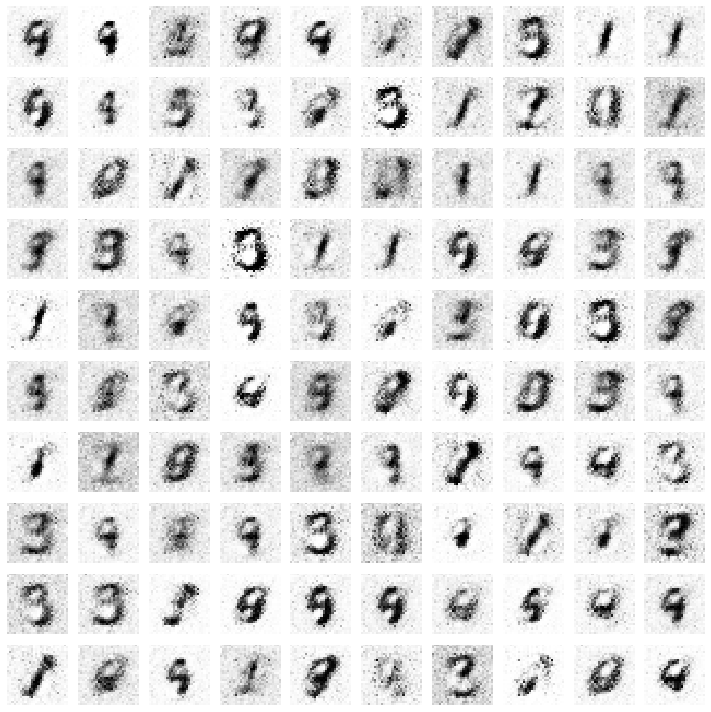

In [ ]:
train(epochs=10)